# Standard modules

In [1]:
import tracemalloc
import psutil
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import pandas as pd
import numpy as np
from time import time
pd.options.display.max_colwidth = 1000
from joblib import Parallel, delayed
from sklearn import show_versions
show_versions()


System:
    python: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21)  [GCC 10.3.0]
executable: /home/mauricio/miniconda3/envs/dev/bin/python
   machine: Linux-5.15.0-47-generic-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.1.2
          pip: 22.2.2
   setuptools: 60.10.0
        numpy: 1.22.0
        scipy: 1.9.1
       Cython: None
       pandas: 1.4.4
   matplotlib: 3.5.3
       joblib: 1.1.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
         prefix: libmkl_rt
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libmkl_rt.so.2
        version: 2022.1-Product
threading_layer: intel
    num_threads: 8

       user_api: openmp
   internal_api: openmp
         prefix: libomp
       filepath: /home/mauricio/miniconda3/envs/dev/lib/libomp.so
        version: None
    num_threads: 16


In [2]:
np.show_config()

blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = f77
lapack_opt_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas', 'cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = c
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
Supported SIM

In [3]:
from scipy import show_config
show_config()

lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
openblas_clapack_info:
  NOT AVAILABLE
flame_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
atlas_threads_info:
  NOT AVAILABLE
atlas_info:
  NOT AVAILABLE
accelerate_info:
  NOT AVAILABLE
lapack_info:
    libraries = ['lapack', 'blas', 'lapack', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABLE
atlas_blas_info:
  NOT AVAILABLE
blas_info:
    libraries = ['cblas', 'blas', 'cblas', 'blas']
    library_dirs = ['/home/mauricio/miniconda3/envs/dev/lib']
    include_dirs = ['/home/mauricio/miniconda3/envs/dev/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_

# Custom modules

In [4]:
# Custom modules: add the 'lib' directory as one where we can import modules
lib_src = '../../machine-learning'
sys.path.insert(1, lib_src)
from size import size
from to_csv_to_zip import to_csv_to_zip
from fit_cache import fit_cache
lib_src = '../../homewise/ds-core/'
sys.path.insert(1, lib_src)
from tools import glimpse, correlation_heatmap, numeric_statistics

# Exploring training data

## Load and view training data

In [5]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

### Multi-class multi-label

[https://www.drivendata.org/competitions/4/box-plots-for-education/page/15/#labels_list]

`Object_Type` describes what the spending "is" while the other 8 categories describe what the spending "does", which groups of students benefit, and where the funds come from.

In [6]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
df[LABELS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Function          400277 non-null  object
 1   Object_Type       400277 non-null  object
 2   Operating_Status  400277 non-null  object
 3   Position_Type     400277 non-null  object
 4   Pre_K             400277 non-null  object
 5   Reporting         400277 non-null  object
 6   Sharing           400277 non-null  object
 7   Student_Type      400277 non-null  object
 8   Use               400277 non-null  object
dtypes: object(9)
memory usage: 30.5+ MB


There is a hierarchical relationship for these labels. If a line is marked as `'Non-Operating'` in the `Operating_Status` category, then all of the other labels should be marked as `'NO_LABEL'` since ERS does not analyze and compare non-operating budget items.

Checking which `Operating_Status` come along with all other labels marked as `'NO_LABEL'`.

In [7]:
other_labels = [l for l in LABELS if l !='Operating_Status']
df[(df[other_labels]=='NO_LABEL').all(axis=1)].groupby(['Operating_Status'] + other_labels,).size()

Operating_Status        Function  Object_Type  Position_Type  Pre_K     Reporting  Sharing   Student_Type  Use     
Non-Operating           NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL    48034
Operating, Not PreK-12  NO_LABEL  NO_LABEL     NO_LABEL       NO_LABEL  NO_LABEL   NO_LABEL  NO_LABEL      NO_LABEL     8665
dtype: int64

### Features

* `FTE` If an employee, the percentage of full-time that the employee works.
* `Facility_or_Department` - If expenditure is tied to a department/facility, that department/facility.
* `Function_Description` - A description of the function the expenditure was serving.
* `Fund_Description` - A description of the source of the funds.
* `Job_Title_Description` - If this is an employee, a description of that employee's job title.
* `Location_Description` - A description of where the funds were spent.
* `Object_Description` - A description of what the funds were used for.
* `Position_Extra` - Any extra information about the position that we have.
* `Program_Description` - A description of the program that the funds were used for.
* `SubFund_Description` - More detail on Fund_Description
* `Sub_Object_Description` - More detail on Object_Description
* `Text_1` - Any additional text supplied by the district.
* `Text_2` - Any additional text supplied by the district.
* `Text_3` - Any additional text supplied by the district.
* `Text_4` - Any additional text supplied by the district.
* `Total` The total cost of the expenditure.

In [8]:
FEATURES = [feature for feature in df.columns if feature not in LABELS]
df[FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Object_Description      375493 non-null  object 
 1   Text_2                  88217 non-null   object 
 2   SubFund_Description     306855 non-null  object 
 3   Job_Title_Description   292743 non-null  object 
 4   Text_3                  109152 non-null  object 
 5   Text_4                  53746 non-null   object 
 6   Sub_Object_Description  91603 non-null   object 
 7   Location_Description    162054 non-null  object 
 8   FTE                     126071 non-null  float64
 9   Function_Description    342195 non-null  object 
 10  Facility_or_Department  53886 non-null   object 
 11  Position_Extra          264764 non-null  object 
 12  Total                   395722 non-null  float64
 13  Program_Description     304660 non-null  object 
 14  Fund_Descriptio

### Numeric features

In [9]:
NUMERIC_FEATURES = ['FTE', 'Total']
df[NUMERIC_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     126071 non-null  float64
 1   Total   395722 non-null  float64
dtypes: float64(2)
memory usage: 9.2 MB


### Text features

In [10]:
TEXT_FEATURES = [text_feature for text_feature in FEATURES if text_feature not in NUMERIC_FEATURES]
df[TEXT_FEATURES].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Object_Description      375493 non-null  object
 1   Text_2                  88217 non-null   object
 2   SubFund_Description     306855 non-null  object
 3   Job_Title_Description   292743 non-null  object
 4   Text_3                  109152 non-null  object
 5   Text_4                  53746 non-null   object
 6   Sub_Object_Description  91603 non-null   object
 7   Location_Description    162054 non-null  object
 8   Function_Description    342195 non-null  object
 9   Facility_or_Department  53886 non-null   object
 10  Position_Extra          264764 non-null  object
 11  Program_Description     304660 non-null  object
 12  Fund_Description        202877 non-null  object
 13  Text_1                  292285 non-null  object
dtypes: object(14)
memory usage: 45.

## Missing values

Overall count and proportion of missing data

In [11]:
missing = df.isnull()
missing.sum().sum(), missing.mean().mean()

(2942109, 0.2940072999447882)

In [12]:
# plt.figure(figsize=(25,12))
# sns.heatmap(~missing, cbar=False)
# plt.show()

### Missing features

Missing report function: Count and proportion of missing data per column

In [13]:
def missing_report(df):
    area = (df.shape[0]*(df.shape[1]))
    proportion = lambda x: x.sum() / area
    missing = df.isnull().agg(['sum', 'mean', proportion]).transpose()
    missing = missing.sort_values('sum', ascending=False)
    missing.columns = ['missing', 'column proportion', 'overall proportion']
    missing['missing'] = missing.missing.astype('int')
    return missing

In [14]:
missing_report(df[FEATURES])

missing  column proportion  overall proportion
Text_4                   346531           0.865728            0.054108
Facility_or_Department   346391           0.865378            0.054086
Text_2                   312060           0.779610            0.048726
Sub_Object_Description   308674           0.771151            0.048197
Text_3                   291125           0.727309            0.045457
FTE                      274206           0.685041            0.042815
Location_Description     238223           0.595145            0.037197
Fund_Description         197400           0.493158            0.030822
Position_Extra           135513           0.338548            0.021159
Text_1                   107992           0.269793            0.016862
Job_Title_Description    107534           0.268649            0.016791
Program_Description       95617           0.238877            0.014930
SubFund_Description       93422           0.233393            0.014587
Function_Description      58082           0.145105            0.009069
Object_Description        24784           0.061917            0.003870
Total                      4555           0.011380            0.000711

The numeric variable `FTE` lacks `68%` and `Total` lacks only `1%`.  The most frequent text feature is `Object Description`.

### **No missing labels**

No label has missing data

In [15]:
missing[LABELS].all().all()

False

### **Missing `FTE`**

Let's subtotal missing `FTE` by `Object Description`.

One can see high ocurrences of missing `FTE` for `Object_Descritption` such as `"EMPLOYEE BENEFITS"`, similar ones, `"SUPPLIES"` and so on.

In [16]:
# .fillna({'Object_Description':'NaN'})
df.loc[df.FTE.isnull()].groupby('Object_Description', dropna=False).size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                 47495
CONTRA BENEFITS                   19381
ADDITIONAL/EXTRA DUTY PAY/STIP    16841
SUPPLIES                          13117
RETIREMENT CONTRIB.               13073
                                  ...  
PMT REFUNDED BOND ESCROW AGENT        1
FOOD ACQUISITIONS - USDA              1
Custodial  Supplies                   1
FILMS PURCHASED                       1
Land Purchase And Improvement         1
Length: 555, dtype: int64

### **Missing `Total`**

Let's subtotal missing `Total` by `Object Description`.

One can see less high occurrences of missing `Total` for `Object_description` such as `"EMPLOYEE BENEFITS"` and so on.

In [17]:
# .fillna({'Object_Description':'NaN'})
df.loc[df.Total.isnull()].groupby('Object_Description', dropna=False).size().sort_values(ascending=False)

Object_Description
EMPLOYEE BENEFITS                                     1184
SALARIES OF REGULAR EMPLOYEES                          876
EMPLOYER PD MED CONTRIBUTION                           295
Salaries And Wages For Teachers And Other Professi     288
NaN                                                    261
                                                      ... 
PURCHASED PROFESSIONAL AND TECH SVCS-CPA                 1
PURCHASED PROF AND TECH SVC-TEMPORARY SVCS               1
Instructional Materials                                  1
PURCHASE OR LEASE - PURCHASE OF COMPUTERS                1
Other                                                    1
Length: 217, dtype: int64

### Missing `Total` and `FTE` relationship

For missing `FTE` we can see very high `Total` values, like 129,7 millions, possibly an outlier.

In [18]:
f'{df.Total.max():,.2f}'

'129,699,999.22'

In [19]:
df.loc[df.FTE.isnull(), ['Total', 'FTE', 'Object_Description']].sort_values('Total', ascending=False)

Total  FTE               Object_Description
358538  1.297000e+08  NaN  Payments to a Community School*
322149  5.323797e+07  NaN         Other Purchased Services
390959  4.789057e+07  NaN        PAYMENTS TO ESCROW AGENTS
177775  3.956446e+07  NaN               INTEREST ON LEASES
331752  3.645094e+07  NaN                        BUILDINGS
...              ...  ...                              ...
300250           NaN  NaN                EMPLOYEE BENEFITS
289753           NaN  NaN    SALARIES OF REGULAR EMPLOYEES
438970           NaN  NaN                EMPLOYEE BENEFITS
334668           NaN  NaN                EMPLOYEE BENEFITS
29710            NaN  NaN                EMPLOYEE BENEFITS

[274206 rows x 3 columns]

For missing `Total` we can see `FTE` values, likely inliers.

In [20]:
f'{df.FTE.max():,.2f}'

'46.80'

In [21]:
df.loc[df.Total.isnull(), ['FTE', 'Total', 'Object_Description']].sort_values('FTE', ascending=False)

FTE  Total             Object_Description
392540  1.127804    NaN  SALARIES OF REGULAR EMPLOYEES
147244  1.016335    NaN  SALARIES OF REGULAR EMPLOYEES
91088   1.012847    NaN  SALARIES OF REGULAR EMPLOYEES
60354   1.012223    NaN  SALARIES OF REGULAR EMPLOYEES
203019  1.009218    NaN  SALARIES OF REGULAR EMPLOYEES
...          ...    ...                            ...
300250       NaN    NaN              EMPLOYEE BENEFITS
289753       NaN    NaN  SALARIES OF REGULAR EMPLOYEES
438970       NaN    NaN              EMPLOYEE BENEFITS
334668       NaN    NaN              EMPLOYEE BENEFITS
29710        NaN    NaN              EMPLOYEE BENEFITS

[4555 rows x 3 columns]

## Continuous variables: FTE and Total

**`FTE`: full-time equivalent** - If the budget item is associated to an employee, this number tells us the **percent** of full-time that the employee works.
* A value of 1 suggests an associated employee works full-time.
* A value greater than 1 suggests overtime or multiple headcount
* A value smaller than 1 suggests a part-time or contracted employee.

**`Total`: total cost of the expenditure** - This number tells us how much the budget item cost.

The reason of negative values is currently unknown.

### Disambiguation of Total when having FTE

In [22]:
from preprocessing.disambiguate import disambiguate

In [23]:
numeric_statistics(df[NUMERIC_FEATURES])

count          mean            std           min        25%  \
FTE    126071      0.426794       0.573576 -8.755064e-02   0.000792   
Total  395722  13105.856828  368225.392358 -8.746631e+07  73.797700   

              50%        75%           max  missing  miss_ratio           sum  \
FTE      0.130927     1.0000  4.680000e+01   274206    0.685041  5.380634e+04   
Total  461.230000  3652.6625  1.297000e+08     4555    0.011380  5.186276e+09   

              range    skewness      kurtosis          iqr  lo_outlier  \
FTE    4.688755e+01   19.273698   1172.951126     0.999208    -1.49802   
Total  2.171663e+08  100.319800  51040.801730  3578.864800 -5294.49950   

        hi_outlier  
FTE       2.498812  
Total  9020.959700

In [24]:
df[['FTE', 'Total', 'Total_FTE']] = disambiguate(df[NUMERIC_FEATURES], 'FTE', 'Total')
NUMERIC_FEATURES = ['FTE', 'Total', 'Total_FTE']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
df[NUMERIC_FEATURES]

FTE        Total     Total_FTE
134338  1.00000          NaN  50471.808594
206341      NaN  3477.860107           NaN
326408  1.00000          NaN  62237.128906
364634      NaN    22.299999           NaN
47683       NaN    54.166000           NaN
...         ...          ...           ...
109283      NaN    48.619999           NaN
102430  0.00431          NaN    128.824982
413949  1.00000          NaN   4902.290039
433672      NaN  4020.290039           NaN
415831      NaN    46.529999           NaN

[400277 rows x 3 columns]

In [25]:
numeric_statistics(df)

count          mean            std           min          25%  \
FTE        126071      0.426794       0.573575 -8.755064e-02     0.000792   
Total      302248   7349.923340  420744.343750 -8.746630e+07    36.334320   
Total_FTE   93474  31717.650391   33972.351562 -4.876100e+03  1034.974121   

                    50%           75%           max  missing  miss_ratio  \
FTE            0.130927      1.000000  4.680000e+01   274206    0.685041   
Total        259.119995   1166.959961  1.297000e+08    98029    0.244903   
Total_FTE  22124.984375  53287.390625  8.458357e+05   306803    0.766477   

                    sum         range   skewness      kurtosis           iqr  \
FTE        5.380634e+04  4.688755e+01  19.273699   1172.951294      0.999208   
Total      2.221500e+09  2.171663e+08  88.084709  39207.949219   1130.625641   
Total_FTE  2.964776e+09  8.507118e+05   1.540053     10.574129  52252.416504   

             lo_outlier     hi_outlier  
FTE           -1.498020       2.498812  
Total      -1659.604141    2862.898422  
Total_FTE -77343.650635  131666.015381

Function to plot a panel with a scatter, density and box plots:

In [26]:
from scipy.stats import zscore
def density_plots(x, label=None, outlying = True, zthreshold = 3, bins=None, figsize=(19,4)):

    label = x.name if label is None else label
    if outlying:
        x_mean = x.mean()
        x_std = x.std()
        lower_limit = x_mean - zthreshold * x_std
        upper_limit = x_mean + zthreshold * x_std
        zscr = zscore(x, nan_policy='omit')
        outliers = x[(zscr < -zthreshold) | (zscr > zthreshold)]

    plt.figure(figsize=figsize)

    # scatter plot
    plt.subplot(1,3,1); plt.grid(False)
    plt.plot(x, marker='.', linestyle='none', color='green', label='inlier')
    plt.ylabel(label); plt.xlabel('row')
    if outlying:
        plt.plot(outliers, marker='.', linestyle='none', color='red', label='outlier')
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # density plot
    plt.subplot(1,3,2); plt.grid(False)
    plt.hist(x, bins=bins)
    plt.xlabel(label); plt.ylabel('PDF')

    if outlying:
        plt.axvline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axvline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    # box plot
    plt.subplot(1,3,3); plt.grid(False)
    plt.boxplot(x.dropna())
    plt.ylabel(label)

    if outlying:
        plt.axhline(lower_limit, linestyle='dotted', color='red', label=f'{zthreshold} z-score')
        plt.axhline(upper_limit, linestyle='dotted', color='red')
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

### `FTE` univariate analysis

In [27]:
df.FTE.describe()

count    126071.000000
mean          0.426794
std           0.573575
min          -0.087551
25%           0.000792
50%           0.130927
75%           1.000000
max          46.799999
Name: FTE, dtype: float64

`FTE` contains bi-modal skewed data with upper outliers

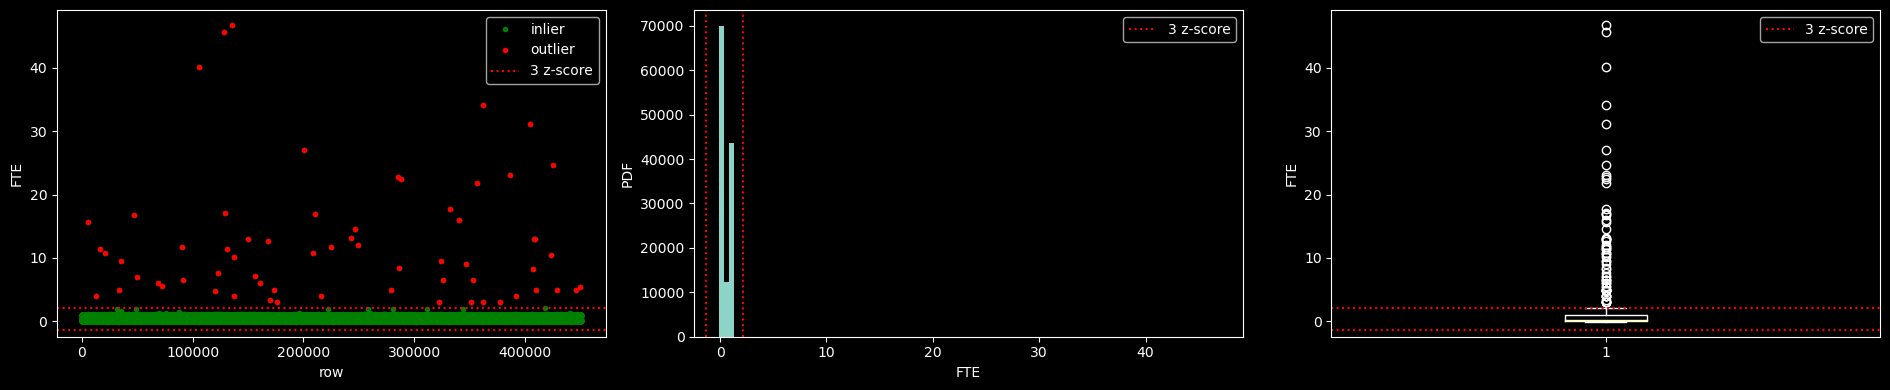

Upper outliers: 64
Lower outliers: 0


In [28]:
density_plots(df.FTE, bins=100)
zscores = zscore(df.FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

`FTE` outliers hold values up to`46.8` and are assumed to be multiple headcount.

In [29]:
relevant = ['FTE', 'Total_FTE', 'Total', 'Fund_Description', 'Object_Description', 'Job_Title_Description']
df.loc[(zscores < -3) | (zscores > 3), relevant].sort_values('FTE', ascending=False)

FTE      Total_FTE  Total   Fund_Description  \
135371  46.799999  528192.000000    NaN  Central Cafeteria   
128399  45.599998  478476.906250    NaN  Central Cafeteria   
105857  40.200001  580900.062500    NaN  Central Cafeteria   
362251  34.200001  484744.875000    NaN  Central Cafeteria   
404264  31.100000  352252.937500    NaN  Central Cafeteria   
...           ...            ...    ...                ...   
362443   3.000000  280332.906250    NaN            General   
377132   3.000000  149857.500000    NaN            General   
351528   3.000000  162472.656250    NaN            General   
176122   3.000000  130486.445312    NaN            General   
322285   3.000000  135557.937500    NaN            General   

                                   Object_Description Job_Title_Description  
135371  Personal Services - Food Services - Cafeteria                   NaN  
128399  Personal Services - Food Services - Cafeteria                   NaN  
105857  Personal Services - Food Services - Cafeteria                   NaN  
362251  Personal Services - Food Services - Cafeteria                   NaN  
404264  Personal Services - Food Services - Cafeteria                   NaN  
...                                               ...                   ...  
362443                                      Regular *   TCHR, OCC THERAPIST  
377132                                      Regular *    EDUCATIONAL AIDE I  
351528                                      Regular *         MOBILE DEPUTY  
176122                                      Regular *             PARA (MF)  
322285                                      Regular *             PARA (OH)  

[64 rows x 6 columns]

What if to remove outliers?

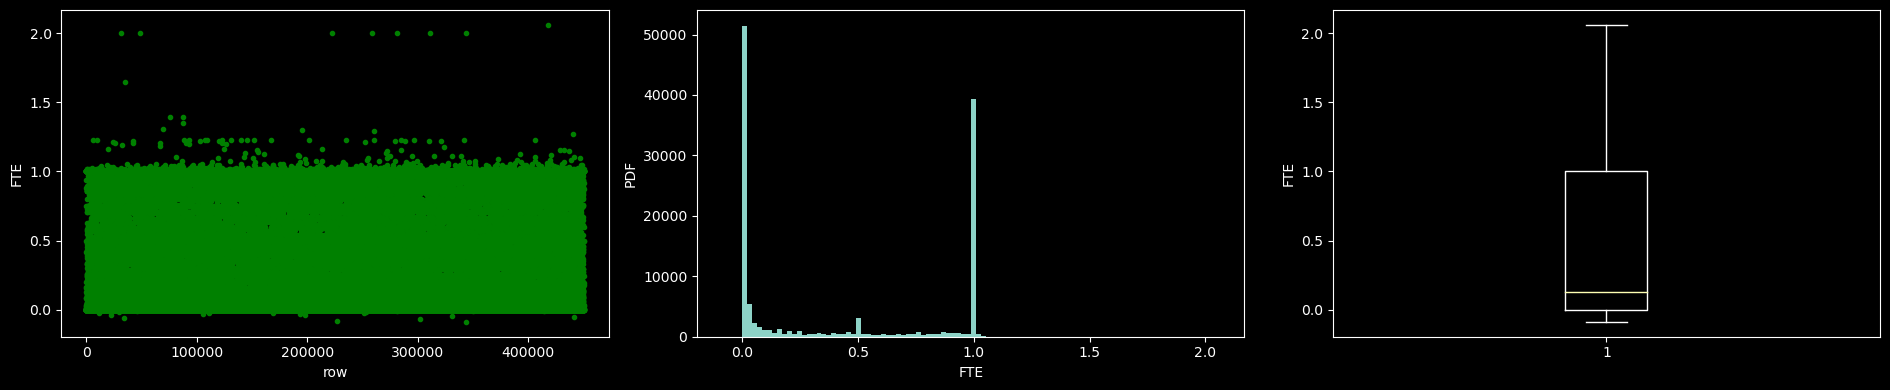

In [30]:
density_plots(df.FTE[(zscores >= -3) & (zscores <= 3)], outlying=False, bins=100)

Binning with and without outliers

In [31]:
pd.cut(df.FTE, bins=4).dtype

CategoricalDtype(categories=[(-0.134, 11.634], (11.634, 23.356], (23.356, 35.078], (35.078, 46.8]], ordered=True)

In [32]:
pd.cut(df.FTE[(zscores >= -3) & (zscores <= 3)], bins=4).dtype

CategoricalDtype(categories=[(-0.0897, 0.449], (0.449, 0.986], (0.986, 1.523], (1.523, 2.06]], ordered=True)

### `Total_FTE` univariate analysis

In [33]:
df.Total_FTE.describe()

count     93474.000000
mean      31717.650391
std       33972.351562
min       -4876.099609
25%        1034.974121
50%       22124.984375
75%       53287.390625
max      845835.687500
Name: Total_FTE, dtype: float64

`Total_FTE` contains upper and lower outliers with magnitude of 800,000.

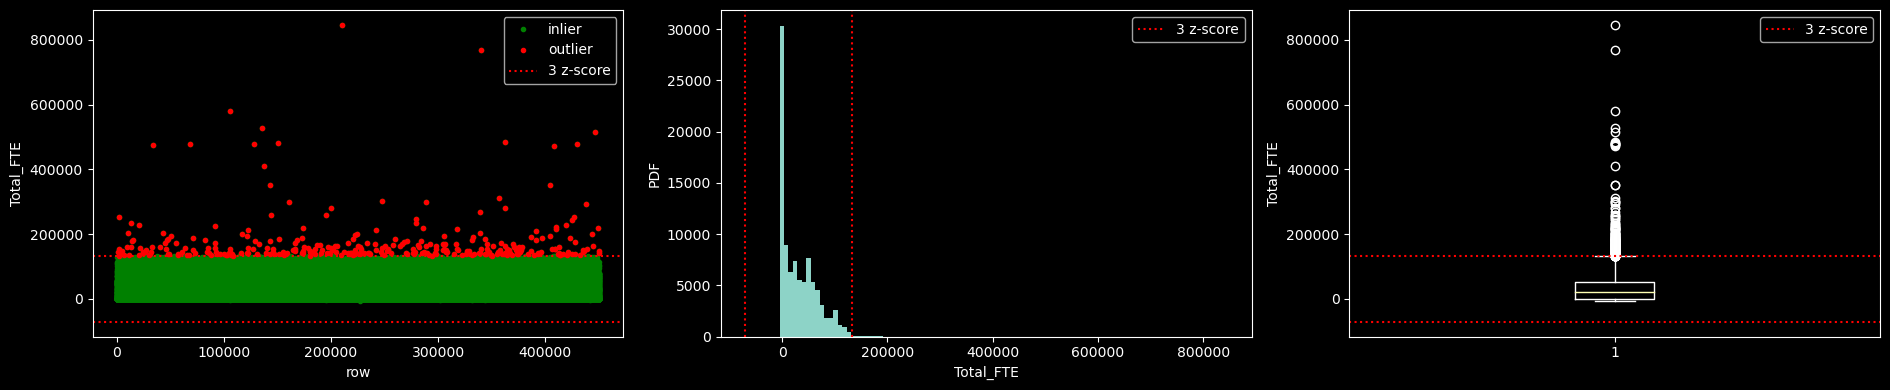

Upper outliers: 312
Lower outliers: 0


In [34]:
density_plots(df.Total_FTE, bins=100)
zscores = zscore(df.Total_FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

In [35]:
df.loc[(zscores < -3) | (zscores > 3), relevant].sort_values('Total_FTE', ascending=False)

FTE      Total_FTE  Total           Fund_Description  \
210055  17.000000  845835.687500    NaN                    General   
340130  16.000000  768873.250000    NaN                    General   
105857  40.200001  580900.062500    NaN          Central Cafeteria   
135371  46.799999  528192.000000    NaN          Central Cafeteria   
446104   5.000000  514157.656250    NaN  Improving Teacher Quality   
...           ...            ...    ...                        ...   
294188   1.000000  134038.515625    NaN                    General   
180640   1.000000  134038.171875    NaN                    General   
108020   1.000000  134037.953125    NaN                    General   
2516     1.000000  133867.187500    NaN               General Fund   
350493   1.000000  133855.937500    NaN               General Fund   

                                   Object_Description  \
210055                                      Regular *   
340130                                      Regular *   
105857  Personal Services - Food Services - Cafeteria   
135371  Personal Services - Food Services - Cafeteria   
446104                                      Regular *   
...                                               ...   
294188                                      Regular *   
180640                                      Regular *   
108020                                      Regular *   
2516                                              NaN   
350493                                            NaN   

                              Job_Title_Description  
210055  EDUCATIONAL AIDE I - Preschool Supplemental  
340130                                  LEAD DRIVER  
105857                                          NaN  
135371                                          NaN  
446104              CLASSROOM TEACHERS - TITLE II A  
...                                             ...  
294188                        SENIOR HIGH PRINCIPAL  
180640                        SENIOR HIGH PRINCIPAL  
108020                        SENIOR HIGH PRINCIPAL  
2516                           Principal-Elementary  
350493                         Principal-Elementary  

[312 rows x 6 columns]

What if to remove outliers?

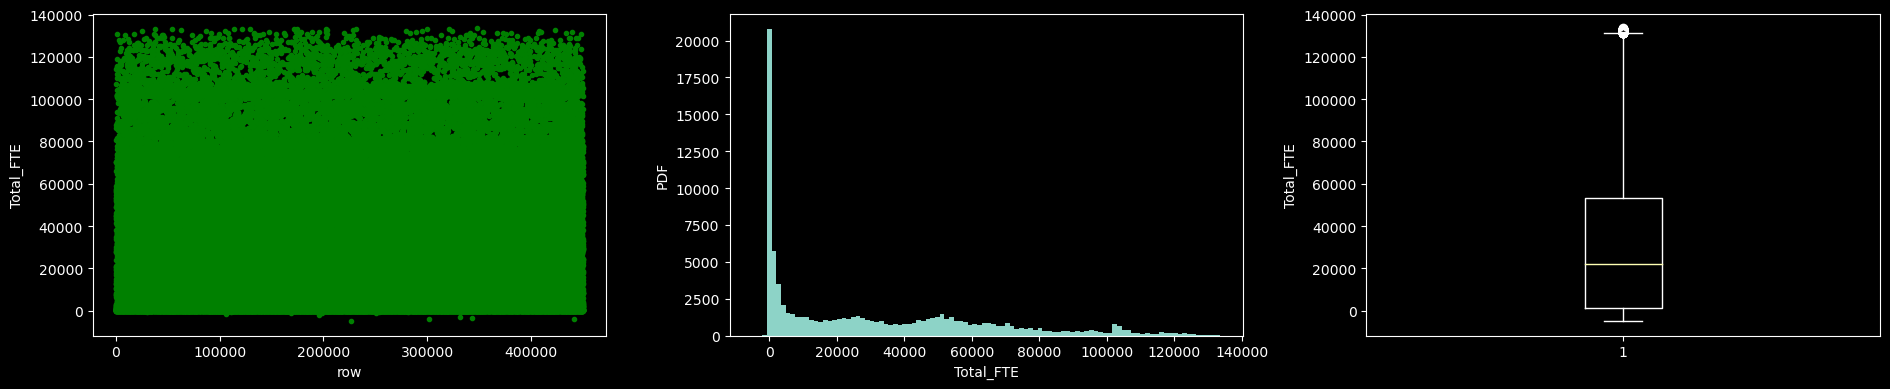

In [36]:
density_plots(df.Total_FTE[(zscores >= -3) & (zscores <= 3)], outlying=False, bins=100)

Binning with and without outliers

In [37]:
pd.cut(df.Total_FTE, bins=3).dtype

CategoricalDtype(categories=[(-5726.811, 278694.496], (278694.496, 562265.092], (562265.092, 845835.688]], ordered=True)

In [38]:
pd.cut(df.Total_FTE[(zscores >= -3) & (zscores <= 3)], bins=3).dtype

CategoricalDtype(categories=[(-5014.438, 41236.595], (41236.595, 87349.29], (87349.29, 133461.984]], ordered=True)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

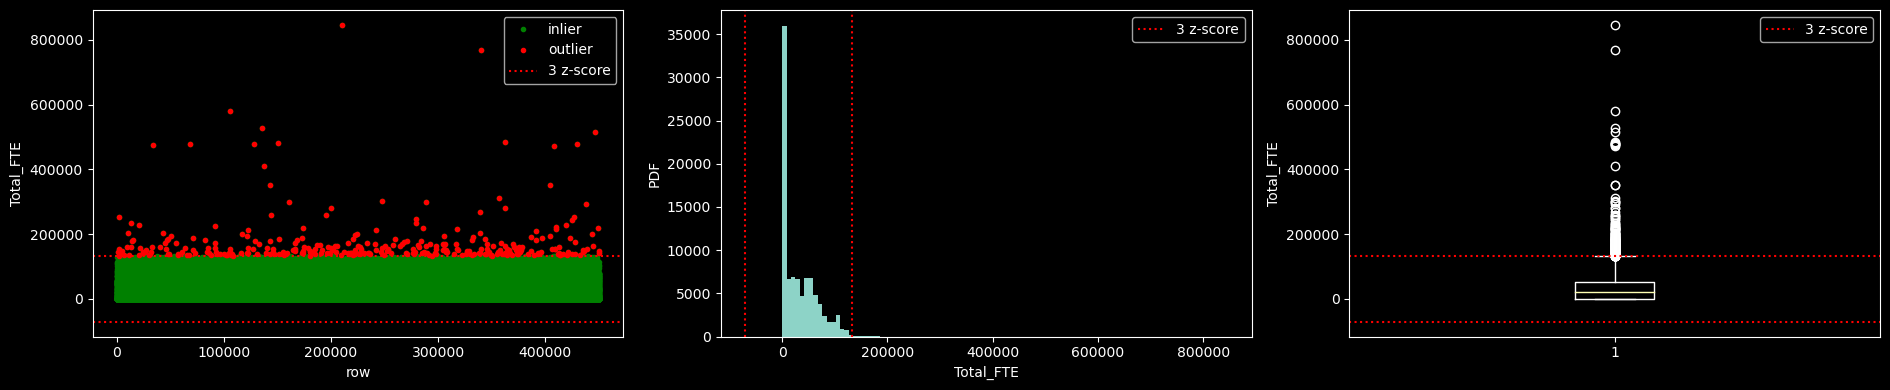

Upper outliers: 312
Lower outliers: 0


In [39]:
density_plots(df.Total_FTE.abs(), bins=100)
zscores_fixed = zscore(df.Total_FTE.abs(), nan_policy='omit')
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### `Total` univariate analysis

In [40]:
df.Total.describe()

count    3.022480e+05
mean     7.349923e+03
std      4.207443e+05
min     -8.746630e+07
25%      3.633432e+01
50%      2.591200e+02
75%      1.166960e+03
max      1.297000e+08
Name: Total, dtype: float64

`Total` contains upper and lower outliers with magnitude or +/- 100 millions.

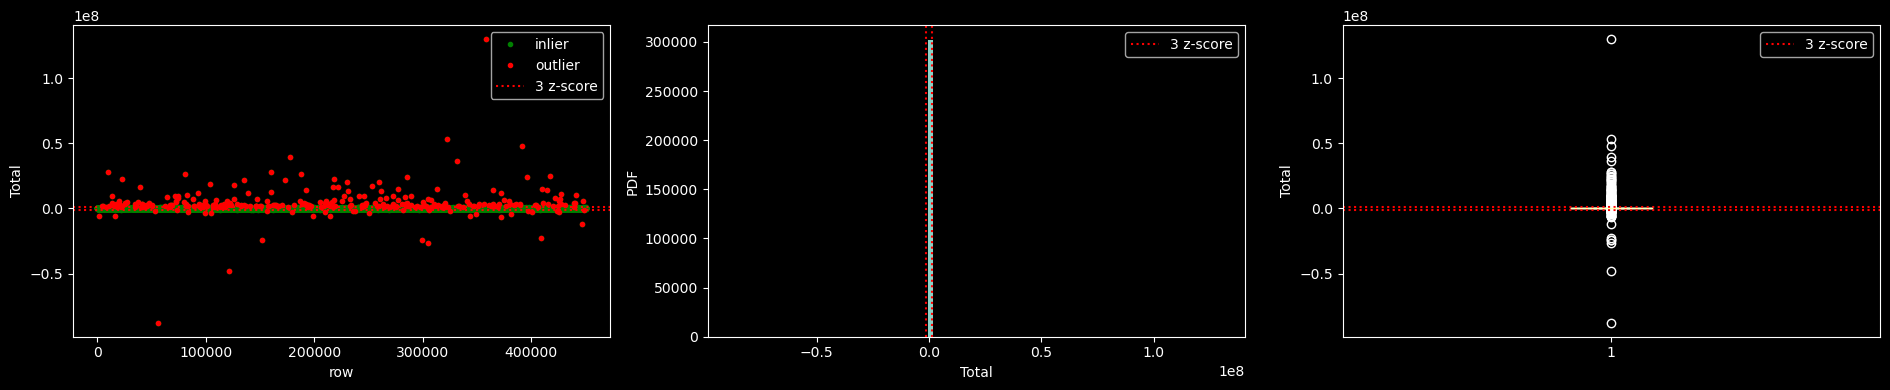

Upper outliers: 280
Lower outliers: 34


In [41]:
density_plots(df.Total, bins=100)
zscores = zscore(df.Total, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

In [42]:
df.loc[(zscores < -3) | (zscores > 3), relevant].sort_values('Total', ascending=False)

FTE  Total_FTE        Total                  Fund_Description  \
358538  NaN        NaN  129700000.0                           General   
322149  NaN        NaN   53237976.0  Employee Benefits Self-Insurance   
390959  NaN        NaN   47890568.0                               NaN   
177775  NaN        NaN   39564460.0                               NaN   
331752  NaN        NaN   36450944.0                               NaN   
...     ...        ...          ...                               ...   
152005  NaN        NaN  -23999664.0                      General Fund   
299589  NaN        NaN  -24000000.0             Capital Projects Fund   
304649  NaN        NaN  -26465000.0                               NaN   
121092  NaN        NaN  -47890568.0                               NaN   
56063   NaN        NaN  -87466304.0                               NaN   

                        Object_Description Job_Title_Description  
358538     Payments to a Community School*                   NaN  
322149            Other Purchased Services                   NaN  
390959           PAYMENTS TO ESCROW AGENTS               (blank)  
177775                  INTEREST ON LEASES               (blank)  
331752                           BUILDINGS               (blank)  
...                                    ...                   ...  
152005  OPERATING TRANSFERS TO OTHER FUNDS                   NaN  
299589  OPERATING TRANSFERS TO OTHER FUNDS                   NaN  
304649             REDEMPTION OF PRINCIPAL               (blank)  
121092           PAYMENTS TO ESCROW AGENTS               (blank)  
56063                            BUILDINGS               (blank)  

[314 rows x 6 columns]

What if to remove outliers?

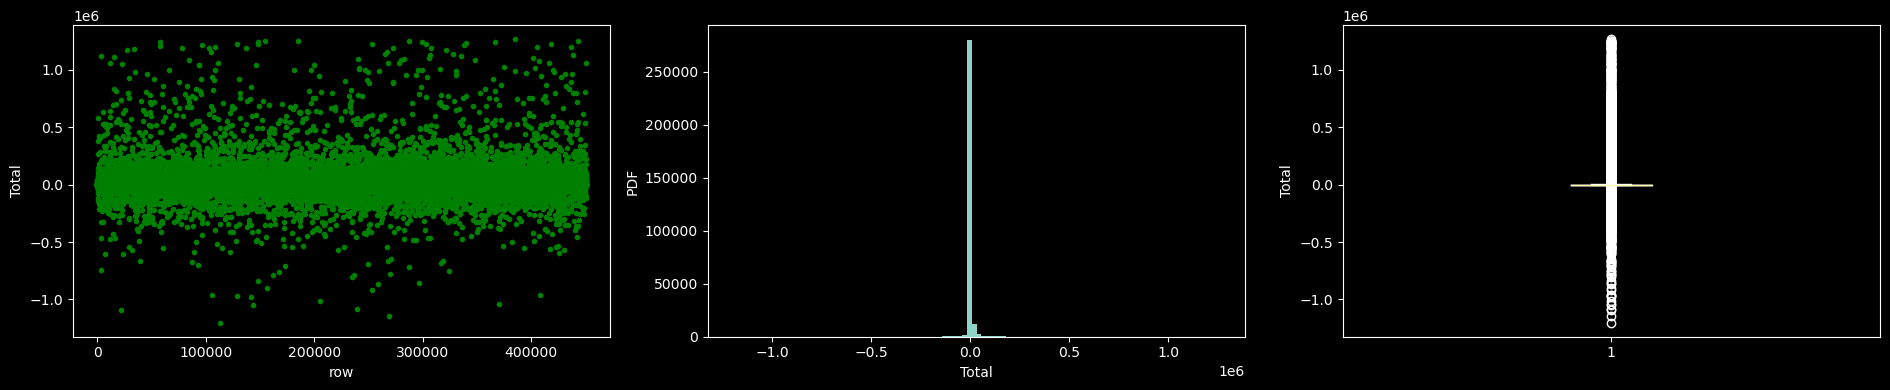

In [43]:
density_plots(df.Total[(zscores >= -3) & (zscores <= 3)], outlying=False, bins=100)

Binning with and without outliers

In [44]:
pd.cut(df.Total, bins=3).dtype

CategoricalDtype(categories=[(-87683470.304, -15077536.0], (-15077536.0, 57311232.0], (57311232.0, 129700000.0]], ordered=True)

In [45]:
pd.cut(df.Total[(zscores >= -3) & (zscores <= 3)], bins=3).dtype

CategoricalDtype(categories=[(-1204431.07, -379189.5], (-379189.5, 443583.75], (443583.75, 1266357.0]], ordered=True)

Under the hyphotesis that negative values are sign mistakes, what if to fix them by flipping their signs? **It would move most of the lower outliers to be upper outliers.**

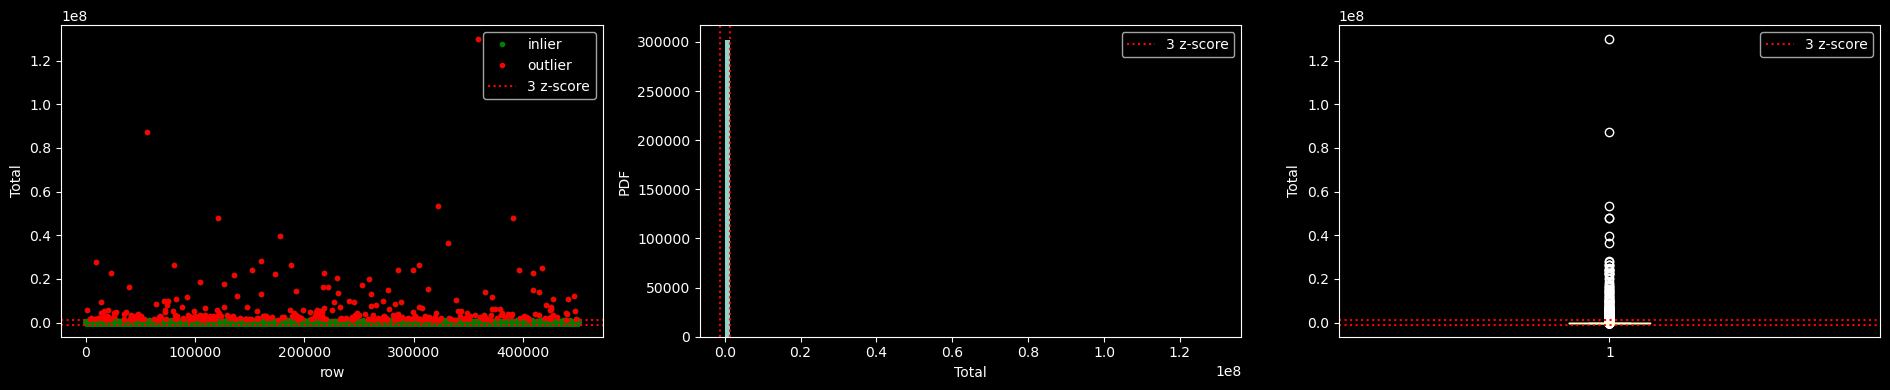

Upper outliers: 314
Lower outliers: 0


In [46]:
density_plots(df.Total.abs(), bins=100)
zscores_fixed = zscore(df.Total.abs(), nan_policy='omit')
print('Upper outliers:', sum(zscores_fixed > 3))
print('Lower outliers:', sum(zscores_fixed < -3))

### Regression and correlation by imputation strategy

In [47]:
def plot_regression_correlation_imputation(df, x, y, figsize=None):
    zero_imputed_df = df[[x, y]].fillna(0)
    mean_imputed_df = df[[x, y]].fillna(df[[x, y]].mean())
    median_imputed_df = df[[x, y]].fillna(df[[x, y]].median())

    plt.figure(figsize=figsize)
    xytext = (0.05, 0.5)
    textcoords='axes fraction'

    plt.subplot(2,2,1)
    sns.regplot(x=x, y=y, data=df[[x,y]])
    plt.annotate('Pearson = {:.12f}'.format(df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)
    plt.title('Raw')

    plt.subplot(2,2,2)
    sns.regplot(x=x, y=y, data=zero_imputed_df)
    plt.title('Zero imputed')
    plt.annotate('Pearson = {:.12f}'.format(zero_imputed_df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)

    plt.subplot(2,2,3)
    sns.regplot(x=x, y=y, data=mean_imputed_df)
    plt.title('Mean imputed')
    plt.annotate('Pearson = {:.12f}'.format(mean_imputed_df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)

    plt.subplot(2,2,4)
    sns.regplot(x=x, y=y, data=median_imputed_df)
    plt.title('Median imputed')
    plt.annotate('Pearson = {:.12f}'.format(median_imputed_df[[x,y]].corr().iloc[0,1]), xy=xytext, xytext=xytext, textcoords=textcoords)

    plt.tight_layout()
    plt.show()

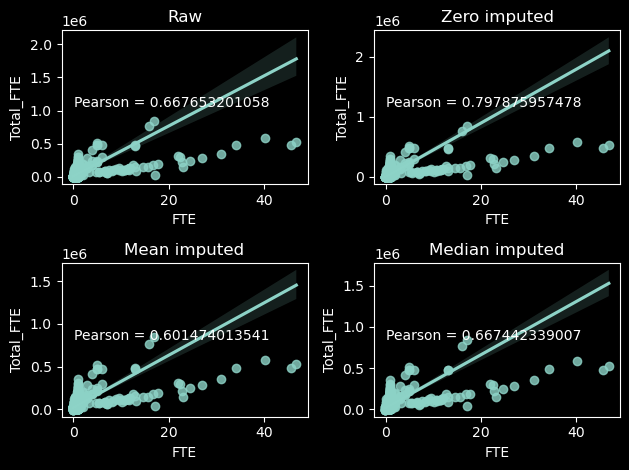

In [48]:
plot_regression_correlation_imputation(df, 'FTE', 'Total_FTE')

### Correlations grouped by labels by imputation strategy

In [49]:
def plot_grouped_correlation_imputation(df, x, y, by, figsize=(7,7)):
    grouped_corr = df[[by, x, y]]\
        .groupby(by).corr().unstack().iloc[:,2].to_frame('raw')
    
    grouped_corr['zero imputed'] = df[[by, x, y]].fillna({x: 0, y: 0})\
        .groupby(by).corr().unstack().iloc[:,2].rename('zero imputed')
    
    grouped_corr['mean imputed'] = df[[by, x, y]].fillna({x: df[x].mean(), y: df[y].mean()})\
        .groupby(by).corr().unstack().iloc[:,2].rename('mean imputed')
    
    grouped_corr['median imputed'] = df[[by, x, y]].fillna({x: df[x].median(), y:df[y].median()})\
        .groupby(by).corr().unstack().iloc[:,2].rename('median imputed')

    grouped_corr.sort_values('raw', ascending=True, na_position='first').plot(kind='barh', figsize=figsize, xlim=(-1,1))
    
    plt.title(f'{x} and {y} correlations grouped by {by}')
    plt.xlabel('Pearson Correlation')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

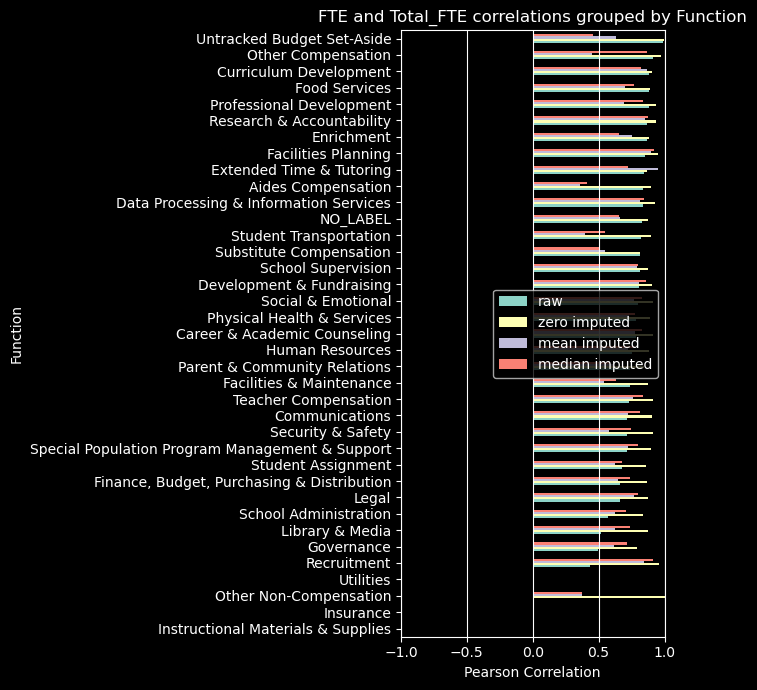

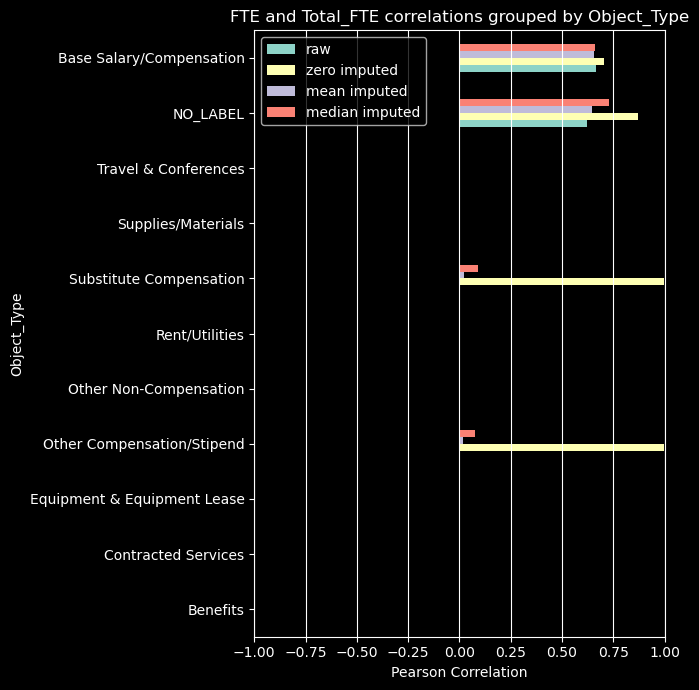

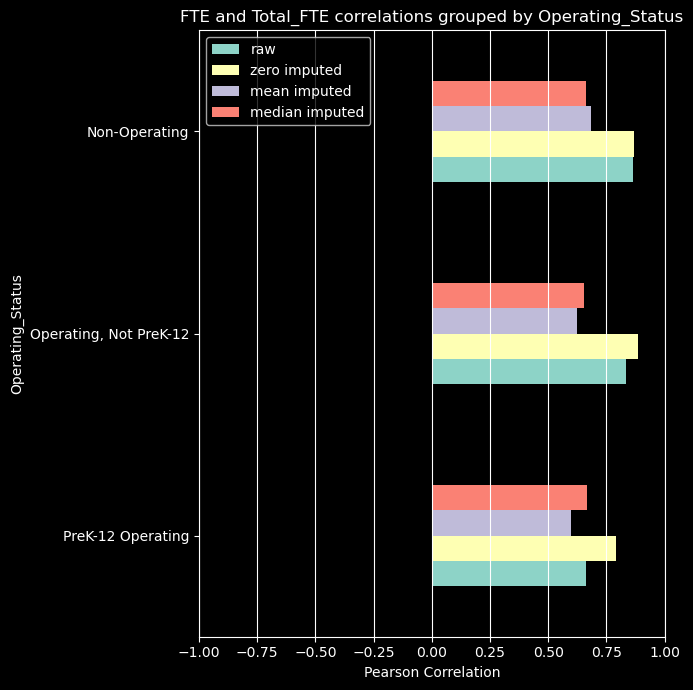

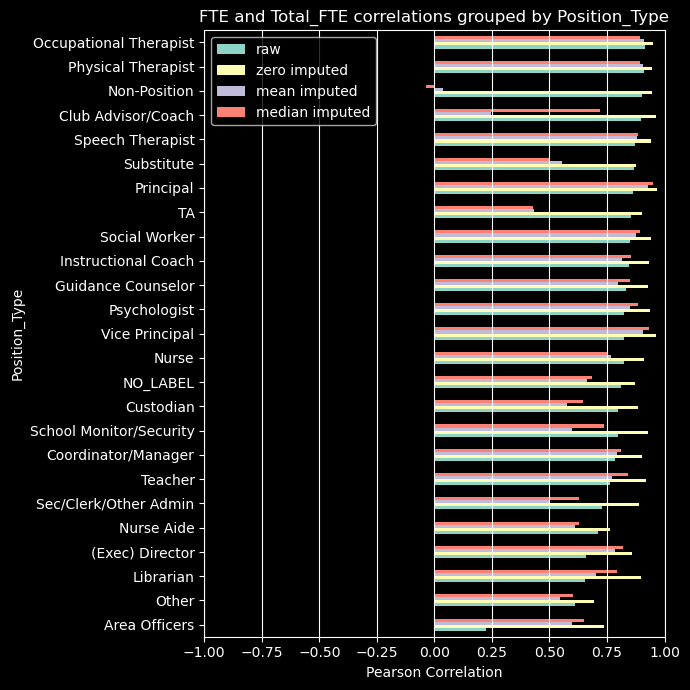

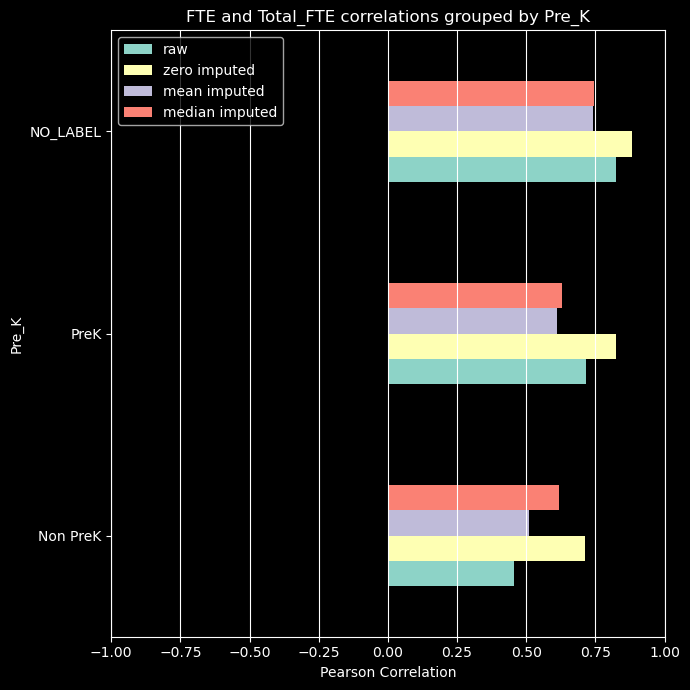

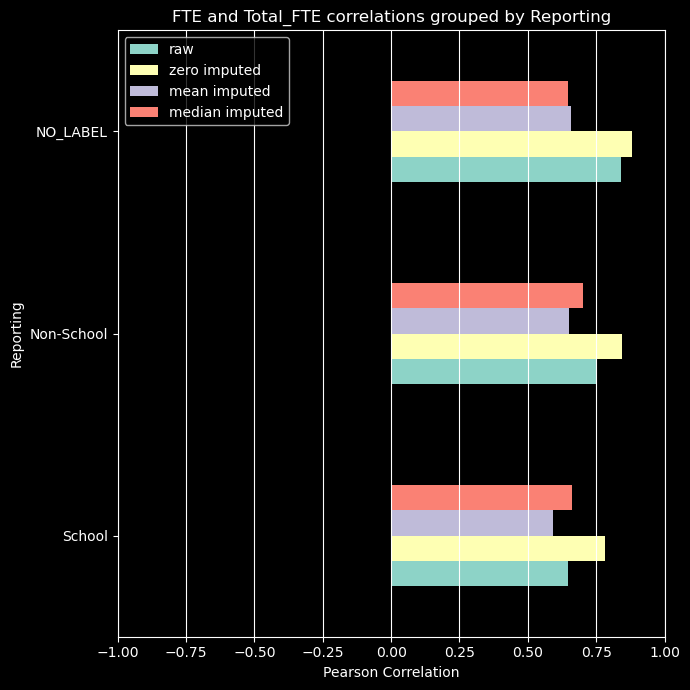

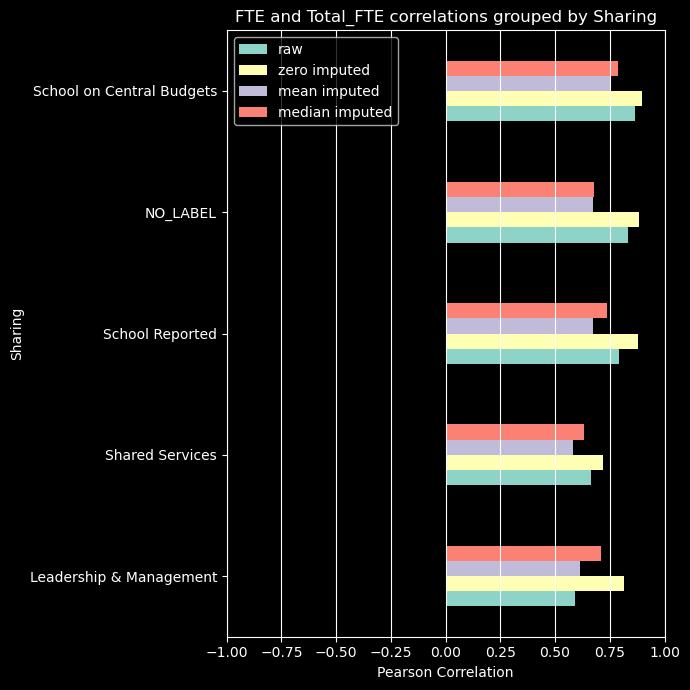

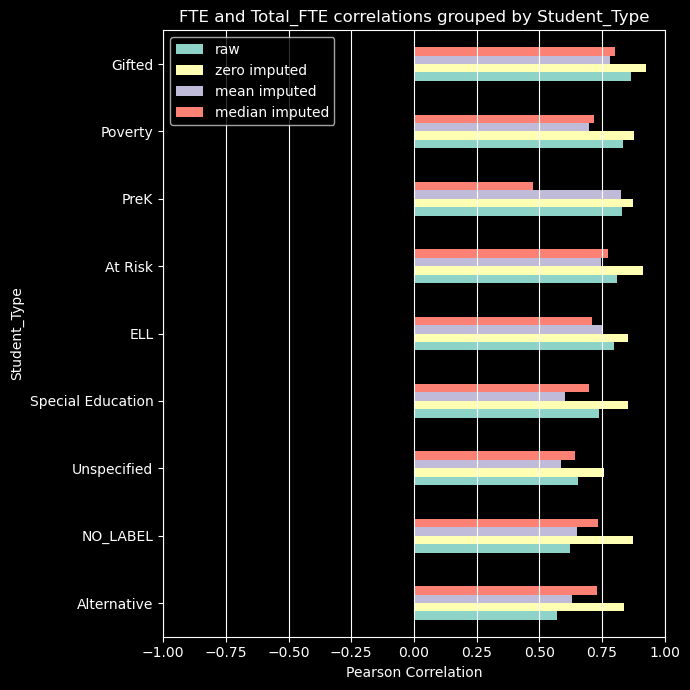

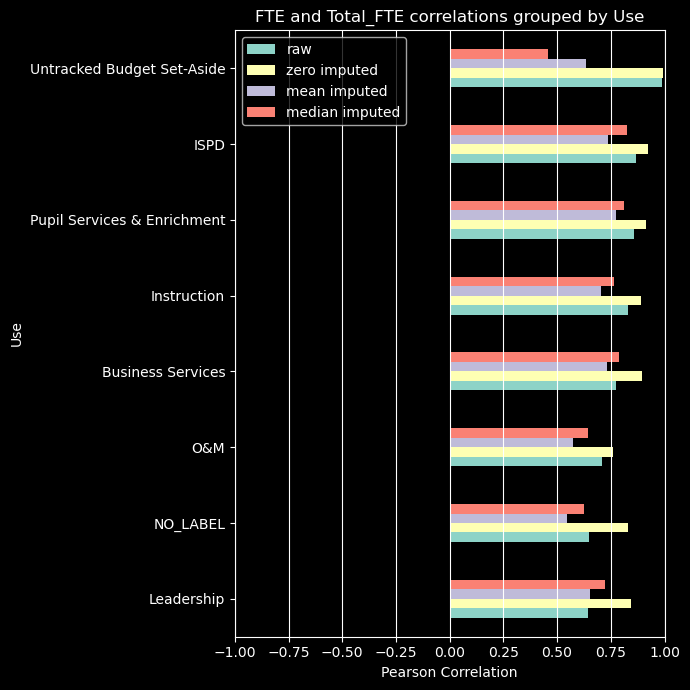

In [50]:
for label in LABELS:
    plot_grouped_correlation_imputation(df=df, x='FTE', y='Total_FTE', by=label)

### Statistics grouped by labels

In [51]:
def plot_grouped_statistics(df, cols, by=None, func=['median', 'mean'], figsize=(14,7)):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=figsize)
    fig.suptitle(f'Grouped by [{by}] subset [{", ".join(cols)}] aggregation [{", ".join(func)}]')

    df.groupby(by)[cols[0]].agg(func).plot(kind='barh', ax=axes[0], legend=False)
    fig.legend(loc='upper left')
    axes[0].set_xlabel(cols[0])

    for i in range(1, len(cols)):
        df.groupby(by)[cols[i]].agg(func).plot(kind='barh', ax=axes[i], legend=False)
        axes[i].set_xlabel(cols[i])
        axes[i].set_ylabel(None)
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()

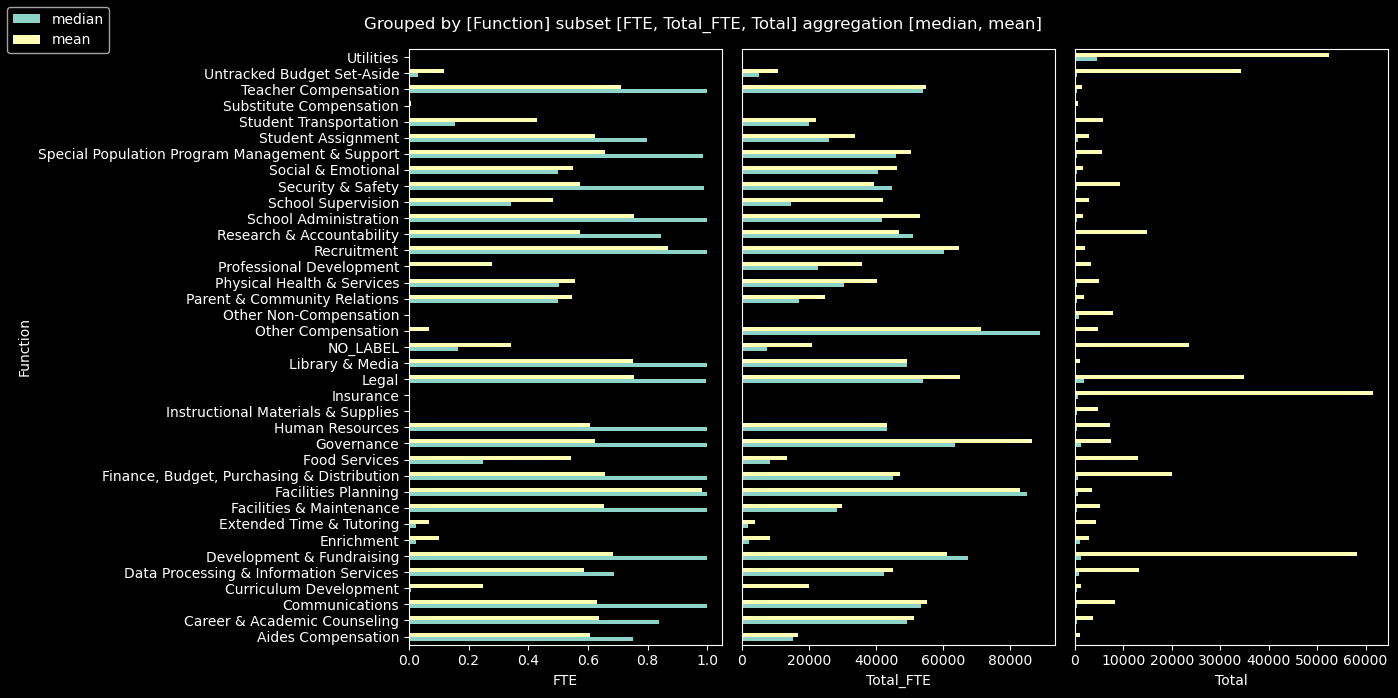

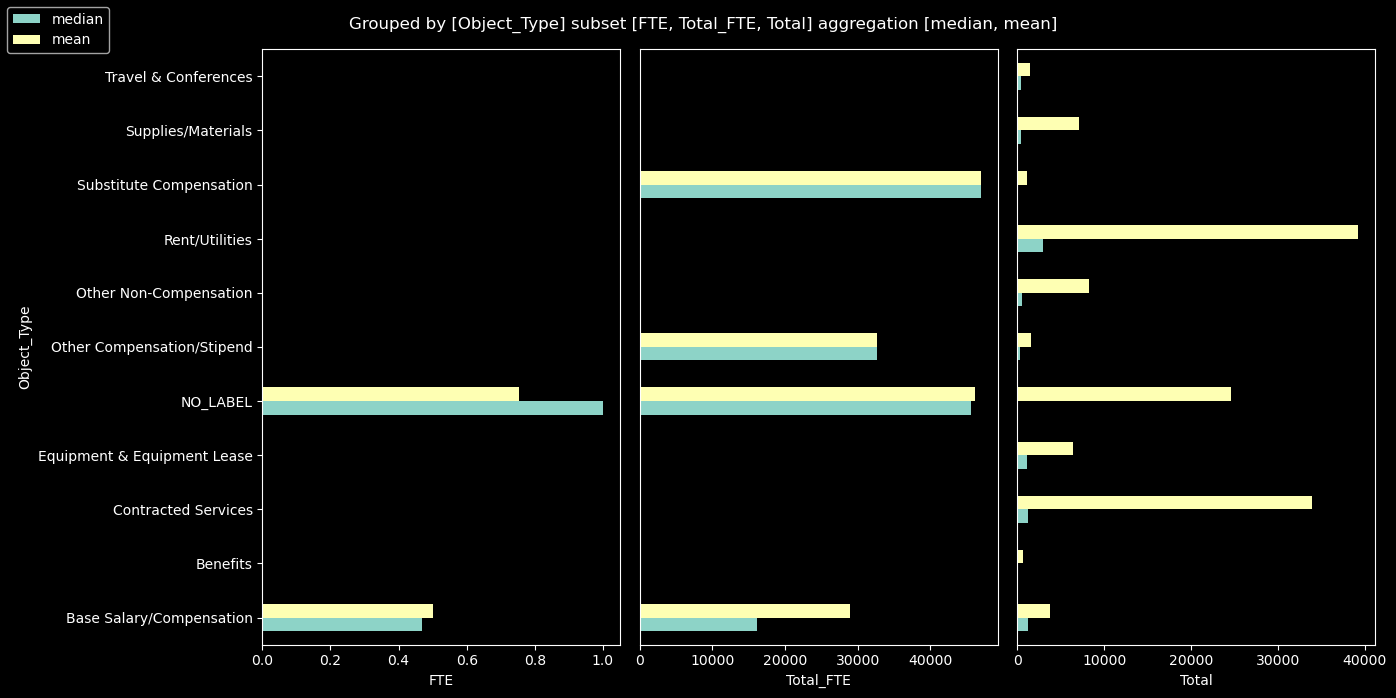

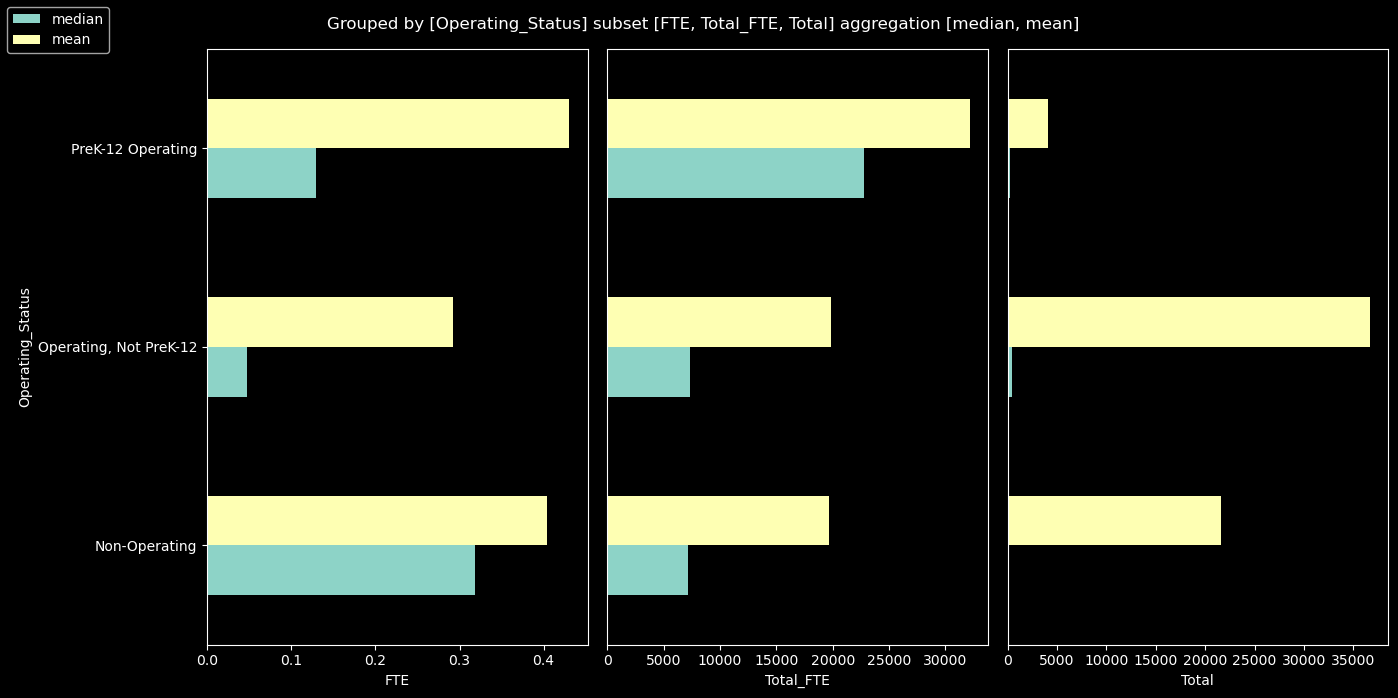

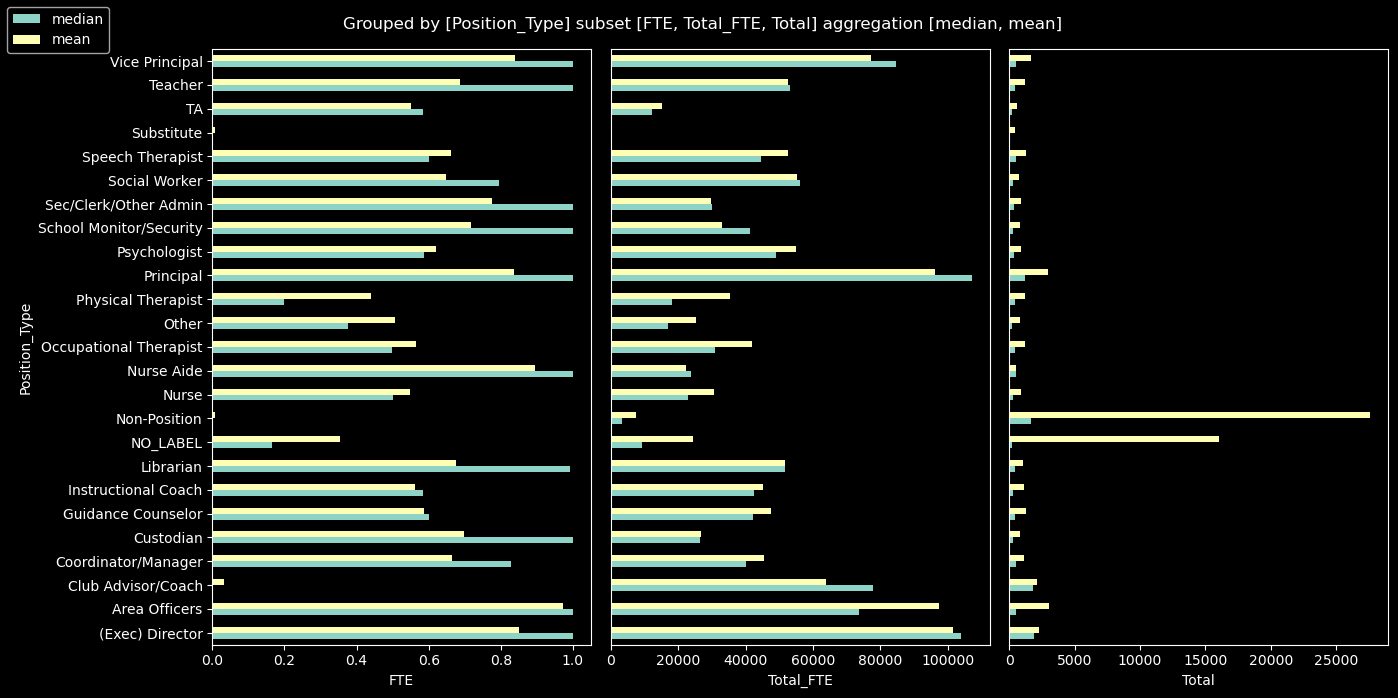

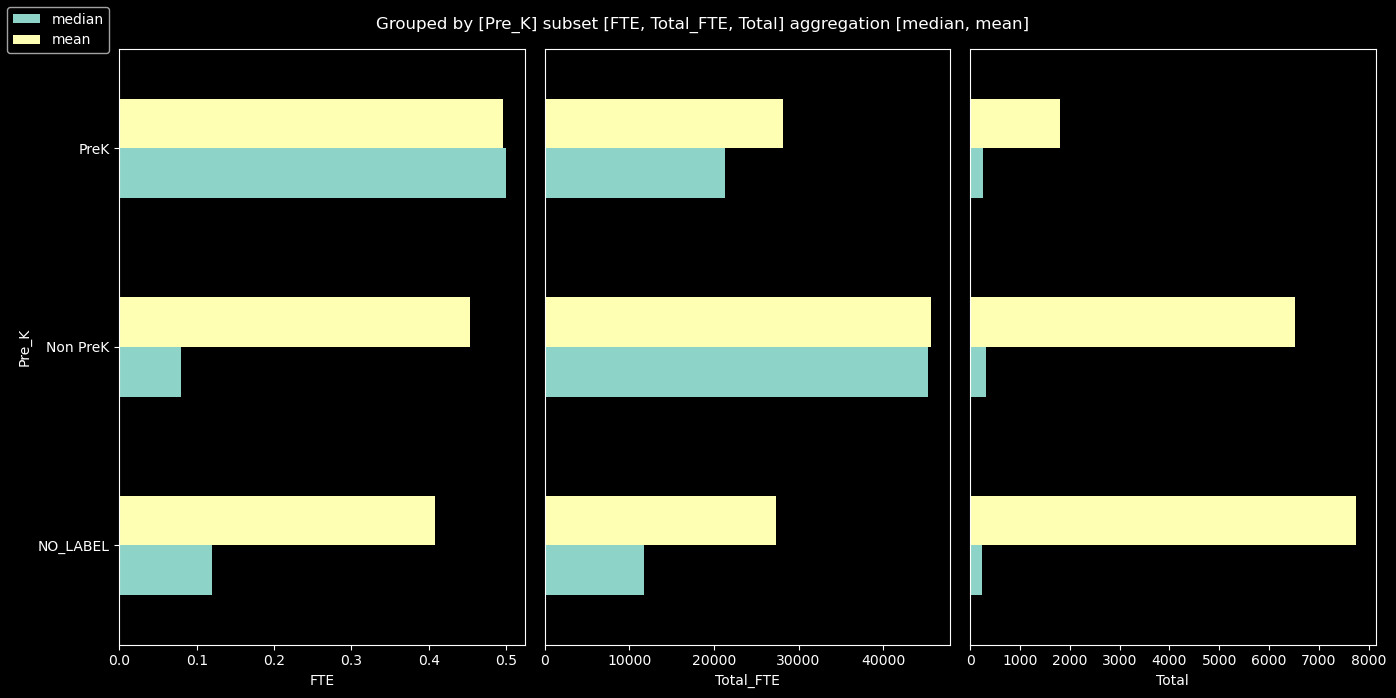

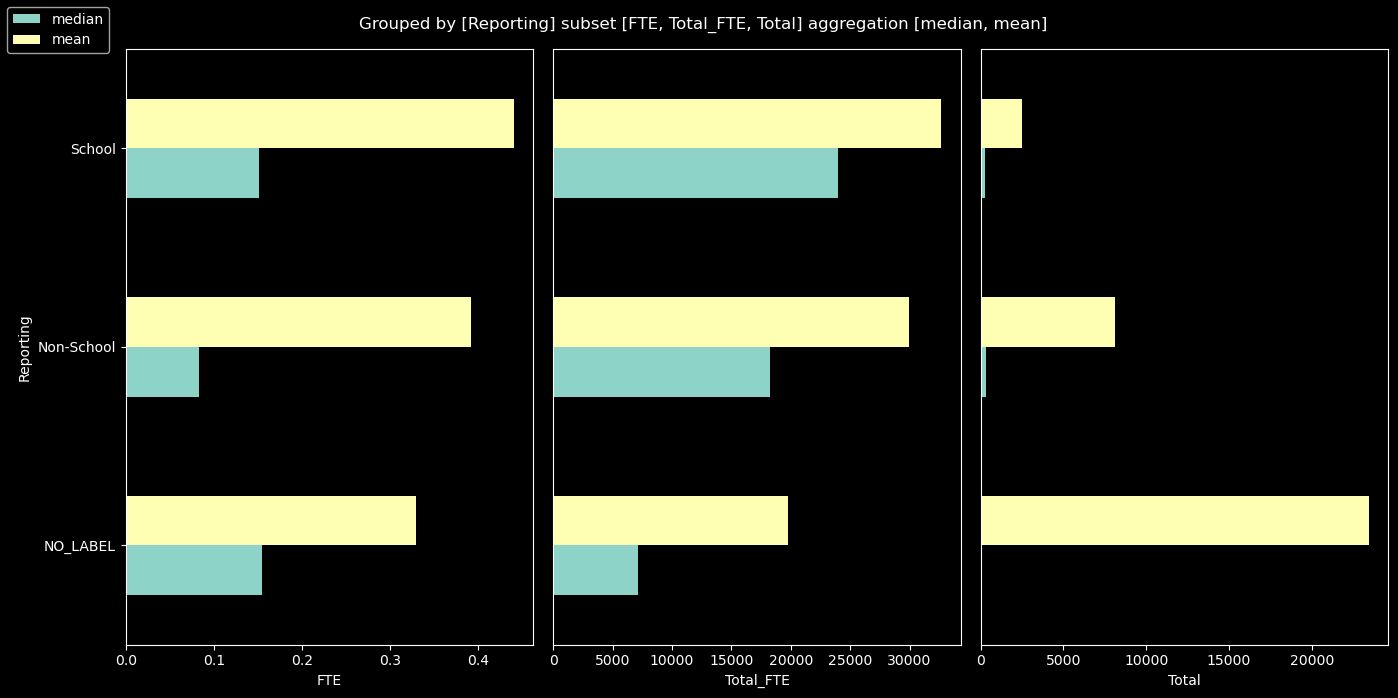

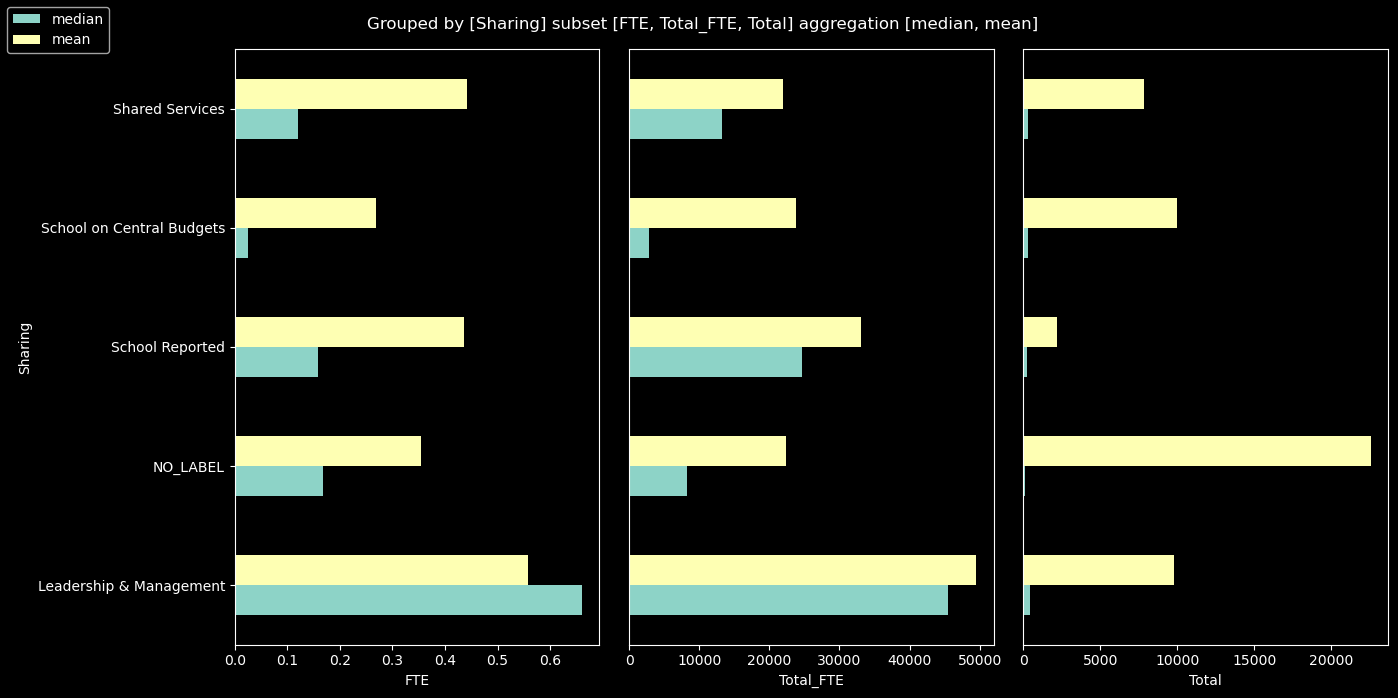

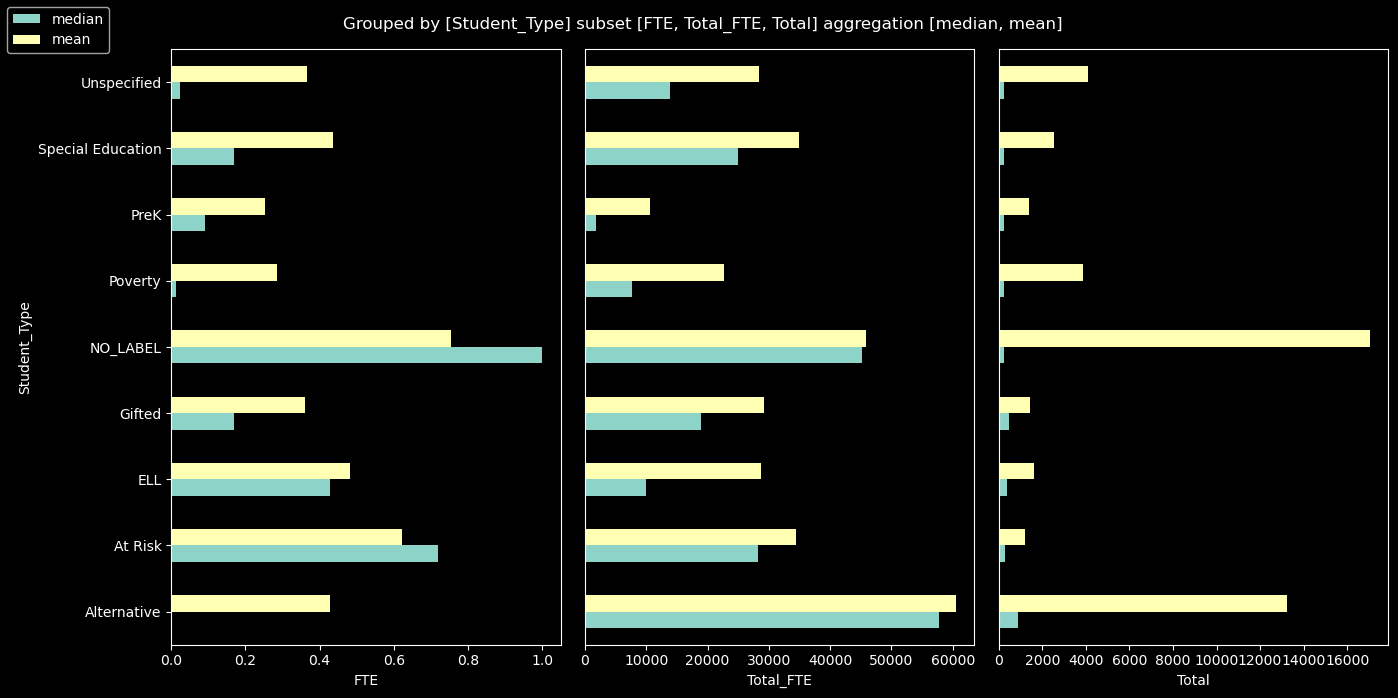

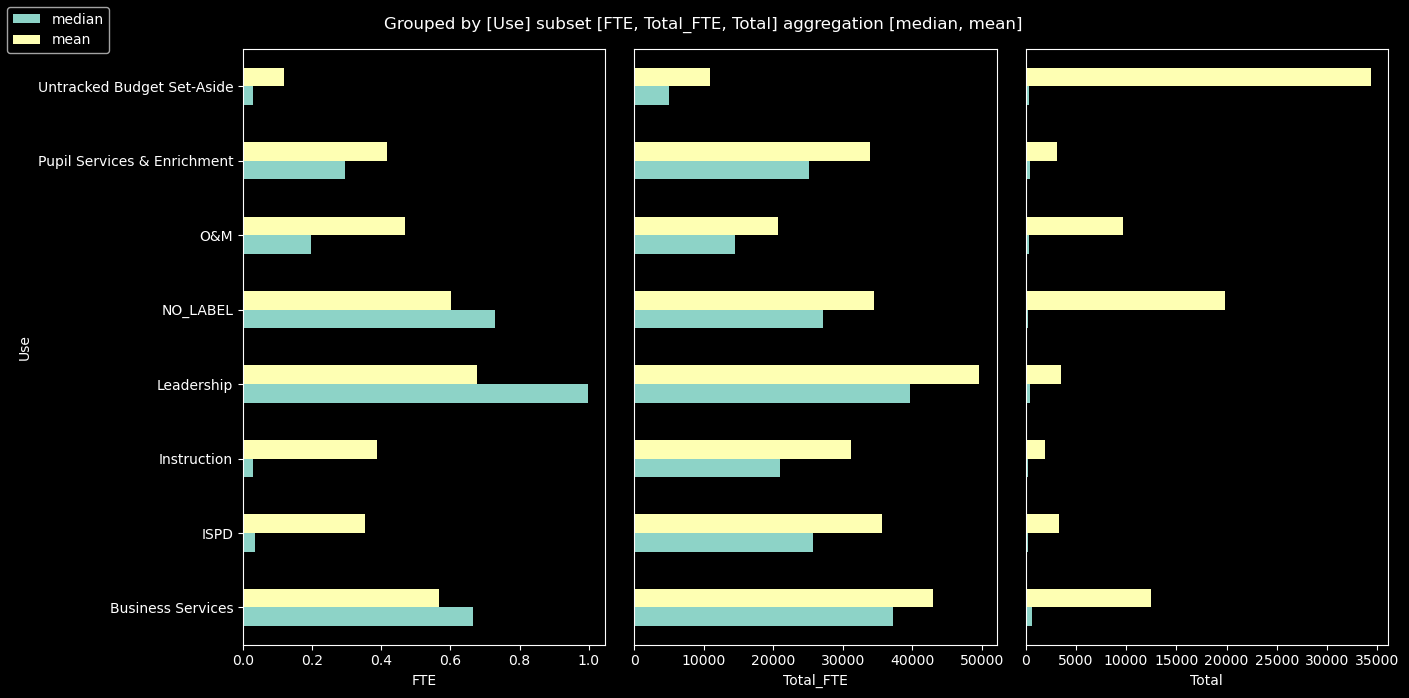

In [52]:
for label in LABELS:
    plot_grouped_statistics(df, cols=['FTE', 'Total_FTE', 'Total'], by=label)

## Free text form variables

The `cross_value_counts()` function includes missing counts.

In [53]:
def cross_value_counts(df):
    #cvc = df.replace('(\s+|[^\w+])',' ',regex=True)#.apply(lambda x: x.str.strip())
    # cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.upper())
    cvc = df.replace('[^\w]+',' ',regex=True).apply(lambda x: x.str.strip().str.lower())
    cvc = cvc.apply(lambda x: x.value_counts(dropna=False)).fillna(0).apply(pd.to_numeric, downcast='unsigned')
    cvc.index.name = 'text'
    cvc.columns.name = 'columns'
    cvc.index = cvc.index.fillna('NaN')
    # sorting value counts by rows than by columns
    decreasing_row_index = cvc.sum(axis=1).sort_values(ascending=False).index
    decreasing_col_index = cvc.loc[cvc.index!='NaN'].sum(axis=0).sort_values(ascending=False).index

    return cvc.loc[decreasing_row_index, decreasing_col_index]

def cross_value_counts_summary(df):
    percent_with_nan = lambda x: x.sum() / (df.shape[0] * df.shape[1]) * 100
    cvc = cross_value_counts(df).replace(0, np.nan)
    cvcs = cvc.agg(['sum', 'count', percent_with_nan], axis='columns')
    cvcs.index.name = 'text'
    cvcs.columns=['Ocurrences', 'Columns', '% w/NaN']

    saved = cvcs.loc['NaN','Ocurrences']
    cvcs.loc['NaN','Ocurrences'] = np.nan
    cvcs['% wo/NaN'] = (cvcs.Ocurrences / cvcs.Ocurrences.sum() * 100)#.fillna(0)
    cvcs['Cumulated % wo/NaN'] = cvcs['% wo/NaN'].cumsum()
    cvcs.loc['NaN','Ocurrences'] = saved
    cvcs['words'] = cvcs.index.str.split().map(len).tolist()
    cvcs.loc['NaN','words'] = np.nan

    cvcs = cvcs.apply(pd.to_numeric, downcast='float')
    cvcs = cvcs.apply(pd.to_numeric, downcast='unsigned')

    return cvcs

### Text counts by feature

In [54]:
cvc = cross_value_counts(df[TEXT_FEATURES].set_axis(df[TEXT_FEATURES].columns.str.replace('_', ' '), axis=1))
cvc.shape

(7604, 14)

In [55]:
cvc.head(50).style.bar()

### Text count totals by feature

In [56]:
cvc.iloc[1:].sum().to_frame('Totals').style.bar()

### Text features frequency summary

In [57]:
cvcs = cross_value_counts_summary(df[TEXT_FEATURES])
cvcs.head(18).style.bar()

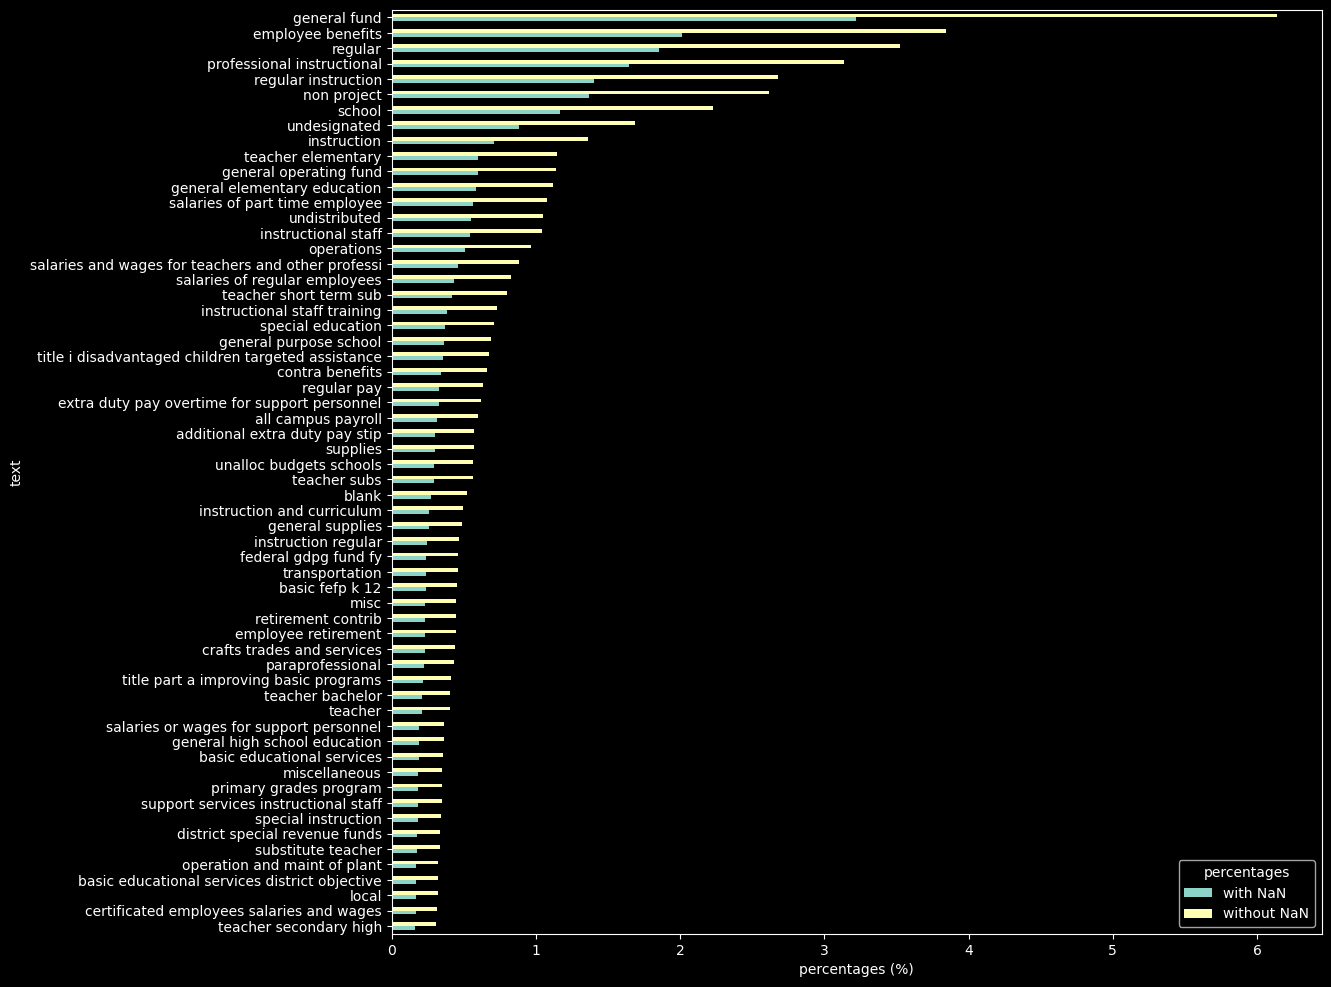

In [58]:
wwo_nan_cvcs = pd.concat({'with NaN': cvcs['% w/NaN'].drop('NaN'),
                          'without NaN': cvcs['% wo/NaN'].drop('NaN')},
                         axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
wwo_nan_cvcs.index.name='text'
wwo_nan_cvcs.columns.name='percentages'
wwo_nan_cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(12, 12))
plt.xlabel('percentages (%)')
plt.show()

## Categorical variables

### Unique classes per label

In [59]:
num_unique_labels = df[LABELS].nunique()
num_unique_labels

Function            37
Object_Type         11
Operating_Status     3
Position_Type       25
Pre_K                3
Reporting            3
Sharing              5
Student_Type         9
Use                  8
dtype: int64

Total number of unique labels

In [60]:
num_unique_labels.sum()

104

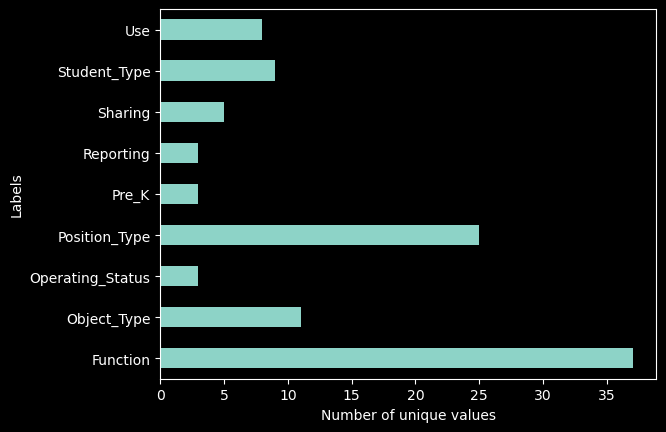

In [61]:
num_unique_labels.plot(kind='barh')
plt.xlabel('Number of unique values')
plt.ylabel('Labels')
plt.show()

### Encoding labels as categories to optimize memory and performance

In [62]:
#Converting label columns to category type
print('Memory before encoding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after encoding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before encoding: 85.9 MB (555.1 MB deep)
Memory after encoding : 61.9 MB (319.5 MB deep)


### Observations per groups of labels

In [63]:
df[LABELS].value_counts().to_frame('value_counts')

value_counts
Function                   Object_Type                Operating_Status  Position_Type         Pre_K    Reporting  Sharing                 Student_Type Use                                      
NO_LABEL                   NO_LABEL                   Non-Operating     NO_LABEL              NO_LABEL NO_LABEL   NO_LABEL                NO_LABEL     NO_LABEL                            48034
Teacher Compensation       Benefits                   PreK-12 Operating Teacher               NO_LABEL School     School Reported         Unspecified  Instruction                         22169
Substitute Compensation    Base Salary/Compensation   PreK-12 Operating Substitute            NO_LABEL School     School Reported         Unspecified  Instruction                         16130
                           Benefits                   PreK-12 Operating Substitute            NO_LABEL School     School Reported         Unspecified  Instruction                         14110
Teacher Compensation       Base Salary/Compensation   PreK-12 Operating Teacher               NO_LABEL School     School Reported         Unspecified  Instruction                         13551
...                                                                                                                                                                                          ...
Physical Health & Services Other Compensation/Stipend PreK-12 Operating Non-Position          Non PreK Non-School Leadership & Management Unspecified  Pupil Services & Enrichment             1
                                                                        Instructional Coach   NO_LABEL Non-School Shared Services         Unspecified  Pupil Services & Enrichment             1
                                                                        Coordinator/Manager   NO_LABEL Non-School Shared Services         Unspecified  Pupil Services & Enrichment             1
                           NO_LABEL                   PreK-12 Operating Sec/Clerk/Other Admin NO_LABEL Non-School NO_LABEL                NO_LABEL     NO_LABEL                                1
Utilities                  Supplies/Materials         PreK-12 Operating Non-Position          NO_LABEL Non-School Shared Services         Unspecified  O&M                                     1

[5489 rows x 1 columns]

### Converting labels in dummy variables

Double underscore conventioned by the competition

In [64]:
# Converting labels in dummy variables
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
dummy_labels

Function__Aides Compensation  Function__Career & Academic Counseling  \
134338                             0                                       0   
206341                             0                                       0   
326408                             0                                       0   
364634                             0                                       0   
47683                              0                                       0   
...                              ...                                     ...   
109283                             0                                       0   
102430                             0                                       0   
413949                             0                                       0   
433672                             0                                       0   
415831                             0                                       0   

        Function__Communications  Function__Curriculum Development  \
134338                         0                                 0   
206341                         0                                 0   
326408                         0                                 0   
364634                         0                                 0   
47683                          0                                 0   
...                          ...                               ...   
109283                         0                                 0   
102430                         0                                 0   
413949                         0                                 0   
433672                         0                                 0   
415831                         0                                 0   

        Function__Data Processing & Information Services  \
134338                                                 0   
206341                                                 0   
326408                                                 0   
364634                                                 0   
47683                                                  0   
...                                                  ...   
109283                                                 0   
102430                                                 0   
413949                                                 0   
433672                                                 0   
415831                                                 0   

        Function__Development & Fundraising  Function__Enrichment  \
134338                                    0                     0   
206341                                    0                     0   
326408                                    0                     0   
364634                                    0                     0   
47683                                     0                     0   
...                                     ...                   ...   
109283                                    0                     0   
102430                                    0                     0   
413949                                    0                     0   
433672                                    0                     0   
415831                                    0                     0   

        Function__Extended Time & Tutoring  \
134338                                   0   
206341                                   0   
326408                                   0   
364634                                   0   
47683                                    0   
...                                    ...   
109283                                   0   
102430                                   0   
413949                                   0   
433672                                   0   
415831                                   0   

        Function__Facilities & Maintenance  Function__Facilities Planning  \
134338                    

### Class count

In [65]:
dummy_labels.sum().sort_values(ascending=False)

Operating_Status__PreK-12 Operating    343578
Pre_K__NO_LABEL                        306425
Reporting__School                      257258
Sharing__School Reported               254433
Student_Type__Unspecified              223026
                                        ...  
Function__Legal                           117
Position_Type__Nurse Aide                  95
Function__Development & Fundraising        93
Function__Insurance                        57
Function__Facilities Planning              29
Length: 104, dtype: int64

### Class proportions

In [66]:
dummy_labels.mean().sort_values(ascending=False)

Operating_Status__PreK-12 Operating    0.858351
Pre_K__NO_LABEL                        0.765532
Reporting__School                      0.642700
Sharing__School Reported               0.635642
Student_Type__Unspecified              0.557179
                                         ...   
Function__Legal                        0.000292
Position_Type__Nurse Aide              0.000237
Function__Development & Fundraising    0.000232
Function__Insurance                    0.000142
Function__Facilities Planning          0.000072
Length: 104, dtype: float64

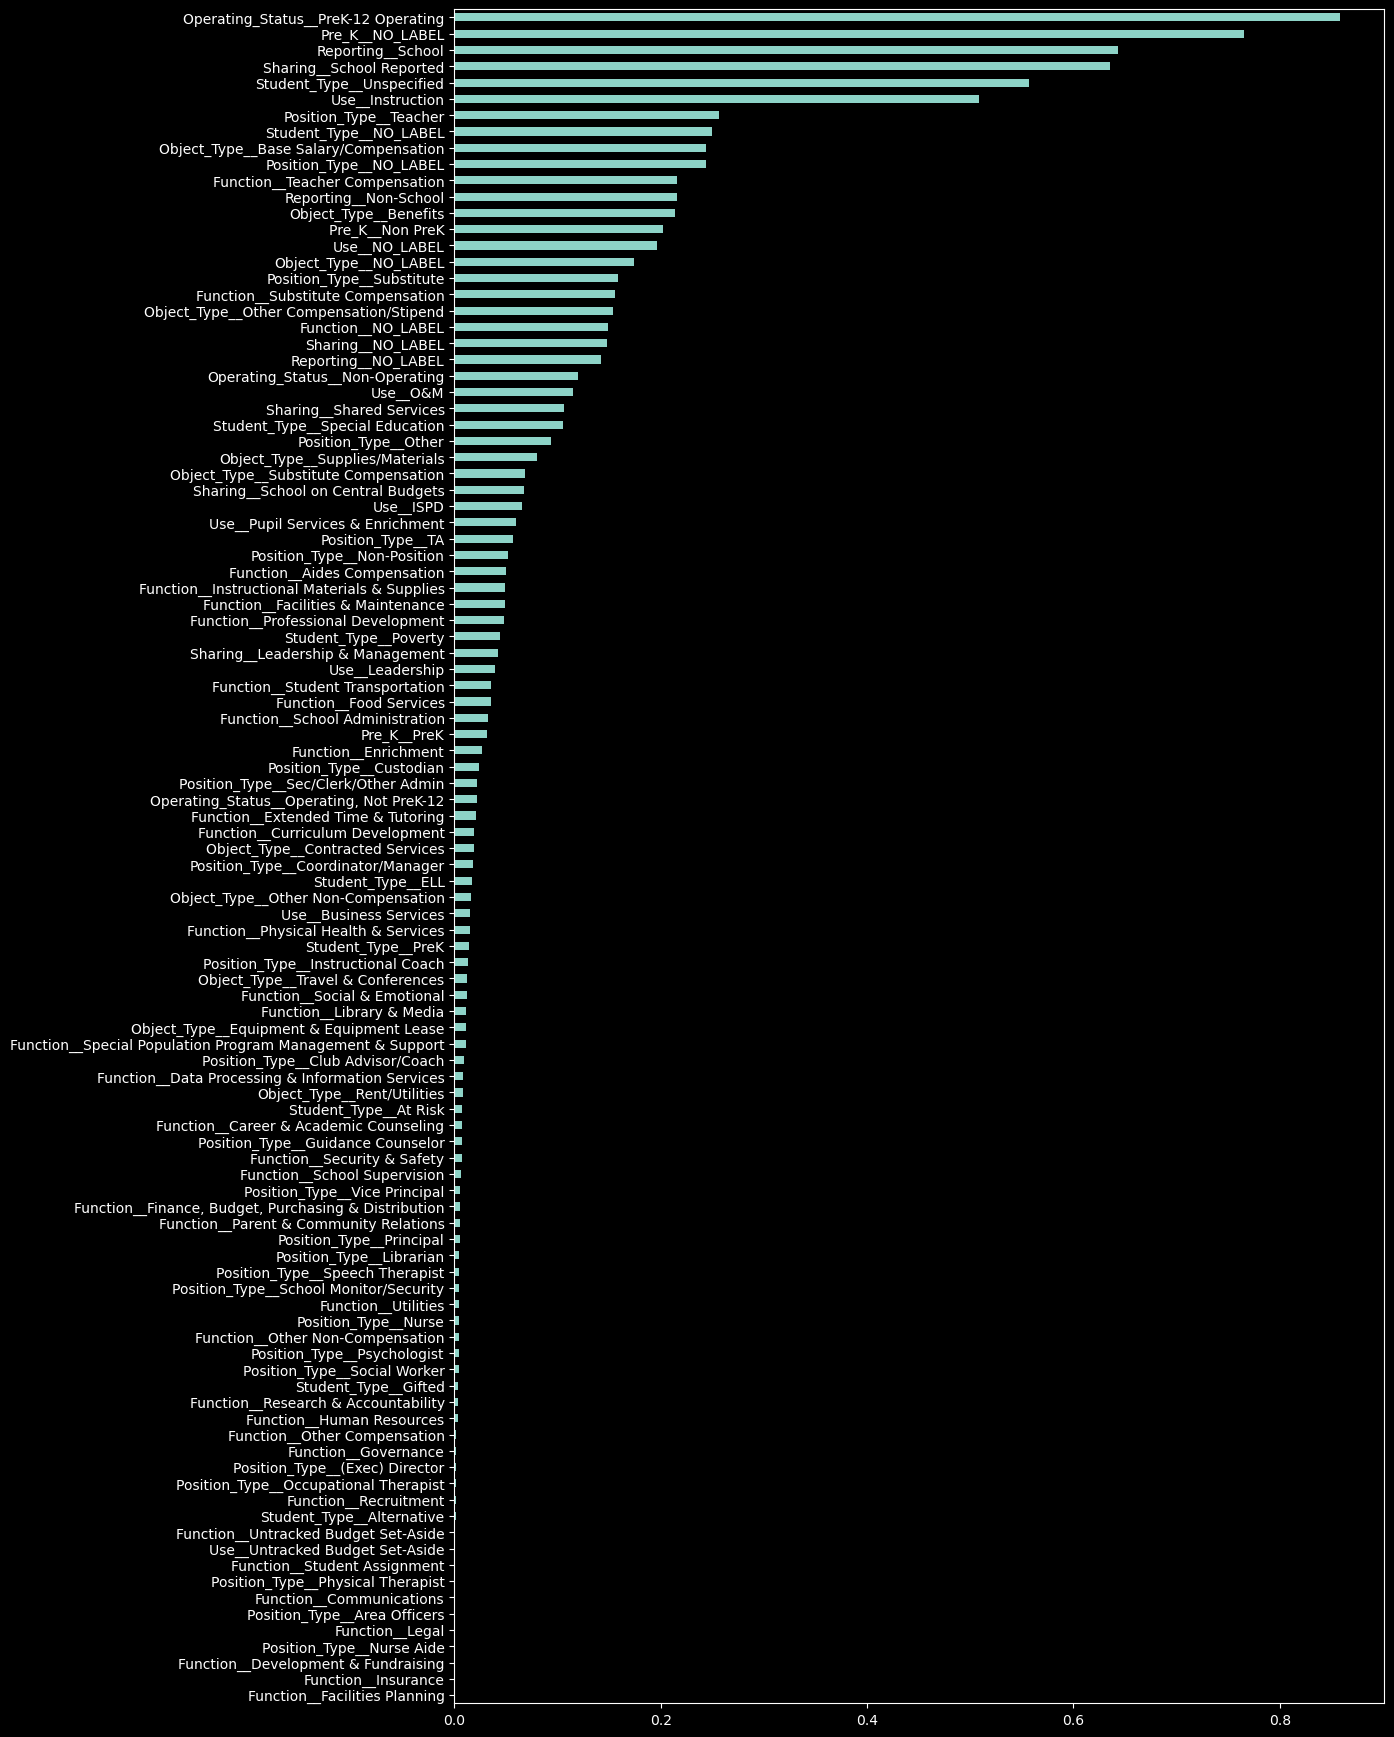

In [67]:
dummy_labels.mean().sort_values().plot(kind='barh', figsize=(12,22)); plt.show()

# Exploring holdout data

This holdout dataset has no labels due to the secrecy of the competition

In [68]:
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entries, 180042 to 249087
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Object_Description      48330 non-null  object 
 1   Program_Description     44811 non-null  object 
 2   SubFund_Description     16111 non-null  object 
 3   Job_Title_Description   32317 non-null  object 
 4   Facility_or_Department  2839 non-null   object 
 5   Sub_Object_Description  33612 non-null  object 
 6   Location_Description    37316 non-null  object 
 7   FTE                     19605 non-null  float64
 8   Function_Description    46866 non-null  object 
 9   Position_Extra          13813 non-null  object 
 10  Text_4                  2814 non-null   object 
 11  Total                   49404 non-null  float64
 12  Text_2                  4641 non-null   object 
 13  Text_3                  5784 non-null   object 
 14  Fund_Description        39586 no

## Missing data

Overall count and proportion of missing holdout features compared to missing training features:

In [69]:
missing = df[FEATURES].isnull()
missing_holdout = holdout.isnull()
pd.DataFrame({'dataset':  ['training', 'holdout'],
              'missing':    [missing.sum().sum(), missing_holdout.sum().sum()],
              'proportion': [missing.mean().mean(),
                             missing_holdout.mean().mean()]}).set_index('dataset')

missing  proportion
dataset                      
training  3342386    0.491187
holdout    387797    0.484127

**The proportion of missing data in the holdout set is bigger.**

Comparing missing feature heatmaps.  The columns of both datasets are ordered by the features of the training set with less missing data first. The idea is to compare some sort of missing proportion clusters.

In [70]:
# freq_col_order = missing.sum().sort_values().index.to_list()
# plt.figure(figsize=(25,6))
# sns.heatmap(~missing.loc[: , # missing.sum(axis=1).sort_values().index.to_list(),
#     freq_col_order].sort_values(freq_col_order), cbar=False, xticklabels=False)
# plt.title('Training set')
# plt.figure(figsize=(25,6))
# sns.heatmap(~missing_holdout.loc[:, # missing_holdout.sum(axis=1).sort_values().index.to_list(),
#     freq_col_order].sort_values(freq_col_order), cbar=False)
# plt.title('Holdout set')
# plt.show()

Comparing the heatmaps became suspect that the holdout dataset is not just a fair random sample because it's missing data pattern differs a lot from the training dataset.

Some missing value areas are proportionally bigger in the holdout set, which is confirmed by the missing ratio which differs a lot.

In [71]:
(holdout.isnull().mean() / df[FEATURES].isnull().mean()).sort_values(ascending=False)

SubFund_Description       2.905789
Text_1                    2.568016
Position_Extra            2.138819
Job_Title_Description     1.319515
Text_3                    1.216083
Text_2                    1.163785
Text_4                    1.090171
Facility_or_Department    1.090035
FTE                       0.888124
Object_Description        0.559388
Function_Description      0.440222
Program_Description       0.439246
Location_Description      0.427852
Sub_Object_Description    0.426141
Fund_Description          0.424391
Total                     0.053830
Total_FTE                      NaN
dtype: float64

## Disambiguation of Total when having FTE

In [72]:
holdout[['FTE', 'Total', 'Total_FTE']] = disambiguate(holdout, 'FTE', 'Total')
holdout[NUMERIC_FEATURES]

FTE        Total     Total_FTE
180042   NaN  3999.909912           NaN
28872    NaN  3447.320312           NaN
186915  1.00          NaN  52738.781250
412396  1.00          NaN  69729.265625
427740  1.00          NaN  29492.833984
...      ...          ...           ...
169063  0.49          NaN   1542.839966
433255  0.50          NaN   9943.969727
232204  1.00          NaN  14674.360352
171685  0.50          NaN  11006.139648
249087  0.50          NaN  14434.349609

[50064 rows x 3 columns]

In [73]:
numeric_statistics(holdout)

count           mean           std           min           25%  \
FTE        19605       1.349004  8.468634e+01 -1.917398e-07      0.500000   
Total      31697   19603.748047  7.870683e+05 -2.370180e+06     96.249283   
Total_FTE  17707  107644.968750  8.668858e+06 -3.614359e-01  26257.117188   

                    50%           75%           max  missing  miss_ratio  \
FTE            1.000000      1.000000  1.185725e+04    30459    0.608401   
Total        708.997131   3000.120117  1.117399e+08    18367    0.366870   
Total_FTE  45797.152344  55692.675781  1.153578e+09    32357    0.646313   

                    sum         range    skewness      kurtosis           iqr  \
FTE        2.644722e+04  1.185725e+04  139.979126  19597.732422      0.500000   
Total      6.213800e+08  1.141100e+08  110.119133  14010.268555   2903.870834   
Total_FTE  1.906070e+09  1.153578e+09  133.064590  17706.457031  29435.558594   

             lo_outlier    hi_outlier  
FTE           -0.250000      1.750000  
Total      -4259.556969   7355.926369  
Total_FTE -17896.220703  99846.013672

## `FTE` univariate analysis

In [74]:
holdout.FTE.describe()

count    1.960500e+04
mean     1.349004e+00
std      8.468634e+01
min     -1.917398e-07
25%      5.000000e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.185725e+04
Name: FTE, dtype: float64

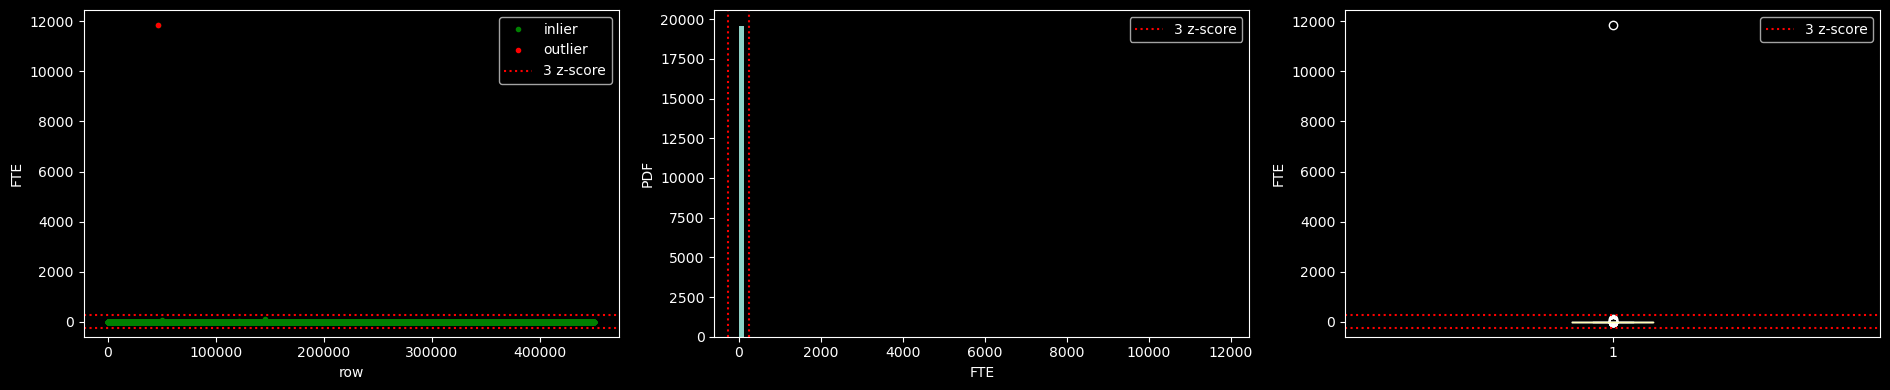

Upper outliers: 1
Lower outliers: 0


In [75]:
density_plots(holdout.FTE, bins=100)
zscores = zscore(holdout.FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has only one `FTE` outlier with a value never seen so high in the whole training set: near `11857.24`, while the max `FTE` in training set is `46.8`.

This specific outlier has no textual data.

In [76]:
holdout[holdout.FTE == holdout.FTE.max()].transpose()

46063
Object_Description               NaN
Program_Description              NaN
SubFund_Description              NaN
Job_Title_Description            NaN
Facility_or_Department           NaN
Sub_Object_Description           NaN
Location_Description             NaN
FTE                     11857.245117
Function_Description             NaN
Position_Extra                   NaN
Text_4                           NaN
Total                            NaN
Text_2                           NaN
Text_3                           NaN
Fund_Description                 NaN
Text_1                           NaN
Total_FTE               1153578240.0

Searching for holdout observations with no textual data: There are 116 other holdout observations without textual data.

In [77]:
holdout.loc[holdout[TEXT_FEATURES].isnull().all(axis=1), NUMERIC_FEATURES].sort_values(['FTE', 'Total'], ascending=False)

FTE         Total     Total_FTE
46063   11857.245117           NaN  1.153578e+09
45795            NaN  36483.488281           NaN
156857           NaN  29225.599609           NaN
47394            NaN  15943.169922           NaN
312570           NaN  15160.440430           NaN
...              ...           ...           ...
354927           NaN     41.990002           NaN
103425           NaN     18.910000           NaN
71261            NaN           NaN           NaN
230738           NaN           NaN           NaN
297095           NaN           NaN           NaN

[116 rows x 3 columns]

Searching for training observations with no textual data: There are 1874 other training observations without textual data.

In [78]:
df.loc[df[TEXT_FEATURES].isnull().all(axis=1), LABELS+NUMERIC_FEATURES].sort_values(['FTE', 'Total'], ascending=False)

Function              Object_Type   Operating_Status  \
108731  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
205873  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
105293  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
36835   Substitute Compensation  Substitute Compensation  PreK-12 Operating   
350915  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
...                         ...                      ...                ...   
314104  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
276236  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
196727  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
266312  Substitute Compensation  Substitute Compensation  PreK-12 Operating   
50702   Substitute Compensation  Substitute Compensation  PreK-12 Operating   

       Position_Type     Pre_K   Reporting   Sharing Student_Type  \
108731    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
205873    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
105293    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
36835     Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
350915    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
...              ...       ...         ...       ...          ...   
314104    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
276236    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
196727    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
266312    Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   
50702     Substitute  NO_LABEL  Non-School  NO_LABEL     NO_LABEL   

                Use  FTE         Total  Total_FTE  
108731  Instruction  NaN  48876.089844        NaN  
205873  Instruction  NaN  37433.308594        NaN  
105293  Instruction  NaN  35955.320312        NaN  
36835   Instruction  NaN  32213.990234        NaN  
350915  Instruction  NaN  31920.970703        NaN  
...             ...  ...           ...        ...  
314104  Instruction  NaN           NaN        NaN  
276236  Instruction  NaN           NaN        NaN  
196727  Instruction  NaN           NaN        NaN  
266312  Instruction  NaN           NaN        NaN  
50702   Instruction  NaN           NaN        NaN  

[1874 rows x 12 columns]

Stats of training observations with no textual, data grouped by labels

In [79]:
df.loc[df[TEXT_FEATURES].isnull().all(axis=1), LABELS+NUMERIC_FEATURES].sort_values(['FTE', 'Total'], ascending=False)\
    .groupby(LABELS, observed=True).agg(['count', 'sum'])#.to_frame('count')

FTE  \
                                                                                                                                             count   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                 
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction     0   
                                                                                         School     School Reported NO_LABEL     Instruction     0   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL        0   
                        NO_LABEL                Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL        NO_LABEL     NO_LABEL        0   

                                                                                                                                                   \
                                                                                                                                              sum   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction  0.0   
                                                                                         School     School Reported NO_LABEL     Instruction  0.0   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL     0.0   
                        NO_LABEL                Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL        NO_LABEL     NO_LABEL     0.0   

                                                                                                                                             Total  \
                                                                                                                                             count   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                 
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction  1727   
                                                                                         School     School Reported NO_LABEL     Instruction   131   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL        1   
                        NO_LABEL                Non-Operating     NO_LABEL      NO_LABEL NO_LABEL   NO_LABEL        NO_LABEL     NO_LABEL        0   

                                                                                                                                                            \
                                                                                                                                                       sum   
Function                Object_Type             Operating_Status  Position_Type Pre_K    Reporting  Sharing         Student_Type Use                         
Substitute Compensation Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     Instruction  9.048462e+06   
                                                                                         School     School Reported NO_LABEL     Instruction  3.762721e+05   
NO_LABEL                Substitute Compensation PreK-12 Operating Substitute    NO_LABEL Non-School NO_LABEL        NO_LABEL     NO_LABEL     2.107600e+02   
                        NO_LABEL                N

## `Total_FTE` univariate analysis

In [80]:
holdout.Total_FTE.describe()

count    1.770700e+04
mean     1.076450e+05
std      8.668858e+06
min     -3.614359e-01
25%      2.625712e+04
50%      4.579715e+04
75%      5.569268e+04
max      1.153578e+09
Name: Total_FTE, dtype: float64

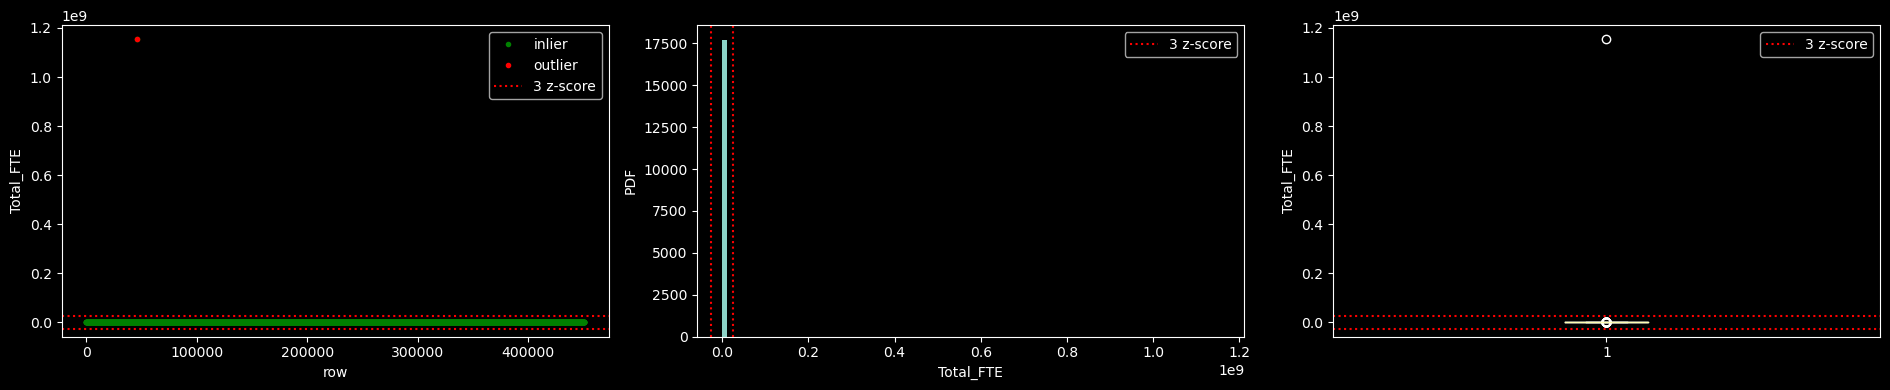

Upper outliers: 1
Lower outliers: 0


In [81]:
density_plots(holdout.Total_FTE, bins=100)
zscores = zscore(holdout.Total_FTE, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

The highest outlier has not textual data.

In [82]:
holdout[(zscores < -3) | (zscores > 3)].transpose()

46063
Object_Description               NaN
Program_Description              NaN
SubFund_Description              NaN
Job_Title_Description            NaN
Facility_or_Department           NaN
Sub_Object_Description           NaN
Location_Description             NaN
FTE                     11857.245117
Function_Description             NaN
Position_Extra                   NaN
Text_4                           NaN
Total                            NaN
Text_2                           NaN
Text_3                           NaN
Fund_Description                 NaN
Text_1                           NaN
Total_FTE               1153578240.0

## `Total` univariate analysis

In [83]:
holdout.Total.describe()

count    3.169700e+04
mean     1.960375e+04
std      7.870683e+05
min     -2.370180e+06
25%      9.624928e+01
50%      7.089971e+02
75%      3.000120e+03
max      1.117399e+08
Name: Total, dtype: float64

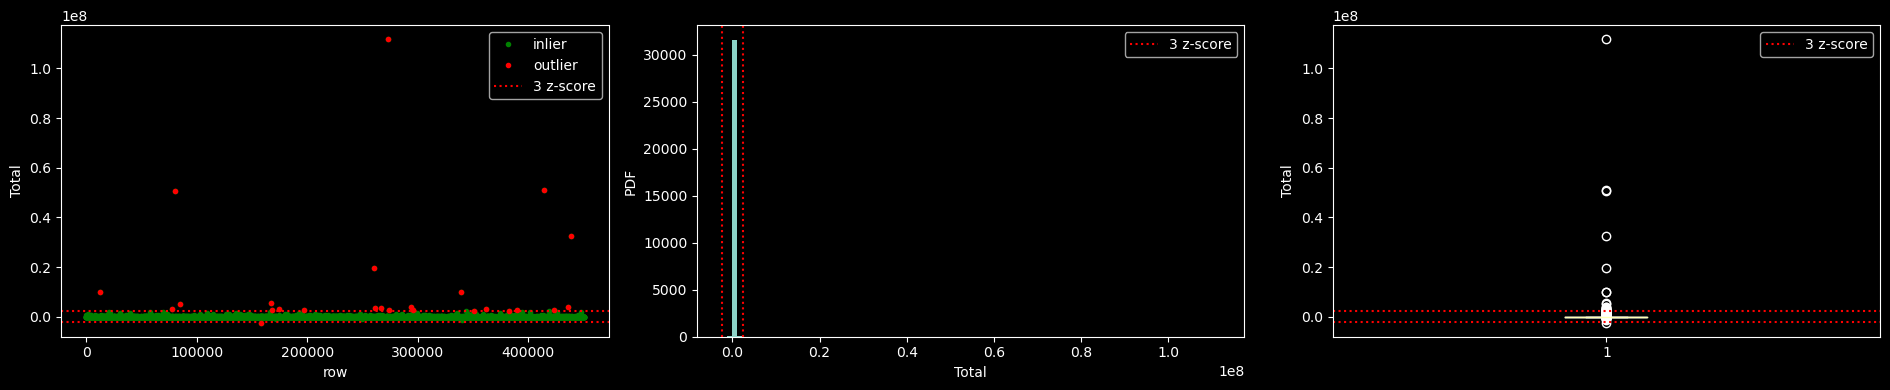

Upper outliers: 24
Lower outliers: 1


In [84]:
density_plots(holdout.Total, bins=100)
zscores = zscore(holdout.Total, nan_policy='omit')
print('Upper outliers:', sum(zscores > 3))
print('Lower outliers:', sum(zscores < -3))

It's suspicious how the holdout set has a huge Total outlier close to 1.2 billion while the max in training is 129 million and in fact, this `Total` outlier is the same as the `FTE` outlier.

The highest outlier has not textual data.

In [85]:
holdout[(zscores < -3) | (zscores > 3)].transpose()

293744  \
Object_Description            Tax Appraisal & Collection   
Program_Description                        Undistributed   
SubFund_Description                                  NaN   
Job_Title_Description                                NaN   
Facility_or_Department                               NaN   
Sub_Object_Description           Property Appraisal Srvc   
Location_Description                     Tax Collections   
FTE                                                  NaN   
Function_Description    Other Intergovernmental Charges    
Position_Extra                                       NaN   
Text_4                                               NaN   
Total                                         3962545.75   
Text_2                                               NaN   
Text_3                                               NaN   
Fund_Description                            General Fund   
Text_1                                               NaN   
Total_FTE                                            NaN   

                                            273904                  197099  \
Object_Description           Professional Salaries  Gasoline & Other Fuels   
Program_Description     Basic Educational Services           Undistributed   
SubFund_Description                            NaN                     NaN   
Job_Title_Description                          NaN                     NaN   
Facility_or_Department                         NaN                     NaN   
Sub_Object_Description                     General                 General   
Location_Description       Unallocated Cost Budget   Transportation Office   
FTE                                            NaN                     NaN   
Function_Description                   Instruction  Student Transportation   
Position_Extra                                 NaN                     NaN   
Text_4                                         NaN                     NaN   
Total                                   2625389.75               2500000.0   
Text_2                                         NaN                     NaN   
Text_3                                         NaN                     NaN   
Fund_Description                      General Fund            General Fund   
Text_1                                         NaN                     NaN   
Total_FTE                                      NaN                     NaN   

                                                                                        78059   \
Object_Description                                                             Federal Revenue   
Program_Description                                                                        NaN   
SubFund_Description                                                                        NaN   
Job_Title_Description                                                                      NaN   
Facility_or_Department                                                                     NaN   
Sub_Object_Description                                                                 General   
Location_Description                                                                       NaN   
FTE                                                                                        NaN   
Function_Description                                                             Miscellaneous   
Position_Extra                                                                             NaN   
Text_4                                                                                     NaN   
Total                                                                                3225847.0   
Text_2                                                                                     NaN   
Text_3                                                                                     NaN   
Fund_Description        ESEA, Title II, Part A - Teacher and Principal Training and Recruiting

## Regression and correlation by imputation strategy

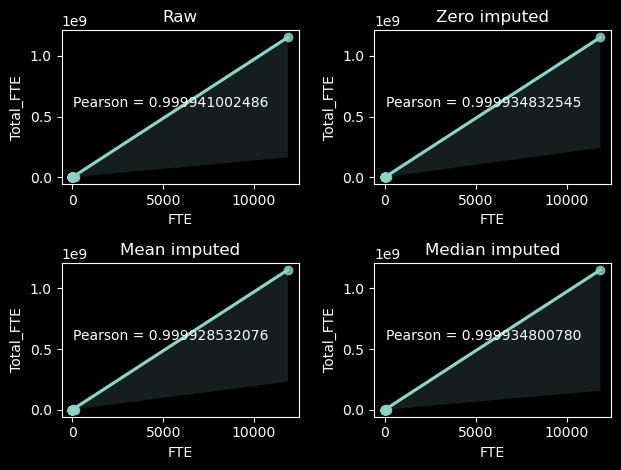

In [86]:
plot_regression_correlation_imputation(holdout, 'FTE', 'Total_FTE')

## Free text form variables

### Text counts by feature

In [87]:
holdout_cvc = cross_value_counts(holdout[TEXT_FEATURES].set_axis(holdout[TEXT_FEATURES].columns.str.replace('_', ' '), axis=1))
holdout_cvc.shape

(5042, 14)

In [88]:
holdout_cvc.head(50).style.bar()

### Text count totals by feature

In [89]:
holdout_cvc.iloc[1:].sum().to_frame('Totals').style.bar()

### Text features frequency summary

In [90]:
holdout_cvcs = cross_value_counts_summary(holdout[TEXT_FEATURES])
holdout_cvcs.head(18).style.bar()

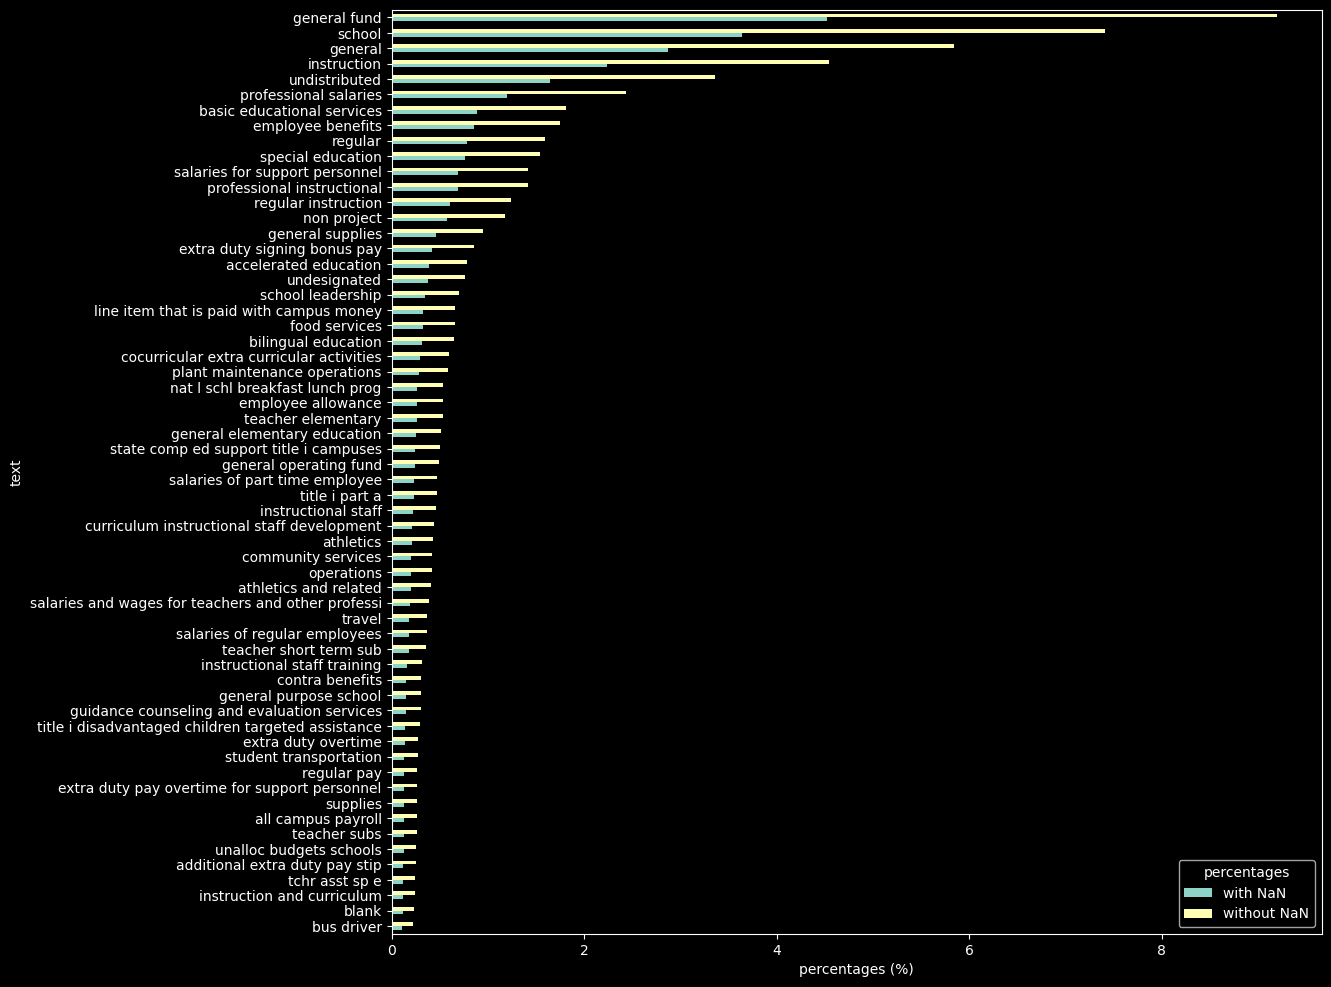

In [91]:
wwo_nan_holdout_cvcs = pd.concat({'with NaN': holdout_cvcs['% w/NaN'].drop('NaN'),
                          'without NaN': holdout_cvcs['% wo/NaN'].drop('NaN')},
                         axis=1, sort=True).sort_values(['with NaN', 'without NaN'])
wwo_nan_holdout_cvcs.index.name='text'
wwo_nan_holdout_cvcs.columns.name='percentages'
wwo_nan_holdout_cvcs.tail(60).plot(kind='barh', stacked=False, figsize=(12, 12))
plt.xlabel('percentages (%)')
plt.show()

### Comparing training-holdout text frequency summaries

percentages                    train   holdout
text                                          
general fund                6.139676  9.202308
employee benefits           3.843661  1.747439
regular                     3.527663  1.592595
professional instructional  3.133313  1.413349
regular instruction         2.679211  1.236135
...                              ...       ...
wan manager                 0.000000  0.000291
web manager                 0.000000  0.000291
welder                      0.000000  0.000291
youth commission            0.000000  0.000291
NaN                         0.000000  0.000000

[8955 rows x 2 columns]

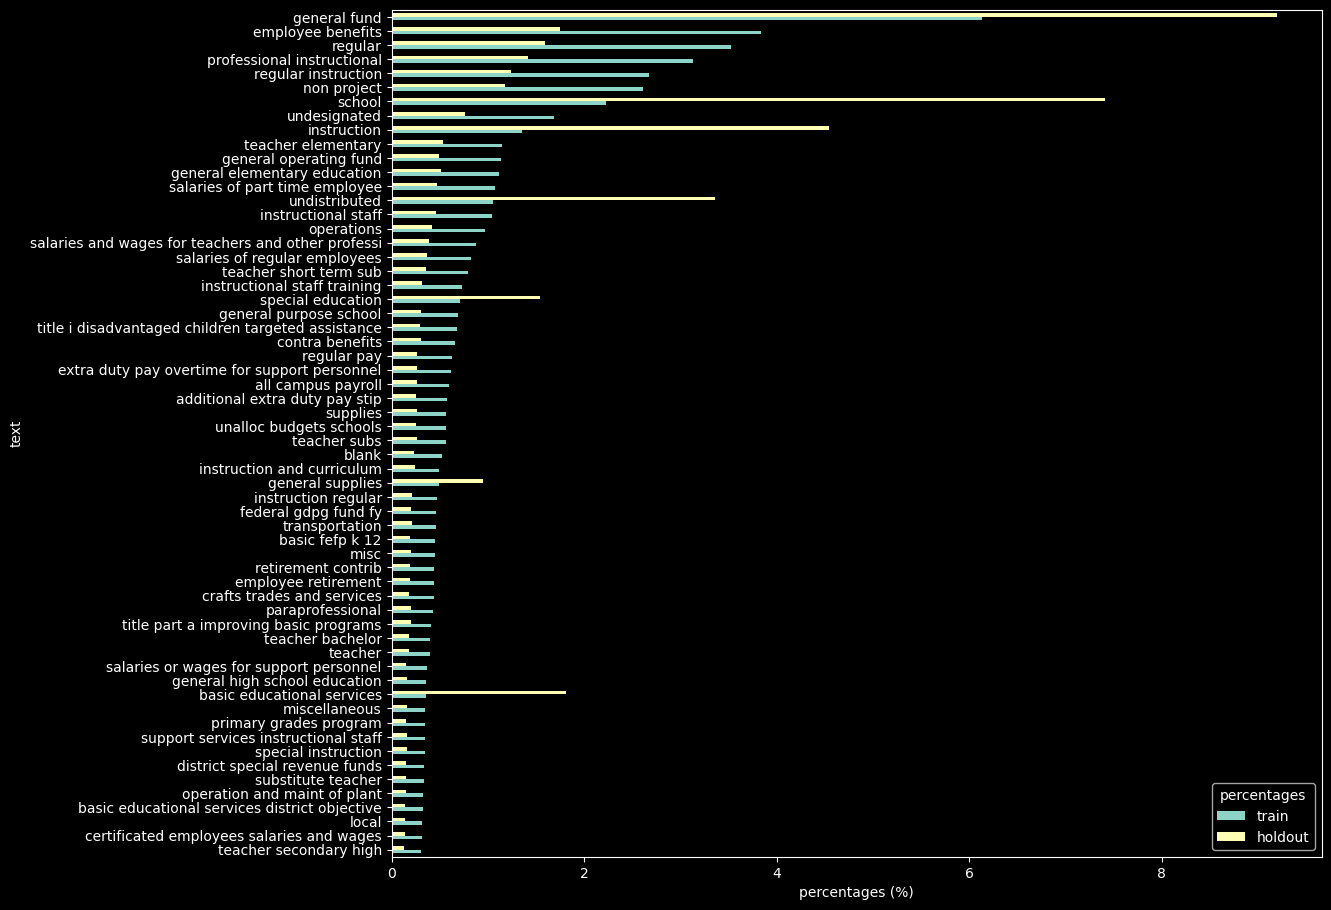

In [92]:
compare_cvcs = pd.concat({'train': cvcs['% wo/NaN'], 'holdout': holdout_cvcs['% wo/NaN']},
                         axis=1, sort=True).fillna(0).sort_values(['train', 'holdout'], ascending=False)
compare_cvcs.index.name='text'
compare_cvcs.columns.name='percentages'
display(compare_cvcs)
compare_cvcs.sort_values(['train', 'holdout']).tail(60).plot(kind='barh', stacked=False, figsize=(12, 11))
plt.xlabel('percentages (%)')
plt.show()

# Imputation strategy

There won't be text feature imputation.

For numeric features:
* Generate binary indicators for missing `FTE`, `Total_FTE` and `Total`
* Impute zero on `FTE`, `Total`, and `Total_FTE`

In [93]:
from sklearn.impute import SimpleImputer
SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)\
    .fit_transform(df[NUMERIC_FEATURES])

array([[1.000000e+00, 0.000000e+00, 5.047181e+04, 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [0.000000e+00, 3.477860e+03, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [1.000000e+00, 0.000000e+00, 6.223713e+04, 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [1.000000e+00, 0.000000e+00, 4.902290e+03, 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [0.000000e+00, 4.020290e+03, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 4.653000e+01, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]], dtype=float32)

# The log loss

Log loss for binary classification
$$logloss = - \frac{1}{N}\sum^N_{i=1}{(y_i log(p_i) + (1-y_i)log(1-p_i))}$$

>Better to be less confident than confident and wrong

In [94]:
from metrics.log_loss import log_loss

Wrong and confident       : 34.538776394910684
Wrong and not confident   : 0.916290731874155
Correct and not confident : 0.5108256237659907
Correct and confident     : 9.992007221626415e-16


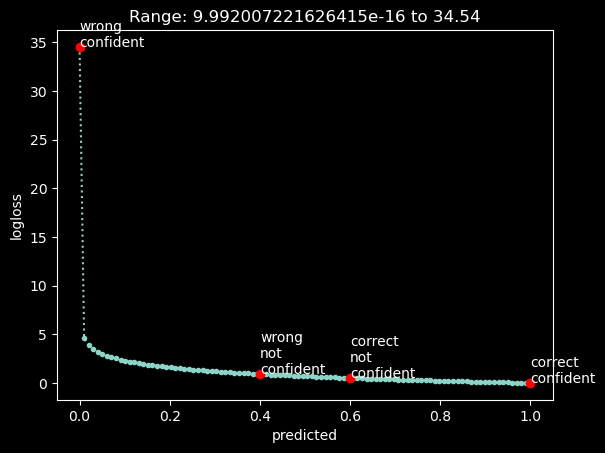

In [95]:
print('Wrong and confident       :', log_loss(actual =1, predicted=0))
print('Wrong and not confident   :', log_loss(actual=1, predicted=0.4))
print('Correct and not confident :', log_loss(actual=1, predicted=0.6))
print('Correct and confident     :', log_loss(actual=1, predicted=1))
predicts = np.linspace(0,1,100)
lloss = [log_loss(1,x) for x in predicts]
plt.plot(predicts, lloss, marker='.', linestyle='dotted')
points = [0, 0.4, 0.6, 1]
classes = ['wrong\nconfident', 'wrong\nnot\nconfident', 'correct\nnot\nconfident', 'correct\nconfident']
for i, x in enumerate(points):
    y=log_loss(actual=1, predicted=x)
    plt.plot(x, y, 'ro')
    plt.text(x, y, s=classes[i])
plt.title('Range: {0:} to {1:.2f}'.format(lloss[-1], lloss[0]))
plt.xlabel('predicted')
plt.ylabel('logloss')
plt.show()

 Log loss penalizes highly confident wrong answers much more than any other type. This is a good metric to use in this model and required by the competition.

# The multi-class multi-label log loss

In [96]:
from metrics.log_loss import multi_multi_log_loss
from dummies import get_dummies_indices
cci = get_dummies_indices(df[LABELS])

# Simple model: only numeric features

In [97]:
from model_selection.multilabel import multilabel_train_test_split

## Setting up a train-test split

* Selecting just numeric features: `df[NUMERIC_FEATURES]`

* Selecting labels as binary variables for multi-label targets: `dummy_labels`

In [98]:
# reproducibility reloads data to avoid things done during EDA
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
NUMERIC_FEATURES=['FTE', 'Total']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
#

In [99]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NUMERIC_FEATURES], dummy_labels, size=0.2, min_count=0, seed=1)

## Allways pre-process after splitting

In [100]:
X_train = disambiguate(X_train, 'FTE', 'Total')
X_test = disambiguate(X_test, 'FTE', 'Total')

# Logistic regression requires non missing values and also added missing indicators
X_train = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True).fit_transform(X_train)
X_test = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True).fit_transform(X_test)

# Scaling
from sklearn.preprocessing import maxabs_scale
X_train = maxabs_scale(X_train)
X_test = maxabs_scale(X_test)
X_train

array([[2.1929825e-02, 0.0000000e+00, 8.6885527e-02, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.6814650e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [2.1929825e-02, 0.0000000e+00, 1.0713913e-01, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [2.1929825e-02, 0.0000000e+00, 8.4391283e-03, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 3.0996838e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 3.5875095e-07, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)

## Training a model

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [102]:
clf = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

In [103]:
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(), n_jobs=-1)

## Model metrics

In [104]:
print("Training Accuracy:", clf.score(X_train, y_train))
y_pred = clf.predict_proba(X_train)
print("Training Logloss:", multi_multi_log_loss(y_train, y_pred, class_column_indices=cci))
print("Testing Accuracy:", clf.score(X_test, y_test))
y_pred = clf.predict_proba(X_test)
print("Testing Logloss:", multi_multi_log_loss(y_test, y_pred, class_column_indices=cci))
y_pred = clf.predict(X_test)
print("Testing Classification Report:\n", classification_report(y_test, y_pred))

Training Accuracy: 0.027221739917931934
Training Logloss: 1.2748620561833368
Testing Accuracy: 0.02218474798575979
Testing Logloss: 1.2808897397155974
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3892
           1       0.00      0.00      0.00       604
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00      1472
           4       0.00      0.00      0.00       678
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2152
           7       0.00      0.00      0.00      1652
           8       0.00      0.00      0.00      3969
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       470
          11       1.00      0.00      0.00      2831
          12       0.00      0.00      0.00       141
          13       0.00      0.00      0.00       240
      

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


```
Last executed at 2022-09-14 01:56:26 in 3.01s

Training Accuracy: 0.027221739917931934
Training Logloss: 1.2748620561833368
Testing Accuracy: 0.02218474798575979
Testing Logloss: 1.2808897397155974
```

## Use your model to predict values on holdout data

Pre-process holdout

In [105]:
holdout = pd.read_csv('/data/drivendata/TestData.csv', index_col=0, low_memory=False)

In [106]:
# Numeric disambiguation
holdout_numeric = disambiguate(holdout, 'FTE', 'Total')
# Logistic regression requires non missing values and also added missing indicators
holdout_numeric = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True).fit_transform(holdout_numeric)
# Scaling
holdout_numeric = maxabs_scale(holdout_numeric)
holdout_numeric

array([[0.0000000e+00, 3.5796627e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 3.0851304e-05, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [8.4336622e-05, 0.0000000e+00, 4.5717559e-05, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [8.4336622e-05, 0.0000000e+00, 1.2720732e-05, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [4.2168311e-05, 0.0000000e+00, 9.5408695e-06, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [4.2168311e-05, 0.0000000e+00, 1.2512675e-05, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [107]:
predictions = clf.predict_proba(holdout_numeric)
predictions

array([[0.03632471, 0.00649866, 0.00087765, ..., 0.11504914, 0.06258739,
        0.00115572],
       [0.03632476, 0.00649866, 0.00087765, ..., 0.11504902, 0.06258752,
        0.00115572],
       [0.13860212, 0.00699581, 0.00054554, ..., 0.13610827, 0.05655503,
        0.00020433],
       ...,
       [0.13866467, 0.00699446, 0.00054551, ..., 0.13615245, 0.05655164,
        0.00020434],
       [0.13853908, 0.00699462, 0.0005455 , ..., 0.13604259, 0.05656619,
        0.00020434],
       [0.13853345, 0.00699475, 0.0005455 , ..., 0.13603861, 0.0565665 ,
        0.00020434]])

## Writing out your results to a zip for submission
At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

In [108]:
prediction_df = pd.DataFrame(columns=dummy_labels.columns,
                             index=holdout.index,
                             data=predictions)
prediction_df.head()

Function__Aides Compensation  Function__Career & Academic Counseling  \
180042                      0.036325                                0.006499   
28872                       0.036325                                0.006499   
186915                      0.138602                                0.006996   
412396                      0.138574                                0.006996   
427740                      0.138640                                0.006995   

        Function__Communications  Function__Curriculum Development  \
180042                  0.000878                          0.024395   
28872                   0.000878                          0.024395   
186915                  0.000546                          0.012380   
412396                  0.000546                          0.012379   
427740                  0.000546                          0.012381   

        Function__Data Processing & Information Services  \
180042                                          0.008791   
28872                                           0.008791   
186915                                          0.006125   
412396                                          0.006125   
427740                                          0.006124   

        Function__Development & Fundraising  Function__Enrichment  \
180042                             0.000186              0.032003   
28872                              0.000186              0.032003   
186915                             0.000412              0.023921   
412396                             0.000412              0.023917   
427740                             0.000412              0.023927   

        Function__Extended Time & Tutoring  \
180042                            0.024285   
28872                             0.024285   
186915                            0.033061   
412396                            0.033053   
427740                            0.033072   

        Function__Facilities & Maintenance  Function__Facilities Planning  \
180042                            0.052381                       0.000097   
28872                             0.052382                       0.000097   
186915                            0.049067                       0.000061   
412396                            0.049065                       0.000061   
427740                            0.049069                       0.000061   

        ...  Student_Type__Special Education  Student_Type__Unspecified  \
180042  ...                         0.087015                   0.519512   
28872   ...                         0.087015                   0.519514   
186915  ...                         0.120572                   0.688287   
412396  ...                         0.120574                   0.688278   
427740  ...                         0.120570                   0.688299   

        Use__Business Services  Use__ISPD  Use__Instruction  Use__Leadership  \
180042                0.016225   0.073580          0.441252         0.038965   
28872                 0.016225   0.073580          0.441255         0.038965   
186915                0.012081   0.042037          0.673542         0.029871   
412396                0.012082   0.042038          0.673547         0.029874   
427740                0.012080   0.042035          0.673535         0.029867   

        Use__NO_LABEL  Use__O&M  Use__Pupil Services & Enrichment  \
180042       0.250339  0.115049                          0.062587   
28872        0.250336  0.115049                          0.062588   
186915       0.071377  0.136108                          0.056555   
412396       0.071377  0.136089                          0.056557   
427740       0.071376  0.136135                          0.056553   

        Use__Untracked Budget Set-Aside  
180042                         0.001156  
28872                          0.001156  
186915                         0.000204  
412396                         0.000204  
427740                         0.

In [109]:
prediction_df.to_csv('/data/drivendata/predictions/2022/0.8-scaled-engineered-numeric-features-logistic-regression-C1.csv')

Last executed at 2022-09-09 10:47:29 in 3.11s:

Engineered 6 numeric features, zero imputed, with maxabs scaler: 1.2951

# Improving your model: NLP

## Combining text features for tokenization

Here all text features are concatenated in each row.

Each row becomes a single document.

**But which order concatenate the text features?**

The order of the text feature concatenation makes difference in resulting n-grams where n > 1 (bigrams, etc.).

When using sentence tokenization rather than word tokenization, the text feature concatenation should use "." rather than " ".

Concatenating using some semantics from: https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/#features_list

In [110]:
TEXT_FEATURES = ['Object_Description', 'Sub_Object_Description', 'Function_Description', 'Fund_Description',
                 'SubFund_Description', 'Program_Description', 'Location_Description', 'Facility_or_Department',
                 'Job_Title_Description', 'Position_Extra', 'Text_1', 'Text_2', 'Text_3', 'Text_4']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES

In [111]:
from preprocessing.combine_text_columns import combine_text_columns

In [112]:
text_vector = combine_text_columns(df[TEXT_FEATURES], to_drop=LABELS, sep=' ')
text_vector

134338                                                                                                                                                                                                                                                                                         General Fund KINDERGARTEN Teacher-Elementary  KINDERGARTEN 
206341                                                                                                                                                                                               CONTRACTOR SERVICES RGN  GOB BUILDING FUND BUILDING IMPROVEMENT SERVICES (blank) UNDESIGNATED BUILDING IMPROVEMENT SERVICES BOND EXPENDITURES Regular
326408                                                                                                                                                                                                                               Personal Services - Teachers General Purpose School Instruction - Regular TCH

In [113]:
print(f'Memory size {size(sys.getsizeof(text_vector))}')

Memory size 86.5 MiB


## Bag-of-Words

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from nlp import custom_word_tokenizer, custom_sentence_tokenizer

Unigram statistics:

<400277x3758 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                           : 0.995718043089115
Max term frequency in a document   : 6
Max term frequency in all documents: 331001
Max words in a document            : 53
Mean words per document            : 19.8
Median words per document          : 19.0
Sparse matrix memory usage         : 32.2 MiB
Dense matrix memory equivalence    : 1.4 GiB
Non-zero probabilities:

bin    count  proportion
0    1  5222873    0.810867
1    2   996854    0.154765
2    3   176893    0.027463
3    4    35572    0.005523
4    5     7678    0.001192
5    6     1225    0.000190

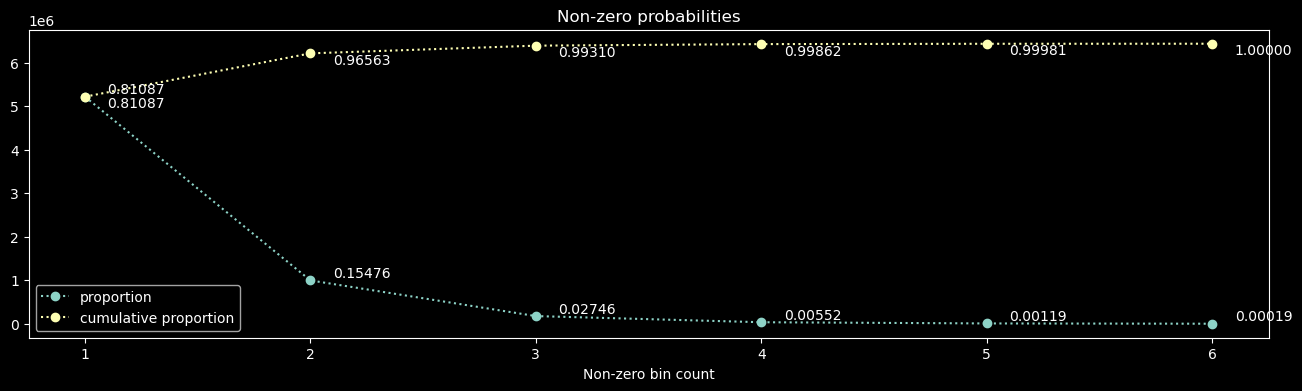

In [115]:
vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', dtype='uint8').fit(text_vector)
tdm = vec.transform(text_vector)
display(tdm)
#display(pd.DataFrame(tdm.toarray(), columns=vec.get_feature_names_out()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max term frequency in a document   : {}'.format(tdm.max()))
print('Max term frequency in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max words in a document            : {}'.format(tdm.sum(axis=1).max()))
print('Mean words per document            : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median words per document          : {}'.format(np.median(np.array(tdm.sum(axis=1)))))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, tdm.max() + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

* **`81%` of the words appear only `1`  time in the rows of the `text_vector`**
* **`99%` of the words appear from `1` to `3` times in the rows of the `text_vector`**

## Tokenizing n-gram ranges

The `CountVectorizer` default `dtype` is `int64`.

As the maximum frequency of any token in a single observation is 6, the 8-bits unsigned integer `uint8` (0 to 255) could be enough to store counts of any ngram range.

As the most frequent n-gram is always the 1-gram, we can assume the max `ngram_range` possible by finding the maximum 1-gram count in row.

In [136]:
max_unigrams = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', dtype='uint8', binary=True).fit_transform(text_vector).sum(axis=1).max().astype(int)
max_unigrams

39

In [122]:
# def func(ngram_range):
#     tracemalloc.start()
#     t=time()
#     tdm = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range = ngram_range, dtype='uint8').fit_transform(text_vector)
#     t=time()-t
#     current, peak = tracemalloc.get_traced_memory()
#     tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
#     msg = 'ngram:{},{} cols:{} maxtf:{} maxtfall:{} nnz:{} sparse:{:.2f}% size:{} cur:{} peak:{} {:.0f}s'
#     msg = msg.format(ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(), tdm.sum(axis=0).max(), tdm.nnz,
#                      (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), size(current), size(peak), t)
#     return msg

# messages = Parallel(n_jobs=-1, timeout=400)(delayed(func)(ngram_range=ngram_range) for ngram_range in [(1,x) for x in range(1, max_unigrams + 1)])
# for message in messages:
#     print(message)

```
Last executed at 2022-09-16 05:53:59 in 7m 12.43s

ngram:1,1 cols:3758 maxtf:6 maxtfall:331001 nnz:6441095 sparse:99.57% size:32.2 MiB cur:32.4 MiB peak:119.4 MiB 13s
ngram:1,2 cols:32011 maxtf:6 maxtfall:331001 nnz:13478633 sparse:99.89% size:65.8 MiB cur:66.0 MiB peak:238.6 MiB 27s
ngram:1,3 cols:86424 maxtf:6 maxtfall:331001 nnz:20372670 sparse:99.94% size:98.7 MiB cur:98.8 MiB peak:357.4 MiB 40s
ngram:1,4 cols:165642 maxtf:6 maxtfall:331001 nnz:26957695 sparse:99.96% size:130.1 MiB cur:130.2 MiB peak:474.2 MiB 51s
ngram:1,5 cols:267225 maxtf:6 maxtfall:331001 nnz:33195723 sparse:99.97% size:159.8 MiB cur:160.0 MiB peak:600.5 MiB 65s
ngram:1,6 cols:390038 maxtf:6 maxtfall:331001 nnz:39080590 sparse:99.97% size:187.9 MiB cur:188.0 MiB peak:731.1 MiB 76s
ngram:1,7 cols:531563 maxtf:6 maxtfall:331001 nnz:44603334 sparse:99.98% size:214.2 MiB cur:214.4 MiB peak:850.7 MiB 88s
ngram:1,8 cols:689377 maxtf:6 maxtfall:331001 nnz:49758294 sparse:99.98% size:238.8 MiB cur:239.0 MiB peak:969.0 MiB 100s
ngram:1,9 cols:860680 maxtf:6 maxtfall:331001 nnz:54533787 sparse:99.98% size:261.6 MiB cur:261.7 MiB peak:1.1 GiB 110s
ngram:1,10 cols:1042527 maxtf:6 maxtfall:331001 nnz:58927381 sparse:99.99% size:282.5 MiB cur:282.7 MiB peak:1.2 GiB 120s
ngram:1,11 cols:1231386 maxtf:6 maxtfall:331001 nnz:62944206 sparse:99.99% size:301.7 MiB cur:301.8 MiB peak:1.3 GiB 128s
ngram:1,12 cols:1422522 maxtf:6 maxtfall:331001 nnz:66594598 sparse:99.99% size:319.1 MiB cur:319.2 MiB peak:1.4 GiB 137s
ngram:1,13 cols:1612185 maxtf:6 maxtfall:331001 nnz:69887378 sparse:99.99% size:334.8 MiB cur:334.9 MiB peak:1.5 GiB 146s
ngram:1,14 cols:1796647 maxtf:6 maxtfall:331001 nnz:72835983 sparse:99.99% size:348.8 MiB cur:349.0 MiB peak:1.6 GiB 154s
ngram:1,15 cols:1972122 maxtf:6 maxtfall:331001 nnz:75464402 sparse:99.99% size:361.4 MiB cur:361.5 MiB peak:1.7 GiB 160s
ngram:1,16 cols:2135623 maxtf:6 maxtfall:331001 nnz:77800329 sparse:99.99% size:372.5 MiB cur:372.7 MiB peak:1.8 GiB 166s
ngram:1,17 cols:2284785 maxtf:6 maxtfall:331001 nnz:79863572 sparse:99.99% size:382.3 MiB cur:465.9 MiB peak:2.0 GiB 179s
ngram:1,18 cols:2418729 maxtf:6 maxtfall:331001 nnz:81675174 sparse:99.99% size:391.0 MiB cur:474.5 MiB peak:2.0 GiB 184s
ngram:1,19 cols:2536972 maxtf:6 maxtfall:331001 nnz:83253084 sparse:99.99% size:398.5 MiB cur:482.1 MiB peak:2.1 GiB 191s
ngram:1,20 cols:2639838 maxtf:6 maxtfall:331001 nnz:84622407 sparse:99.99% size:405.0 MiB cur:488.6 MiB peak:2.1 GiB 191s
ngram:1,21 cols:2728430 maxtf:6 maxtfall:331001 nnz:85807868 sparse:99.99% size:410.7 MiB cur:494.2 MiB peak:2.2 GiB 196s
ngram:1,22 cols:2804263 maxtf:6 maxtfall:331001 nnz:86832217 sparse:99.99% size:415.6 MiB cur:499.1 MiB peak:2.3 GiB 202s
ngram:1,23 cols:2869149 maxtf:6 maxtfall:331001 nnz:87723182 sparse:99.99% size:419.8 MiB cur:503.4 MiB peak:2.3 GiB 203s
ngram:1,24 cols:2924946 maxtf:6 maxtfall:331001 nnz:88499256 sparse:99.99% size:423.5 MiB cur:507.1 MiB peak:2.4 GiB 209s
ngram:1,25 cols:2973322 maxtf:6 maxtfall:331001 nnz:89176352 sparse:99.99% size:426.8 MiB cur:510.3 MiB peak:2.4 GiB 208s
ngram:1,26 cols:3015715 maxtf:6 maxtfall:331001 nnz:89771127 sparse:99.99% size:429.6 MiB cur:513.1 MiB peak:2.4 GiB 209s
ngram:1,27 cols:3053344 maxtf:6 maxtfall:331001 nnz:90294661 sparse:99.99% size:432.1 MiB cur:515.6 MiB peak:2.4 GiB 211s
ngram:1,28 cols:3086975 maxtf:6 maxtfall:331001 nnz:90755924 sparse:99.99% size:434.3 MiB cur:517.8 MiB peak:2.5 GiB 214s
ngram:1,29 cols:3117272 maxtf:6 maxtfall:331001 nnz:91163903 sparse:99.99% size:436.2 MiB cur:519.8 MiB peak:2.5 GiB 213s
ngram:1,30 cols:3144635 maxtf:6 maxtfall:331001 nnz:91523835 sparse:99.99% size:437.9 MiB cur:521.5 MiB peak:2.5 GiB 212s
ngram:1,31 cols:3169278 maxtf:6 maxtfall:331001 nnz:91838556 sparse:99.99% size:439.4 MiB cur:523.0 MiB peak:2.5 GiB 192s
ngram:1,32 cols:3191394 maxtf:6 maxtfall:331001 nnz:92111025 sparse:99.99% size:440.7 MiB cur:524.3 MiB peak:2.5 GiB 192s
ngram:1,33 cols:3211161 maxtf:6 maxtfall:331001 nnz:92344144 sparse:99.99% size:441.9 MiB cur:442.0 MiB peak:2.5 GiB 189s
ngram:1,34 cols:3228702 maxtf:6 maxtfall:331001 nnz:92541068 sparse:99.99% size:442.8 MiB cur:443.0 MiB peak:2.5 GiB 181s
ngram:1,35 cols:3244177 maxtf:6 maxtfall:331001 nnz:92704447 sparse:99.99% size:443.6 MiB cur:443.7 MiB peak:2.5 GiB 171s
ngram:1,36 cols:3257666 maxtf:6 maxtfall:331001 nnz:92838360 sparse:99.99% size:444.2 MiB cur:444.4 MiB peak:2.5 GiB 167s
ngram:1,37 cols:3269245 maxtf:6 maxtfall:331001 nnz:92946328 sparse:99.99% size:444.7 MiB cur:444.9 MiB peak:2.5 GiB 157s
ngram:1,38 cols:3279027 maxtf:6 maxtfall:331001 nnz:93032977 sparse:99.99% size:445.1 MiB cur:445.3 MiB peak:2.5 GiB 141s
ngram:1,39 cols:3287190 maxtf:6 maxtfall:331001 nnz:93100773 sparse:99.99% size:445.5 MiB cur:445.6 MiB peak:2.5 GiB 129s
```

## n-gram range frequency plot

In [118]:
# stop_words = CountVectorizer(stop_words='english').get_stop_words()
# def func(ngram_range = ngram_range):
#     vec = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', ngram_range=ngram_range, dtype='uint8')
#     tdm = vec.fit_transform(text_vector)
#     df = pd.DataFrame({'term': vec.get_feature_names_out(),
#                               'proportion': tdm.mean(axis=0).tolist()[0],
#                               'frequency': tdm.sum(axis=0).tolist()[0],
#                               # whether the term contains a stop word
#                               'stop_word': [True if any([True if word in stop_words else False for word in str.split(words)]) else False for words in vec.get_feature_names_out()]
#                              }).sort_values(['frequency','term'], ascending=(False, True)).head(100)
#     return ngram_range, df

# for ngram_range, df in Parallel(n_jobs=-1)(delayed(func)(ngram_range=ngram_range) for ngram_range in [(1,x) for x in range(1, 5)]):
#     plt.figure(figsize=(15,9))
#     plt.grid()
#     ax = sns.barplot(x='frequency', y='term', data=df, hue='stop_word', dodge=False)
#     patches = ax.patches
#     for i in range(len(patches)):
#         y = patches[i].get_y() + patches[i].get_height()
#         x = patches[i].get_x() + patches[i].get_width()
#         ax.annotate('{:.2f}%'.format(df['proportion'].iloc[i%df.shape[0]]*100), (x, y))#, ha='center')
#     plt.title('n-gram range {} frequency'.format(ngram_range))
#     plt.tight_layout()
#     plt.show()    

## Hashing Trick

* Adding new features (e.g. 3-grams, 4-grams) may cause enormous increase in array size
* Hashing is a way of increasing memory efficiency
* Want to make array of features as small as possible: dimensionality Reduction
* Hash functions limits possible outputs, fixing array size
* Particularly useful on large datasets: e.g. lots of text data!

In [124]:
from sklearn.feature_extraction.text import HashingVectorizer

The parameters `norm=None`, `alternate_sign=False` and `binary=False` let us drop in the `HashingVectorizer()` as a replacement for `CounterVectorizer()`

[From sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-hashing):
> Since the hash function might cause collisions between (unrelated) features, a signed hash function is used and the sign of the hash value determines the sign of the value stored in the output matrix for a feature. This way, collisions are likely to cancel out rather than accumulate error, and the expected mean of any output feature’s value is zero. This mechanism is enabled by default with `alternate_sign=True` and is particularly useful for small hash table sizes (`n_features < 10000`). For large hash table sizes, it can be disabled, to allow the output to be passed to estimators like `sklearn.naive_bayes.MultinomialNB` or `sklearn.feature_selection.chi2` feature selectors that expect non-negative inputs.

Why is hashing a useful trick?

A hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

A familiar python datatype, a dictionary, makes this mapping concept a bit more explicit. In fact, python dictionaries ARE hash tables!

`{'petro': 354, 'vend': 785, 'fuel': 895, 'and': 780, 'fluids': 354}`

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

The default limit is `n_features=1048576` $(2^{20})$.  The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).  Enforcing a fixed length can speed up calculations drastically, especially on large datasets!

Tokenizing unigram (words)

<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                    : 0.9984653860024352
Max count of a hashed token in a document   : 6
Max count of a hashed token in all documents: 331001
Max unique hashed tokens per document       : 53
Mean unique hashed tokens per document      : 19.8
Median unique tokens per document           : 19.0
Sparse matrix memory usage                  : 32.2 MiB
Dense matrix memory equivalence             : 390.9 GiB
Non-zero probabilities:

bin    count  proportion
0    1  5222873    0.810867
1    2   996854    0.154765
2    3   176893    0.027463
3    4    35572    0.005523
4    5     7678    0.001192
5    6     1225    0.000190

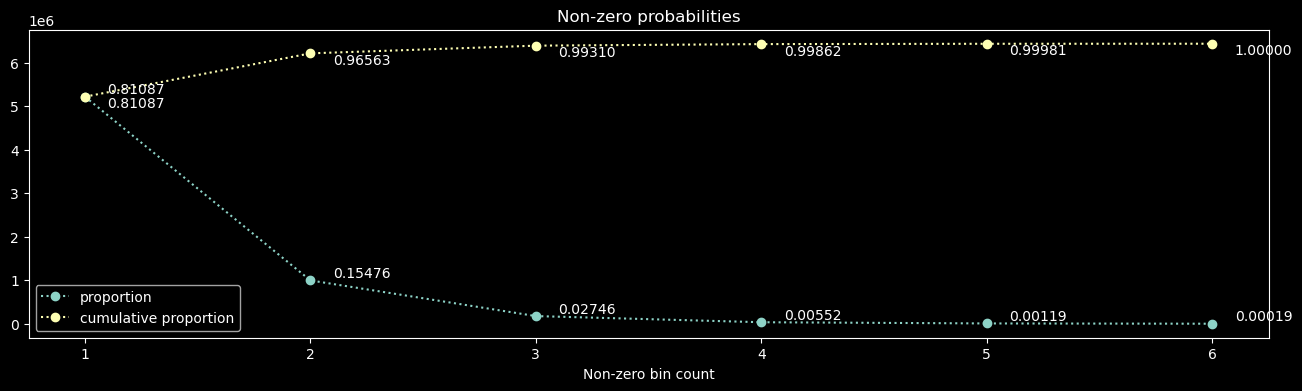

In [120]:
vec = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b', dtype='uint8')
tdm = vec.fit_transform(text_vector)
display(tdm)
print('Sparsity                                    : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1]) * 100))
print('Max count of a hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document       : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document      : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document           : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                  :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence             :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))
print('Non-zero probabilities:', end='')
nz_bin_count = [[bc, (tdm == bc).sum(), (tdm == bc).sum()/tdm.nnz] for bc in range(1, int(tdm.max()) + 1)]
display(pd.DataFrame(nz_bin_count, columns=['bin', 'count', 'proportion']))
bc, count, prob = zip(*nz_bin_count)
cumcount = np.cumsum(count).tolist()
cumprob = np.cumsum(prob).tolist()
plt.figure(figsize=(16,4))
plt.plot(bc, count, 'o:', label='proportion')
plt.title('Non-zero probabilities')
for i, _ in enumerate(prob):
    plt.text(bc[i]+.1, count[i], '{:.5f}'.format(prob[i]), va='bottom', ha='left')
plt.plot(bc, cumcount, 'o:', label='cumulative proportion')
for i, _ in enumerate(cumprob):
    plt.text(bc[i]+.1, cumcount[i], '{:.5f}'.format(cumprob[i]), va='top', ha='left')
plt.xlabel('Non-zero bin count')
plt.legend()
plt.show()

The maximum frequency of any hashed 1-gram token in a single observation is also 6 so the 8-bits unsigned integer `uint8` (0 to 255) also could be enough to store counts of any ngram range as long as there are sufficient `n_features`.

## Tokenizing hashed n-gram ranges

Iterating over `n_features` from the default $2^{20}$ to the maximum $2^{30}$ ([Murmurhash3 32-bit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)) and n-gram range from 1 to 3 in order to understand hashing collisions and memory usage.

In [121]:
def func(ngram_range, i):
    tracemalloc.start()
    t=time()
    tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
                                ngram_range=ngram_range, n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
    t=time()-t
    current, peak = tracemalloc.get_traced_memory()
    _, hash_counts = np.unique(tdm.data, return_counts=True)
    tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)

    msg = 'features:2^{}-{}={} ngram:{},{} cols:{} maxtf:{:.0f} maxtfall:{:.0f} hashcount:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
    msg = msg.format(i, (i//31), 2**i-(i//31), ngram_range[0], ngram_range[1], tdm.shape[1], tdm.max(),
                     tdm.sum(axis=0).max(), len(hash_counts), tdm.nnz, (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100,
                     size(tdm_nbytes), size(current), size(peak), t)
    return msg

messages = Parallel(n_jobs=-1)(delayed(func)(ngram_range=ngram_range, i=i)
                               for ngram_range in [(1,x) for x in range(1, max_unigrams + 1)]
                               for i in range(18, 32) # from 18 (recommended large enough) to 2^31-1 (Mumuhash3 32-bit)
                              )
for message in messages:
    print(message)

```
Last executed at 2022-09-15 16:54:05 in 10h 47m 43s

features:2^18-0=262144 ngram:1,1 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441089 sparse:99.99% size:32.2 MiB cur:98.7 MiB peak:166.7 MiB 10s
features:2^19-0=524288 ngram:1,1 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441094 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:152.9 MiB 11s
features:2^20-0=1048576 ngram:1,1 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:154.9 MiB 11s
features:2^21-0=2097152 ngram:1,1 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:158.9 MiB 11s
features:2^22-0=4194304 ngram:1,1 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:166.9 MiB 10s
features:2^23-0=8388608 ngram:1,1 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:182.9 MiB 11s
features:2^24-0=16777216 ngram:1,1 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:226.7 MiB 11s
features:2^25-0=33554432 ngram:1,1 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:354.7 MiB 11s
features:2^26-0=67108864 ngram:1,1 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:610.7 MiB 10s
features:2^27-0=134217728 ngram:1,1 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:1.1 GiB 11s
features:2^28-0=268435456 ngram:1,1 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:2.1 GiB 11s
features:2^29-0=536870912 ngram:1,1 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:4.1 GiB 11s
features:2^30-0=1073741824 ngram:1,1 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:8.1 GiB 10s
features:2^31-1=2147483647 ngram:1,1 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:6441095 sparse:100.00% size:32.2 MiB cur:98.7 MiB peak:16.1 GiB 11s
features:2^18-0=262144 ngram:1,2 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478586 sparse:99.99% size:65.8 MiB cur:106.7 MiB peak:32.1 GiB 22s
features:2^19-0=524288 ngram:1,2 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478607 sparse:99.99% size:65.8 MiB cur:106.7 MiB peak:214.6 MiB 22s
features:2^20-0=1048576 ngram:1,2 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:216.6 MiB 20s
features:2^21-0=2097152 ngram:1,2 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:220.6 MiB 22s
features:2^22-0=4194304 ngram:1,2 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:228.6 MiB 22s
features:2^23-0=8388608 ngram:1,2 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:244.6 MiB 22s
features:2^24-0=16777216 ngram:1,2 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:276.6 MiB 20s
features:2^25-0=33554432 ngram:1,2 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:362.7 MiB 22s
features:2^26-0=67108864 ngram:1,2 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:618.7 MiB 22s
features:2^27-0=134217728 ngram:1,2 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:1.1 GiB 22s
features:2^28-0=268435456 ngram:1,2 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:2.1 GiB 20s
features:2^29-0=536870912 ngram:1,2 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:4.1 GiB 22s
features:2^30-0=1073741824 ngram:1,2 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:8.1 GiB 22s
features:2^31-1=2147483647 ngram:1,2 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:13478633 sparse:100.00% size:65.8 MiB cur:106.7 MiB peak:16.1 GiB 22s
features:2^18-0=262144 ngram:1,3 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:20371267 sparse:99.98% size:98.7 MiB cur:122.7 MiB peak:32.1 GiB 29s
features:2^19-0=524288 ngram:1,3 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372027 sparse:99.99% size:98.7 MiB cur:122.7 MiB peak:283.2 MiB 32s
features:2^20-0=1048576 ngram:1,3 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372345 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:285.2 MiB 32s
features:2^21-0=2097152 ngram:1,3 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372662 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:289.2 MiB 32s
features:2^22-0=4194304 ngram:1,3 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372668 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:297.2 MiB 29s
features:2^23-0=8388608 ngram:1,3 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372669 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:313.2 MiB 32s
features:2^24-0=16777216 ngram:1,3 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:345.2 MiB 32s
features:2^25-0=33554432 ngram:1,3 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:409.2 MiB 32s
features:2^26-0=67108864 ngram:1,3 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:634.7 MiB 29s
features:2^27-0=134217728 ngram:1,3 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:1.1 GiB 32s
features:2^28-0=268435456 ngram:1,3 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:2.1 GiB 32s
features:2^29-0=536870912 ngram:1,3 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:4.1 GiB 32s
features:2^30-0=1073741824 ngram:1,3 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:8.1 GiB 29s
features:2^31-1=2147483647 ngram:1,3 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:20372670 sparse:100.00% size:98.7 MiB cur:122.7 MiB peak:16.1 GiB 32s
features:2^18-0=262144 ngram:1,4 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:26955689 sparse:99.97% size:130.1 MiB cur:122.7 MiB peak:32.1 GiB 41s
features:2^19-0=524288 ngram:1,4 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:26956768 sparse:99.99% size:130.1 MiB cur:122.7 MiB peak:333.5 MiB 41s
features:2^20-0=1048576 ngram:1,4 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957325 sparse:99.99% size:130.1 MiB cur:122.7 MiB peak:335.5 MiB 37s
features:2^21-0=2097152 ngram:1,4 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957645 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:339.5 MiB 41s
features:2^22-0=4194304 ngram:1,4 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957651 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:347.5 MiB 41s
features:2^23-0=8388608 ngram:1,4 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957652 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:363.5 MiB 41s
features:2^24-0=16777216 ngram:1,4 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:395.5 MiB 37s
features:2^25-0=33554432 ngram:1,4 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:459.5 MiB 41s
features:2^26-0=67108864 ngram:1,4 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:634.7 MiB 42s
features:2^27-0=134217728 ngram:1,4 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:1.1 GiB 41s
features:2^28-0=268435456 ngram:1,4 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:2.1 GiB 37s
features:2^29-0=536870912 ngram:1,4 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:4.1 GiB 41s
features:2^30-0=1073741824 ngram:1,4 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:8.1 GiB 41s
features:2^31-1=2147483647 ngram:1,4 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:26957695 sparse:100.00% size:130.1 MiB cur:122.7 MiB peak:16.1 GiB 41s
features:2^18-0=262144 ngram:1,5 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:33192778 sparse:99.97% size:159.8 MiB cur:122.4 MiB peak:32.1 GiB 46s
features:2^19-0=524288 ngram:1,5 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:33194134 sparse:99.98% size:159.8 MiB cur:122.4 MiB peak:380.7 MiB 51s
features:2^20-0=1048576 ngram:1,5 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195262 sparse:99.99% size:159.8 MiB cur:122.4 MiB peak:382.7 MiB 50s
features:2^21-0=2097152 ngram:1,5 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195621 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:386.7 MiB 50s
features:2^22-0=4194304 ngram:1,5 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195630 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:394.7 MiB 46s
features:2^23-0=8388608 ngram:1,5 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195677 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:410.7 MiB 51s
features:2^24-0=16777216 ngram:1,5 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:442.7 MiB 51s
features:2^25-0=33554432 ngram:1,5 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:506.7 MiB 50s
features:2^26-0=67108864 ngram:1,5 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195720 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:634.7 MiB 46s
features:2^27-0=134217728 ngram:1,5 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:1.1 GiB 51s
features:2^28-0=268435456 ngram:1,5 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:2.1 GiB 51s
features:2^29-0=536870912 ngram:1,5 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:4.1 GiB 51s
features:2^30-0=1073741824 ngram:1,5 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:8.1 GiB 46s
features:2^31-1=2147483647 ngram:1,5 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:33195723 sparse:100.00% size:159.8 MiB cur:122.4 MiB peak:16.1 GiB 51s
features:2^18-0=262144 ngram:1,6 cols:262144 maxtf:6 maxtfall:331001 hashcount:6 nnz:39076758 sparse:99.96% size:187.9 MiB cur:154.7 MiB peak:32.1 GiB 59s
features:2^19-0=524288 ngram:1,6 cols:524288 maxtf:6 maxtfall:331001 hashcount:6 nnz:39078725 sparse:99.98% size:187.9 MiB cur:154.7 MiB peak:457.9 MiB 59s
features:2^20-0=1048576 ngram:1,6 cols:1048576 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080009 sparse:99.99% size:187.9 MiB cur:154.7 MiB peak:459.9 MiB 53s
features:2^21-0=2097152 ngram:1,6 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080451 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:464.0 MiB 59s
features:2^22-0=4194304 ngram:1,6 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080488 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:472.0 MiB 59s
features:2^23-0=8388608 ngram:1,6 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080542 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:488.0 MiB 59s
features:2^24-0=16777216 ngram:1,6 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:520.0 MiB 53s
features:2^25-0=33554432 ngram:1,6 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:584.0 MiB 59s
features:2^26-0=67108864 ngram:1,6 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080587 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:712.0 MiB 59s
features:2^27-0=134217728 ngram:1,6 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:1.2 GiB 59s
features:2^28-0=268435456 ngram:1,6 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:2.2 GiB 53s
features:2^29-0=536870912 ngram:1,6 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:4.2 GiB 59s
features:2^30-0=1073741824 ngram:1,6 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:8.2 GiB 59s
features:2^31-1=2147483647 ngram:1,6 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:39080590 sparse:100.00% size:187.9 MiB cur:154.7 MiB peak:16.2 GiB 59s
features:2^18-0=262144 ngram:1,7 cols:262144 maxtf:6 maxtfall:331072 hashcount:6 nnz:44596942 sparse:99.96% size:214.2 MiB cur:154.7 MiB peak:32.2 GiB 61s
features:2^19-0=524288 ngram:1,7 cols:524288 maxtf:6 maxtfall:331072 hashcount:6 nnz:44600006 sparse:99.98% size:214.2 MiB cur:154.7 MiB peak:500.0 MiB 67s
features:2^20-0=1048576 ngram:1,7 cols:1048576 maxtf:6 maxtfall:331072 hashcount:6 nnz:44602296 sparse:99.99% size:214.2 MiB cur:154.7 MiB peak:502.1 MiB 67s
features:2^21-0=2097152 ngram:1,7 cols:2097152 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603017 sparse:99.99% size:214.2 MiB cur:154.7 MiB peak:506.1 MiB 67s
features:2^22-0=4194304 ngram:1,7 cols:4194304 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603226 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:514.1 MiB 61s
features:2^23-0=8388608 ngram:1,7 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603283 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:530.1 MiB 67s
features:2^24-0=16777216 ngram:1,7 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603328 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:562.1 MiB 67s
features:2^25-0=33554432 ngram:1,7 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603328 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:626.1 MiB 67s
features:2^26-0=67108864 ngram:1,7 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603331 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:754.1 MiB 61s
features:2^27-0=134217728 ngram:1,7 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:1.2 GiB 67s
features:2^28-0=268435456 ngram:1,7 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:2.2 GiB 67s
features:2^29-0=536870912 ngram:1,7 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:4.2 GiB 67s
features:2^30-0=1073741824 ngram:1,7 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:8.2 GiB 61s
features:2^31-1=2147483647 ngram:1,7 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:44603334 sparse:100.00% size:214.2 MiB cur:154.7 MiB peak:16.2 GiB 68s
features:2^18-0=262144 ngram:1,8 cols:262144 maxtf:6 maxtfall:331075 hashcount:6 nnz:49747625 sparse:99.95% size:238.7 MiB cur:154.7 MiB peak:32.2 GiB 75s
features:2^19-0=524288 ngram:1,8 cols:524288 maxtf:6 maxtfall:331075 hashcount:6 nnz:49754486 sparse:99.98% size:238.8 MiB cur:154.7 MiB peak:539.3 MiB 75s
features:2^20-0=1048576 ngram:1,8 cols:1048576 maxtf:6 maxtfall:331075 hashcount:6 nnz:49757004 sparse:99.99% size:238.8 MiB cur:154.7 MiB peak:541.4 MiB 68s
features:2^21-0=2097152 ngram:1,8 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:49757949 sparse:99.99% size:238.8 MiB cur:154.7 MiB peak:545.4 MiB 75s
features:2^22-0=4194304 ngram:1,8 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:49758170 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:553.4 MiB 75s
features:2^23-0=8388608 ngram:1,8 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758240 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:569.4 MiB 75s
features:2^24-0=16777216 ngram:1,8 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758288 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:601.4 MiB 68s
features:2^25-0=33554432 ngram:1,8 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758288 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:665.4 MiB 75s
features:2^26-0=67108864 ngram:1,8 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758291 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:793.4 MiB 75s
features:2^27-0=134217728 ngram:1,8 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758294 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:1.2 GiB 75s
features:2^28-0=268435456 ngram:1,8 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758294 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:2.2 GiB 68s
features:2^29-0=536870912 ngram:1,8 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758294 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:4.2 GiB 75s
features:2^30-0=1073741824 ngram:1,8 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758294 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:8.2 GiB 75s
features:2^31-1=2147483647 ngram:1,8 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:49758294 sparse:100.00% size:238.8 MiB cur:154.7 MiB peak:16.2 GiB 75s
features:2^18-0=262144 ngram:1,9 cols:262144 maxtf:6 maxtfall:331081 hashcount:6 nnz:54520442 sparse:99.95% size:261.5 MiB cur:154.7 MiB peak:32.2 GiB 74s
features:2^19-0=524288 ngram:1,9 cols:524288 maxtf:6 maxtfall:331077 hashcount:6 nnz:54528458 sparse:99.97% size:261.5 MiB cur:154.7 MiB peak:575.8 MiB 82s
features:2^20-0=1048576 ngram:1,9 cols:1048576 maxtf:6 maxtfall:331075 hashcount:6 nnz:54531613 sparse:99.99% size:261.6 MiB cur:154.7 MiB peak:577.8 MiB 82s
features:2^21-0=2097152 ngram:1,9 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:54532601 sparse:99.99% size:261.6 MiB cur:154.7 MiB peak:581.8 MiB 82s
features:2^22-0=4194304 ngram:1,9 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:54532987 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:589.9 MiB 74s
features:2^23-0=8388608 ngram:1,9 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533675 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:605.9 MiB 82s
features:2^24-0=16777216 ngram:1,9 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533744 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:637.9 MiB 82s
features:2^25-0=33554432 ngram:1,9 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533777 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:701.9 MiB 82s
features:2^26-0=67108864 ngram:1,9 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533784 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:829.9 MiB 74s
features:2^27-0=134217728 ngram:1,9 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533787 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:1.2 GiB 83s
features:2^28-0=268435456 ngram:1,9 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533787 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:2.2 GiB 83s
features:2^29-0=536870912 ngram:1,9 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533787 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:4.2 GiB 82s
features:2^30-0=1073741824 ngram:1,9 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533787 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:8.2 GiB 74s
features:2^31-1=2147483647 ngram:1,9 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:54533787 sparse:100.00% size:261.6 MiB cur:154.7 MiB peak:16.2 GiB 82s
features:2^18-0=262144 ngram:1,10 cols:262144 maxtf:6 maxtfall:331081 hashcount:6 nnz:58912450 sparse:99.94% size:282.4 MiB cur:154.7 MiB peak:32.2 GiB 89s
features:2^19-0=524288 ngram:1,10 cols:524288 maxtf:6 maxtfall:331077 hashcount:6 nnz:58921382 sparse:99.97% size:282.5 MiB cur:154.7 MiB peak:609.3 MiB 89s
features:2^20-0=1048576 ngram:1,10 cols:1048576 maxtf:6 maxtfall:331075 hashcount:6 nnz:58924717 sparse:99.99% size:282.5 MiB cur:154.7 MiB peak:611.3 MiB 80s
features:2^21-0=2097152 ngram:1,10 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:58926007 sparse:99.99% size:282.5 MiB cur:154.7 MiB peak:615.4 MiB 89s
features:2^22-0=4194304 ngram:1,10 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:58926513 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:623.4 MiB 89s
features:2^23-0=8388608 ngram:1,10 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927208 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:639.4 MiB 89s
features:2^24-0=16777216 ngram:1,10 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927280 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:671.4 MiB 80s
features:2^25-0=33554432 ngram:1,10 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927314 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:735.4 MiB 89s
features:2^26-0=67108864 ngram:1,10 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927374 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:863.4 MiB 89s
features:2^27-0=134217728 ngram:1,10 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927381 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:1.2 GiB 89s
features:2^28-0=268435456 ngram:1,10 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927381 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:2.2 GiB 80s
features:2^29-0=536870912 ngram:1,10 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927381 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:4.2 GiB 89s
features:2^30-0=1073741824 ngram:1,10 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927381 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:8.2 GiB 89s
features:2^31-1=2147483647 ngram:1,10 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:58927381 sparse:100.00% size:282.5 MiB cur:154.7 MiB peak:16.2 GiB 89s
features:2^18-0=262144 ngram:1,11 cols:262144 maxtf:6 maxtfall:331088 hashcount:6 nnz:62926780 sparse:99.94% size:301.6 MiB cur:154.7 MiB peak:32.2 GiB 86s
features:2^19-0=524288 ngram:1,11 cols:524288 maxtf:6 maxtfall:331084 hashcount:6 nnz:62936848 sparse:99.97% size:301.6 MiB cur:154.7 MiB peak:639.9 MiB 95s
features:2^20-0=1048576 ngram:1,11 cols:1048576 maxtf:6 maxtfall:331076 hashcount:6 nnz:62941101 sparse:99.99% size:301.7 MiB cur:154.7 MiB peak:642.0 MiB 95s
features:2^21-0=2097152 ngram:1,11 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:62942585 sparse:99.99% size:301.7 MiB cur:154.7 MiB peak:646.0 MiB 95s
features:2^22-0=4194304 ngram:1,11 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:62943227 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:654.0 MiB 86s
features:2^23-0=8388608 ngram:1,11 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:62943940 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:670.0 MiB 95s
features:2^24-0=16777216 ngram:1,11 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944056 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:702.0 MiB 95s
features:2^25-0=33554432 ngram:1,11 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944105 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:766.0 MiB 95s
features:2^26-0=67108864 ngram:1,11 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944166 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:894.0 MiB 86s
features:2^27-0=134217728 ngram:1,11 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944173 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:1.2 GiB 95s
features:2^28-0=268435456 ngram:1,11 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944206 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:2.2 GiB 95s
features:2^29-0=536870912 ngram:1,11 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944206 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:4.2 GiB 95s
features:2^30-0=1073741824 ngram:1,11 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944206 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:8.2 GiB 86s
features:2^31-1=2147483647 ngram:1,11 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:62944206 sparse:100.00% size:301.7 MiB cur:154.7 MiB peak:16.2 GiB 95s
features:2^18-0=262144 ngram:1,12 cols:262144 maxtf:6 maxtfall:331088 hashcount:6 nnz:66571720 sparse:99.94% size:319.0 MiB cur:154.2 MiB peak:32.2 GiB 101s
features:2^19-0=524288 ngram:1,12 cols:524288 maxtf:6 maxtfall:331084 hashcount:6 nnz:66585798 sparse:99.97% size:319.0 MiB cur:154.3 MiB peak:667.2 MiB 101s
features:2^20-0=1048576 ngram:1,12 cols:1048576 maxtf:6 maxtfall:331076 hashcount:6 nnz:66591015 sparse:99.98% size:319.1 MiB cur:154.3 MiB peak:669.3 MiB 91s
features:2^21-0=2097152 ngram:1,12 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:66592797 sparse:99.99% size:319.1 MiB cur:154.3 MiB peak:673.4 MiB 101s
features:2^22-0=4194304 ngram:1,12 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:66593471 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:681.4 MiB 101s
features:2^23-0=8388608 ngram:1,12 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594301 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:697.4 MiB 101s
features:2^24-0=16777216 ngram:1,12 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594431 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:729.4 MiB 92s
features:2^25-0=33554432 ngram:1,12 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594489 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:793.4 MiB 101s
features:2^26-0=67108864 ngram:1,12 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594558 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:921.4 MiB 101s
features:2^27-0=134217728 ngram:1,12 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594565 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:1.2 GiB 101s
features:2^28-0=268435456 ngram:1,12 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594598 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:2.2 GiB 91s
features:2^29-0=536870912 ngram:1,12 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594598 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:4.2 GiB 101s
features:2^30-0=1073741824 ngram:1,12 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594598 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:8.2 GiB 101s
features:2^31-1=2147483647 ngram:1,12 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:66594598 sparse:100.00% size:319.1 MiB cur:154.3 MiB peak:16.2 GiB 101s
features:2^18-0=262144 ngram:1,13 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:69861217 sparse:99.93% size:334.7 MiB cur:218.7 MiB peak:32.2 GiB 96s
features:2^19-0=524288 ngram:1,13 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:69876469 sparse:99.97% size:334.7 MiB cur:218.7 MiB peak:756.8 MiB 106s
features:2^20-0=1048576 ngram:1,13 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:69882910 sparse:99.98% size:334.8 MiB cur:218.7 MiB peak:758.9 MiB 106s
features:2^21-0=2097152 ngram:1,13 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:69885465 sparse:99.99% size:334.8 MiB cur:218.7 MiB peak:763.0 MiB 106s
features:2^22-0=4194304 ngram:1,13 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:69886233 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:771.0 MiB 96s
features:2^23-0=8388608 ngram:1,13 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887068 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:787.0 MiB 106s
features:2^24-0=16777216 ngram:1,13 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887204 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:819.0 MiB 106s
features:2^25-0=33554432 ngram:1,13 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887262 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:883.0 MiB 106s
features:2^26-0=67108864 ngram:1,13 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887332 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:1011.0 MiB 96s
features:2^27-0=134217728 ngram:1,13 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887339 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:1.2 GiB 106s
features:2^28-0=268435456 ngram:1,13 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887372 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:2.2 GiB 106s
features:2^29-0=536870912 ngram:1,13 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887372 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:4.2 GiB 106s
features:2^30-0=1073741824 ngram:1,13 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887372 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:8.2 GiB 96s
features:2^31-1=2147483647 ngram:1,13 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:69887378 sparse:100.00% size:334.8 MiB cur:218.7 MiB peak:16.2 GiB 106s
features:2^18-0=262144 ngram:1,14 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:72806482 sparse:99.93% size:348.7 MiB cur:218.7 MiB peak:32.2 GiB 110s
features:2^19-0=524288 ngram:1,14 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:72824129 sparse:99.97% size:348.8 MiB cur:218.7 MiB peak:779.3 MiB 110s
features:2^20-0=1048576 ngram:1,14 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:72830942 sparse:99.98% size:348.8 MiB cur:218.7 MiB peak:781.4 MiB 100s
features:2^21-0=2097152 ngram:1,14 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:72833845 sparse:99.99% size:348.8 MiB cur:218.7 MiB peak:785.5 MiB 110s
features:2^22-0=4194304 ngram:1,14 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:72834687 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:793.5 MiB 110s
features:2^23-0=8388608 ngram:1,14 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835554 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:809.5 MiB 111s
features:2^24-0=16777216 ngram:1,14 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835762 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:841.5 MiB 100s
features:2^25-0=33554432 ngram:1,14 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835867 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:905.5 MiB 110s
features:2^26-0=67108864 ngram:1,14 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835937 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:1.0 GiB 111s
features:2^27-0=134217728 ngram:1,14 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835944 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:1.3 GiB 110s
features:2^28-0=268435456 ngram:1,14 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835977 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:2.2 GiB 100s
features:2^29-0=536870912 ngram:1,14 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835977 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:4.2 GiB 111s
features:2^30-0=1073741824 ngram:1,14 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835977 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:8.2 GiB 110s
features:2^31-1=2147483647 ngram:1,14 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:72835983 sparse:100.00% size:348.8 MiB cur:218.7 MiB peak:16.2 GiB 110s
features:2^18-0=262144 ngram:1,15 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:75432557 sparse:99.93% size:361.2 MiB cur:218.7 MiB peak:32.2 GiB 104s
features:2^19-0=524288 ngram:1,15 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:75451083 sparse:99.96% size:361.3 MiB cur:218.7 MiB peak:799.3 MiB 115s
features:2^20-0=1048576 ngram:1,15 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:75458239 sparse:99.98% size:361.3 MiB cur:218.7 MiB peak:801.5 MiB 115s
features:2^21-0=2097152 ngram:1,15 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:75462133 sparse:99.99% size:361.4 MiB cur:218.7 MiB peak:805.5 MiB 114s
features:2^22-0=4194304 ngram:1,15 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:75463083 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:813.5 MiB 104s
features:2^23-0=8388608 ngram:1,15 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:75463961 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:829.5 MiB 115s
features:2^24-0=16777216 ngram:1,15 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464175 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:861.5 MiB 115s
features:2^25-0=33554432 ngram:1,15 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464282 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:925.6 MiB 114s
features:2^26-0=67108864 ngram:1,15 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464352 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:1.0 GiB 104s
features:2^27-0=134217728 ngram:1,15 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464362 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:1.3 GiB 115s
features:2^28-0=268435456 ngram:1,15 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464395 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:2.2 GiB 115s
features:2^29-0=536870912 ngram:1,15 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464396 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:4.2 GiB 115s
features:2^30-0=1073741824 ngram:1,15 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464396 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:8.2 GiB 104s
features:2^31-1=2147483647 ngram:1,15 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:75464402 sparse:100.00% size:361.4 MiB cur:218.7 MiB peak:16.2 GiB 115s
features:2^18-0=262144 ngram:1,16 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:77766126 sparse:99.93% size:372.3 MiB cur:218.7 MiB peak:32.2 GiB 118s
features:2^19-0=524288 ngram:1,16 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:77785485 sparse:99.96% size:372.4 MiB cur:218.7 MiB peak:817.1 MiB 118s
features:2^20-0=1048576 ngram:1,16 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:77793076 sparse:99.98% size:372.5 MiB cur:218.7 MiB peak:819.3 MiB 107s
features:2^21-0=2097152 ngram:1,16 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:77797134 sparse:99.99% size:372.5 MiB cur:218.7 MiB peak:823.3 MiB 118s
features:2^22-0=4194304 ngram:1,16 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:77798138 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:831.4 MiB 118s
features:2^23-0=8388608 ngram:1,16 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:77799800 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:847.4 MiB 118s
features:2^24-0=16777216 ngram:1,16 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800089 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:879.4 MiB 107s
features:2^25-0=33554432 ngram:1,16 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800208 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:943.4 MiB 118s
features:2^26-0=67108864 ngram:1,16 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800279 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:1.0 GiB 118s
features:2^27-0=134217728 ngram:1,16 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800289 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:1.3 GiB 118s
features:2^28-0=268435456 ngram:1,16 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800322 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:2.2 GiB 107s
features:2^29-0=536870912 ngram:1,16 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800323 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:4.2 GiB 118s
features:2^30-0=1073741824 ngram:1,16 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800323 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:8.2 GiB 118s
features:2^31-1=2147483647 ngram:1,16 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:77800329 sparse:100.00% size:372.5 MiB cur:218.7 MiB peak:16.2 GiB 118s
features:2^18-0=262144 ngram:1,17 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:79825922 sparse:99.92% size:382.2 MiB cur:218.7 MiB peak:32.2 GiB 110s
features:2^19-0=524288 ngram:1,17 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:79847775 sparse:99.96% size:382.3 MiB cur:218.7 MiB peak:832.8 MiB 122s
features:2^20-0=1048576 ngram:1,17 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:79855564 sparse:99.98% size:382.3 MiB cur:218.7 MiB peak:835.0 MiB 122s
features:2^21-0=2097152 ngram:1,17 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:79859718 sparse:99.99% size:382.3 MiB cur:218.7 MiB peak:839.1 MiB 122s
features:2^22-0=4194304 ngram:1,17 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:79860886 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:847.1 MiB 110s
features:2^23-0=8388608 ngram:1,17 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:79862996 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:863.1 MiB 122s
features:2^24-0=16777216 ngram:1,17 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863286 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:895.1 MiB 122s
features:2^25-0=33554432 ngram:1,17 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863450 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:959.1 MiB 122s
features:2^26-0=67108864 ngram:1,17 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863522 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:1.1 GiB 110s
features:2^27-0=134217728 ngram:1,17 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863532 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:1.3 GiB 122s
features:2^28-0=268435456 ngram:1,17 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863565 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:2.2 GiB 122s
features:2^29-0=536870912 ngram:1,17 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863566 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:4.2 GiB 122s
features:2^30-0=1073741824 ngram:1,17 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863566 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:8.2 GiB 110s
features:2^31-1=2147483647 ngram:1,17 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:79863572 sparse:100.00% size:382.3 MiB cur:218.7 MiB peak:16.2 GiB 121s
features:2^18-0=262144 ngram:1,18 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:81634557 sparse:99.92% size:390.8 MiB cur:218.7 MiB peak:32.2 GiB 125s
features:2^19-0=524288 ngram:1,18 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:81657559 sparse:99.96% size:390.9 MiB cur:218.7 MiB peak:846.6 MiB 125s
features:2^20-0=1048576 ngram:1,18 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:81666976 sparse:99.98% size:390.9 MiB cur:218.7 MiB peak:848.8 MiB 113s
features:2^21-0=2097152 ngram:1,18 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:81671217 sparse:99.99% size:391.0 MiB cur:218.7 MiB peak:852.9 MiB 124s
features:2^22-0=4194304 ngram:1,18 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:81672447 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:860.9 MiB 124s
features:2^23-0=8388608 ngram:1,18 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:81674587 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:876.9 MiB 124s
features:2^24-0=16777216 ngram:1,18 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:81674884 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:908.9 MiB 113s
features:2^25-0=33554432 ngram:1,18 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675050 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:972.9 MiB 125s
features:2^26-0=67108864 ngram:1,18 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675122 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:1.1 GiB 125s
features:2^27-0=134217728 ngram:1,18 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675132 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:1.3 GiB 125s
features:2^28-0=268435456 ngram:1,18 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675165 sparse:100.00% size:391.0 MiB cur:218.7 MiB peak:2.2 GiB 113s
features:2^29-0=536870912 ngram:1,18 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675168 sparse:100.00% size:391.0 MiB cur:218.8 MiB peak:4.2 GiB 125s
features:2^30-0=1073741824 ngram:1,18 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675168 sparse:100.00% size:391.0 MiB cur:218.8 MiB peak:8.2 GiB 125s
features:2^31-1=2147483647 ngram:1,18 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:81675174 sparse:100.00% size:391.0 MiB cur:218.8 MiB peak:16.2 GiB 125s
features:2^18-0=262144 ngram:1,19 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:83210408 sparse:99.92% size:398.3 MiB cur:218.8 MiB peak:32.2 GiB 115s
features:2^19-0=524288 ngram:1,19 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:83234926 sparse:99.96% size:398.4 MiB cur:218.8 MiB peak:858.7 MiB 127s
features:2^20-0=1048576 ngram:1,19 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:83244433 sparse:99.98% size:398.5 MiB cur:218.8 MiB peak:860.8 MiB 127s
features:2^21-0=2097152 ngram:1,19 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:83249053 sparse:99.99% size:398.5 MiB cur:218.8 MiB peak:864.9 MiB 127s
features:2^22-0=4194304 ngram:1,19 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:83250296 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:872.9 MiB 115s
features:2^23-0=8388608 ngram:1,19 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:83252453 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:889.0 MiB 127s
features:2^24-0=16777216 ngram:1,19 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:83252788 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:921.0 MiB 127s
features:2^25-0=33554432 ngram:1,19 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:83252957 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:985.0 MiB 127s
features:2^26-0=67108864 ngram:1,19 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:83253029 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:1.1 GiB 115s
features:2^27-0=134217728 ngram:1,19 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:83253042 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:1.3 GiB 127s
features:2^28-0=268435456 ngram:1,19 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:83253075 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:2.2 GiB 127s
features:2^29-0=536870912 ngram:1,19 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:83253078 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:4.2 GiB 127s
features:2^30-0=1073741824 ngram:1,19 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:83253078 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:8.2 GiB 115s
features:2^31-1=2147483647 ngram:1,19 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:83253084 sparse:100.00% size:398.5 MiB cur:218.8 MiB peak:16.2 GiB 127s
features:2^18-0=262144 ngram:1,20 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:84576928 sparse:99.92% size:404.8 MiB cur:218.8 MiB peak:32.2 GiB 129s
features:2^19-0=524288 ngram:1,20 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:84602116 sparse:99.96% size:404.9 MiB cur:218.8 MiB peak:869.1 MiB 129s
features:2^20-0=1048576 ngram:1,20 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:84612043 sparse:99.98% size:405.0 MiB cur:218.8 MiB peak:871.3 MiB 117s
features:2^21-0=2097152 ngram:1,20 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:84616888 sparse:99.99% size:405.0 MiB cur:218.8 MiB peak:875.3 MiB 129s
features:2^22-0=4194304 ngram:1,20 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:84618299 sparse:99.99% size:405.0 MiB cur:218.8 MiB peak:883.4 MiB 129s
features:2^23-0=8388608 ngram:1,20 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:84620457 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:899.4 MiB 129s
features:2^24-0=16777216 ngram:1,20 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:84620796 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:931.4 MiB 117s
features:2^25-0=33554432 ngram:1,20 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622276 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:995.4 MiB 129s
features:2^26-0=67108864 ngram:1,20 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622348 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:1.1 GiB 129s
features:2^27-0=134217728 ngram:1,20 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622365 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:1.3 GiB 129s
features:2^28-0=268435456 ngram:1,20 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622398 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:2.2 GiB 117s
features:2^29-0=536870912 ngram:1,20 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622401 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:4.2 GiB 129s
features:2^30-0=1073741824 ngram:1,20 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622401 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:8.2 GiB 129s
features:2^31-1=2147483647 ngram:1,20 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:84622407 sparse:100.00% size:405.0 MiB cur:218.8 MiB peak:16.2 GiB 129s
features:2^18-0=262144 ngram:1,21 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:85761144 sparse:99.92% size:410.5 MiB cur:218.8 MiB peak:32.2 GiB 119s
features:2^19-0=524288 ngram:1,21 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:85787080 sparse:99.96% size:410.6 MiB cur:218.8 MiB peak:878.1 MiB 131s
features:2^20-0=1048576 ngram:1,21 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:85797270 sparse:99.98% size:410.6 MiB cur:218.8 MiB peak:880.3 MiB 131s
features:2^21-0=2097152 ngram:1,21 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:85802176 sparse:99.99% size:410.7 MiB cur:218.8 MiB peak:884.4 MiB 131s
features:2^22-0=4194304 ngram:1,21 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:85803617 sparse:99.99% size:410.7 MiB cur:218.8 MiB peak:892.4 MiB 119s
features:2^23-0=8388608 ngram:1,21 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:85805905 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:908.4 MiB 131s
features:2^24-0=16777216 ngram:1,21 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:85806245 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:940.5 MiB 131s
features:2^25-0=33554432 ngram:1,21 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807732 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:1004.5 MiB 131s
features:2^26-0=67108864 ngram:1,21 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807804 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:1.1 GiB 119s
features:2^27-0=134217728 ngram:1,21 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807821 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:1.4 GiB 131s
features:2^28-0=268435456 ngram:1,21 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807854 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:2.2 GiB 131s
features:2^29-0=536870912 ngram:1,21 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807862 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:4.2 GiB 131s
features:2^30-0=1073741824 ngram:1,21 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807862 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:8.2 GiB 119s
features:2^31-1=2147483647 ngram:1,21 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:85807868 sparse:100.00% size:410.7 MiB cur:218.8 MiB peak:16.2 GiB 131s
features:2^18-0=262144 ngram:1,22 cols:262144 maxtf:6 maxtfall:331245 hashcount:6 nnz:86782595 sparse:99.92% size:415.3 MiB cur:218.8 MiB peak:32.2 GiB 133s
features:2^19-0=524288 ngram:1,22 cols:524288 maxtf:6 maxtfall:331086 hashcount:6 nnz:86810618 sparse:99.96% size:415.5 MiB cur:218.8 MiB peak:885.9 MiB 133s
features:2^20-0=1048576 ngram:1,22 cols:1048576 maxtf:6 maxtfall:331078 hashcount:6 nnz:86821193 sparse:99.98% size:415.5 MiB cur:218.8 MiB peak:888.1 MiB 121s
features:2^21-0=2097152 ngram:1,22 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:86826470 sparse:99.99% size:415.5 MiB cur:218.8 MiB peak:892.2 MiB 133s
features:2^22-0=4194304 ngram:1,22 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:86827957 sparse:99.99% size:415.6 MiB cur:218.8 MiB peak:900.2 MiB 133s
features:2^23-0=8388608 ngram:1,22 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:86830249 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:916.3 MiB 133s
features:2^24-0=16777216 ngram:1,22 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:86830594 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:948.3 MiB 121s
features:2^25-0=33554432 ngram:1,22 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832081 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:1012.3 MiB 133s
features:2^26-0=67108864 ngram:1,22 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832153 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:1.1 GiB 133s
features:2^27-0=134217728 ngram:1,22 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832170 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:1.4 GiB 133s
features:2^28-0=268435456 ngram:1,22 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832203 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:2.2 GiB 120s
features:2^29-0=536870912 ngram:1,22 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832211 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:4.2 GiB 133s
features:2^30-0=1073741824 ngram:1,22 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832211 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:8.2 GiB 133s
features:2^31-1=2147483647 ngram:1,22 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:86832217 sparse:100.00% size:415.6 MiB cur:218.8 MiB peak:16.2 GiB 133s
features:2^18-0=262144 ngram:1,23 cols:262144 maxtf:6 maxtfall:331246 hashcount:6 nnz:87672202 sparse:99.92% size:419.6 MiB cur:218.8 MiB peak:32.2 GiB 122s
features:2^19-0=524288 ngram:1,23 cols:524288 maxtf:6 maxtfall:331087 hashcount:6 nnz:87700899 sparse:99.96% size:419.7 MiB cur:218.8 MiB peak:892.7 MiB 135s
features:2^20-0=1048576 ngram:1,23 cols:1048576 maxtf:6 maxtfall:331079 hashcount:6 nnz:87711729 sparse:99.98% size:419.8 MiB cur:218.8 MiB peak:894.9 MiB 134s
features:2^21-0=2097152 ngram:1,23 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:87717153 sparse:99.99% size:419.8 MiB cur:218.8 MiB peak:899.0 MiB 134s
features:2^22-0=4194304 ngram:1,23 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:87718678 sparse:99.99% size:419.8 MiB cur:218.8 MiB peak:907.0 MiB 122s
features:2^23-0=8388608 ngram:1,23 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:87721185 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:923.0 MiB 134s
features:2^24-0=16777216 ngram:1,23 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:87721547 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:955.1 MiB 134s
features:2^25-0=33554432 ngram:1,23 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723041 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:1019.1 MiB 135s
features:2^26-0=67108864 ngram:1,23 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723118 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:1.1 GiB 122s
features:2^27-0=134217728 ngram:1,23 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723135 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:1.4 GiB 134s
features:2^28-0=268435456 ngram:1,23 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723168 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:2.2 GiB 135s
features:2^29-0=536870912 ngram:1,23 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723176 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:4.2 GiB 135s
features:2^30-0=1073741824 ngram:1,23 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723176 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:8.2 GiB 122s
features:2^31-1=2147483647 ngram:1,23 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:87723182 sparse:100.00% size:419.8 MiB cur:218.8 MiB peak:16.2 GiB 135s
features:2^18-0=262144 ngram:1,24 cols:262144 maxtf:6 maxtfall:331246 hashcount:6 nnz:88447593 sparse:99.92% size:423.3 MiB cur:218.8 MiB peak:32.2 GiB 136s
features:2^19-0=524288 ngram:1,24 cols:524288 maxtf:6 maxtfall:331087 hashcount:6 nnz:88476551 sparse:99.96% size:423.4 MiB cur:218.8 MiB peak:898.6 MiB 136s
features:2^20-0=1048576 ngram:1,24 cols:1048576 maxtf:6 maxtfall:331079 hashcount:6 nnz:88487539 sparse:99.98% size:423.5 MiB cur:218.8 MiB peak:900.8 MiB 123s
features:2^21-0=2097152 ngram:1,24 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:88493172 sparse:99.99% size:423.5 MiB cur:218.8 MiB peak:904.9 MiB 136s
features:2^22-0=4194304 ngram:1,24 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:88494735 sparse:99.99% size:423.5 MiB cur:218.8 MiB peak:913.0 MiB 136s
features:2^23-0=8388608 ngram:1,24 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:88497251 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:929.0 MiB 136s
features:2^24-0=16777216 ngram:1,24 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:88497621 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:961.0 MiB 124s
features:2^25-0=33554432 ngram:1,24 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499115 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:1.0 GiB 136s
features:2^26-0=67108864 ngram:1,24 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499192 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:1.1 GiB 136s
features:2^27-0=134217728 ngram:1,24 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499209 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:1.4 GiB 136s
features:2^28-0=268435456 ngram:1,24 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499242 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:2.2 GiB 123s
features:2^29-0=536870912 ngram:1,24 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499250 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:4.2 GiB 136s
features:2^30-0=1073741824 ngram:1,24 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499250 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:8.2 GiB 136s
features:2^31-1=2147483647 ngram:1,24 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:88499256 sparse:100.00% size:423.5 MiB cur:218.8 MiB peak:16.2 GiB 135s
features:2^18-0=262144 ngram:1,25 cols:262144 maxtf:6 maxtfall:331246 hashcount:6 nnz:89123121 sparse:99.92% size:426.5 MiB cur:218.8 MiB peak:32.2 GiB 125s
features:2^19-0=524288 ngram:1,25 cols:524288 maxtf:6 maxtfall:331087 hashcount:6 nnz:89152424 sparse:99.96% size:426.6 MiB cur:218.8 MiB peak:903.8 MiB 137s
features:2^20-0=1048576 ngram:1,25 cols:1048576 maxtf:6 maxtfall:331079 hashcount:6 nnz:89164445 sparse:99.98% size:426.7 MiB cur:218.8 MiB peak:906.0 MiB 137s
features:2^21-0=2097152 ngram:1,25 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:89170256 sparse:99.99% size:426.7 MiB cur:218.8 MiB peak:910.1 MiB 137s
features:2^22-0=4194304 ngram:1,25 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:89171822 sparse:99.99% size:426.7 MiB cur:218.8 MiB peak:918.1 MiB 124s
features:2^23-0=8388608 ngram:1,25 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:89174342 sparse:100.00% size:426.7 MiB cur:218.8 MiB peak:934.1 MiB 137s
features:2^24-0=16777216 ngram:1,25 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:89174712 sparse:100.00% size:426.7 MiB cur:218.8 MiB peak:966.2 MiB 137s
features:2^25-0=33554432 ngram:1,25 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176211 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:1.0 GiB 137s
features:2^26-0=67108864 ngram:1,25 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176288 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:1.1 GiB 124s
features:2^27-0=134217728 ngram:1,25 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176305 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:1.4 GiB 137s
features:2^28-0=268435456 ngram:1,25 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176338 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:2.2 GiB 137s
features:2^29-0=536870912 ngram:1,25 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176346 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:4.2 GiB 137s
features:2^30-0=1073741824 ngram:1,25 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176346 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:8.2 GiB 124s
features:2^31-1=2147483647 ngram:1,25 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:89176352 sparse:100.00% size:426.8 MiB cur:218.8 MiB peak:16.2 GiB 137s
features:2^18-0=262144 ngram:1,26 cols:262144 maxtf:6 maxtfall:331246 hashcount:6 nnz:89716060 sparse:99.91% size:429.3 MiB cur:218.8 MiB peak:32.2 GiB 138s
features:2^19-0=524288 ngram:1,26 cols:524288 maxtf:6 maxtfall:331087 hashcount:6 nnz:89746278 sparse:99.96% size:429.5 MiB cur:218.8 MiB peak:908.3 MiB 138s
features:2^20-0=1048576 ngram:1,26 cols:1048576 maxtf:6 maxtfall:331079 hashcount:6 nnz:89758382 sparse:99.98% size:429.5 MiB cur:218.8 MiB peak:910.5 MiB 125s
features:2^21-0=2097152 ngram:1,26 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:89764758 sparse:99.99% size:429.6 MiB cur:218.8 MiB peak:914.6 MiB 138s
features:2^22-0=4194304 ngram:1,26 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:89766584 sparse:99.99% size:429.6 MiB cur:218.8 MiB peak:922.7 MiB 138s
features:2^23-0=8388608 ngram:1,26 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:89769115 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:938.7 MiB 138s
features:2^24-0=16777216 ngram:1,26 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:89769487 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:970.7 MiB 125s
features:2^25-0=33554432 ngram:1,26 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:89770986 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:1.0 GiB 138s
features:2^26-0=67108864 ngram:1,26 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:89771063 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:1.1 GiB 138s
features:2^27-0=134217728 ngram:1,26 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:89771080 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:1.4 GiB 138s
features:2^28-0=268435456 ngram:1,26 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:89771113 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:2.2 GiB 125s
features:2^29-0=536870912 ngram:1,26 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:89771121 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:4.2 GiB 138s
features:2^30-0=1073741824 ngram:1,26 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:89771121 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:8.2 GiB 138s
features:2^31-1=2147483647 ngram:1,26 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:89771127 sparse:100.00% size:429.6 MiB cur:218.8 MiB peak:16.2 GiB 138s
features:2^18-0=262144 ngram:1,27 cols:262144 maxtf:6 maxtfall:331246 hashcount:6 nnz:90238570 sparse:99.91% size:431.8 MiB cur:218.8 MiB peak:32.2 GiB 126s
features:2^19-0=524288 ngram:1,27 cols:524288 maxtf:6 maxtfall:331087 hashcount:6 nnz:90269160 sparse:99.96% size:432.0 MiB cur:218.8 MiB peak:912.3 MiB 139s
features:2^20-0=1048576 ngram:1,27 cols:1048576 maxtf:6 maxtfall:331079 hashcount:6 nnz:90281792 sparse:99.98% size:432.0 MiB cur:218.8 MiB peak:914.5 MiB 139s
features:2^21-0=2097152 ngram:1,27 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:90288215 sparse:99.99% size:432.1 MiB cur:218.8 MiB peak:918.6 MiB 139s
features:2^22-0=4194304 ngram:1,27 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:90290111 sparse:99.99% size:432.1 MiB cur:218.8 MiB peak:926.7 MiB 126s
features:2^23-0=8388608 ngram:1,27 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:90292649 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:942.7 MiB 139s
features:2^24-0=16777216 ngram:1,27 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:90293021 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:974.7 MiB 139s
features:2^25-0=33554432 ngram:1,27 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294520 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:1.0 GiB 139s
features:2^26-0=67108864 ngram:1,27 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294597 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:1.1 GiB 126s
features:2^27-0=134217728 ngram:1,27 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294614 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:1.4 GiB 139s
features:2^28-0=268435456 ngram:1,27 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294647 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:2.2 GiB 139s
features:2^29-0=536870912 ngram:1,27 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294655 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:4.2 GiB 139s
features:2^30-0=1073741824 ngram:1,27 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294655 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:8.2 GiB 126s
features:2^31-1=2147483647 ngram:1,27 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:90294661 sparse:100.00% size:432.1 MiB cur:218.8 MiB peak:16.2 GiB 139s
features:2^18-0=262144 ngram:1,28 cols:262144 maxtf:6 maxtfall:331247 hashcount:6 nnz:90699310 sparse:99.91% size:434.0 MiB cur:218.8 MiB peak:32.2 GiB 139s
features:2^19-0=524288 ngram:1,28 cols:524288 maxtf:6 maxtfall:331087 hashcount:6 nnz:90730183 sparse:99.96% size:434.2 MiB cur:218.8 MiB peak:915.8 MiB 140s
features:2^20-0=1048576 ngram:1,28 cols:1048576 maxtf:6 maxtfall:331079 hashcount:6 nnz:90742914 sparse:99.98% size:434.2 MiB cur:218.8 MiB peak:918.0 MiB 127s
features:2^21-0=2097152 ngram:1,28 cols:2097152 maxtf:6 maxtfall:331004 hashcount:6 nnz:90749445 sparse:99.99% size:434.3 MiB cur:218.8 MiB peak:922.1 MiB 140s
features:2^22-0=4194304 ngram:1,28 cols:4194304 maxtf:6 maxtfall:331004 hashcount:6 nnz:90751370 sparse:99.99% size:434.3 MiB cur:218.8 MiB peak:930.2 MiB 140s
features:2^23-0=8388608 ngram:1,28 cols:8388608 maxtf:6 maxtfall:331001 hashcount:6 nnz:90753908 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:946.2 MiB 140s
features:2^24-0=16777216 ngram:1,28 cols:16777216 maxtf:6 maxtfall:331001 hashcount:6 nnz:90754284 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:978.2 MiB 127s
features:2^25-0=33554432 ngram:1,28 cols:33554432 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755783 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:1.0 GiB 140s
features:2^26-0=67108864 ngram:1,28 cols:67108864 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755860 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:1.1 GiB 140s
features:2^27-0=134217728 ngram:1,28 cols:134217728 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755877 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:1.4 GiB 140s
features:2^28-0=268435456 ngram:1,28 cols:268435456 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755910 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:2.2 GiB 127s
features:2^29-0=536870912 ngram:1,28 cols:536870912 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755918 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:4.2 GiB 140s
features:2^30-0=1073741824 ngram:1,28 cols:1073741824 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755918 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:8.2 GiB 140s
features:2^31-1=2147483647 ngram:1,28 cols:2147483647 maxtf:6 maxtfall:331001 hashcount:6 nnz:90755924 sparse:100.00% size:434.3 MiB cur:218.8 MiB peak:16.2 GiB 140s
(...)
```

As stated in [HashVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html):
> there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

The previous experiment shows that:
* For any n-gram from 1 to 3, the max feature count in any cell as well as the hash count stabilizes from `n_features=2**12` on: `6`
* For any n-gram from 1 to 3, the max feature count in a column stabilizes from `n_features=2**18` on: `331001`.  If considering only `1-gram`, it stablizes from `2**11` on.
* The max hash value of 6 allows to downcast the hash `dtype` from the default `float64` to `uint8` (0 to 255).
* __The number of non-zero elements (NNZ) for ngram (1,1) is the same of `CountVectorizer` for `n_features=2**20`.__
* __The number of non-zero elements (NNZ) for ngram (1,2) is the same of `CountVectorizer` for `n_features=2**22`.__
* __The number of non-zero elements (NNZ) for ngram (1,3) is the same of `CountVectorizer` for `n_features=2**31-1`. However `2**24` achieve a stable nnz very close to `2**31-1`__

__In order to preserve the same number of non-zero elements as the  1-gram's `CountVectorizer`, a final hashing could be the default `HashingVectorizer`(`n_features=2**20`). 

In [122]:
tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b', n_features=2**20,
                        dtype='uint8').fit_transform(text_vector)

display(tdm)

print('Sparsity                                            : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Max count of a unigram hashed token in a document   : {}'.format(tdm.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(tdm.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(tdm.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(tdm.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(tdm.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x1048576 sparse matrix of type '<class 'numpy.uint8'>'
	with 6441095 stored elements in Compressed Sparse Row format>

Sparsity                                            : 0.9999846538600243
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 53
Mean unique hashed tokens per document              : 19.8
Median unique tokens per document                   : 19.0
Sparse matrix memory usage                          : 32.2 MiB
Dense matrix memory equivalence                     : 390.9 GiB


## Dimension reduction

### About linear models

To train a linear model, the predictors $p$ should not be greater than the observations $n$.

Number of features resulting from 2nd degree interactions: $$i = \frac{x (x + 1)}{2} \implies x^2 + x - 2i = 0$$

Applying Baskara formula $$x=\frac{-b\pm\sqrt{b^2-4ac}}{2a} \implies x=\frac{-1\pm\sqrt{1+8i}}{2} \implies x=\frac{\pm\sqrt{8i+1}-1}{2}$$

$$max\ features\ for\ 2^{nd} degree\ interactions =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

Considering the existing 6 (six) numeric features, the $k$ parameter of `SelectKBest` should be decreased in 6 units:

In [123]:
from max_interactions import max_interactions

In [124]:
max_k = max_interactions(df.shape[0], minus=6)
max_k

888

### Vocabulary size as function of ngram_range

Vocabulary size for each ngram_range

In [279]:
# Pre-fetch unigram max unique tokens in a document
max_unigrams = 39
# max_unigrams = CountVectorizer(token_pattern='(?u)\\b\\w+\\b', dtype='uint8', binary=True).fit_transform(text_vector).sum(axis=1).max().astype(int)
print(f'Max unique unigram tokens: {max_unigrams}')

def func(n):
    return len(CountVectorizer(token_pattern='(?u)\\b\\w+\\b', dtype='uint8', ngram_range=(1,n)).fit(text_vector).get_feature_names_out())

# Pre-fetch vocabulary sizes
vocabulary_sizes = [3758, 32011, 86424, 165642, 267225, 390038, 531563, 689377, 860680, 1042527, 1231386, 1422522, 1612185, 1796647, 1972122, 2135623,
                    2284785, 2418729, 2536972, 2639838, 2728430, 2804263, 2869149, 2924946, 2973322, 3015715, 3053344, 3086975, 3117272, 3144635,
                    3169278, 3191394, 3211161, 3228702, 3244177, 3257666, 3269245, 3279027, 3287190]
# vocabulary_sizes = Parallel(n_jobs=-1)(delayed(func)(n=n) for n in range(1, max_unigrams+1))

Max unique unigram tokens: 39


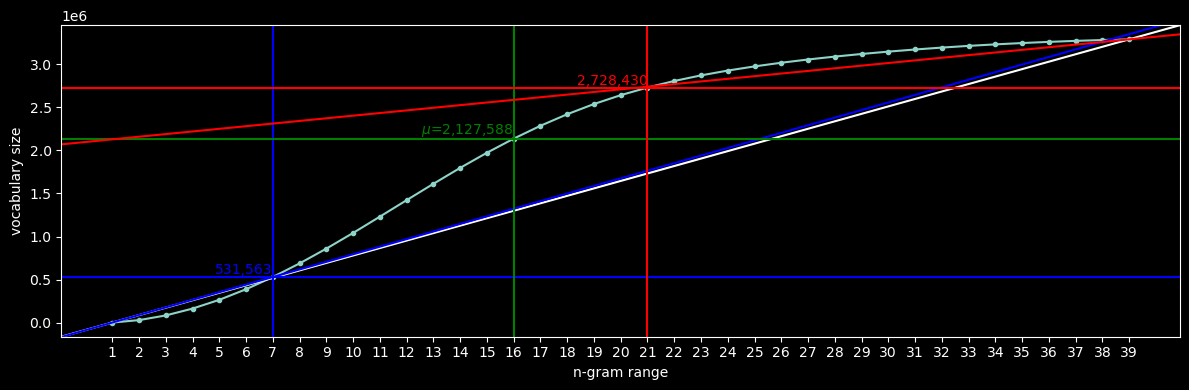

In [126]:
mu = np.mean(vocabulary_sizes)
x=range(1, max_unigrams+1)

plt.figure(figsize=(12,4))
plt.plot(x, vocabulary_sizes, '.-')
plt.xlabel('n-gram range'); plt.ylabel('vocabulary size')
plt.xticks(range(1, max_unigrams+1))
# plt.yticks(vocabulary_sizes)
# for i,j in zip(range(1, len(vocabulary_sizes)), vocabulary_sizes):
#     plt.text(i,j,f'{j:,.0f}', horizontalalignment='right', verticalalignment='bottom', size=8)
#     plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')

# plot to endpoints
plt.axline(xy1=(1,vocabulary_sizes[0]), xy2=(len(vocabulary_sizes), vocabulary_sizes[-1]))
# plot first break
plt.axline(xy1=(1,vocabulary_sizes[0]), xy2=(7, vocabulary_sizes[6]), color='b')
plt.axvline(7, color='b')
plt.axhline(vocabulary_sizes[6], color='b')
plt.text(x=7, y=vocabulary_sizes[6], s=f'{vocabulary_sizes[6]:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='b')
# plot mean
plt.axhline(np.mean(vocabulary_sizes), color='g')
plt.text(x=16, y=mu, s=f'$\mu$={mu:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='g')
plt.axvline(16, color='g')
# plot from mean to max
plt.axline(xy1=(1,mu), xy2=(len(vocabulary_sizes), vocabulary_sizes[-1]), color='r')
plt.axvline(21, color='r')
plt.axhline(vocabulary_sizes[20], color='r')
plt.text(x=21, y=vocabulary_sizes[20], s=f'{vocabulary_sizes[20]:,.0f}', horizontalalignment='right', verticalalignment='bottom', color='r')
plt.tight_layout()
plt.show()

### Stress test

In [128]:
from sklearn.feature_selection import chi2, SelectKBest

`chi2(X, y)`: Compute chi-squared stats between each non-negative feature and class.  
During its execution it allocates 2 arrays of `n_classes` times `n_features` times `float64` size of 8 bytes.

Simulating `chi2` peak memory usage for Murmuhash feature space:

In [187]:
[f'2^{i} => {2**i-(i//31):,} features X {dummy_labels.shape[1]} labels => '
 f'{size(2 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)}' for i in range(18,32)]

['2^18 => 262,144 features X 104 labels => 416.0 MiB',
 '2^19 => 524,288 features X 104 labels => 832.0 MiB',
 '2^20 => 1,048,576 features X 104 labels => 1.6 GiB',
 '2^21 => 2,097,152 features X 104 labels => 3.2 GiB',
 '2^22 => 4,194,304 features X 104 labels => 6.5 GiB',
 '2^23 => 8,388,608 features X 104 labels => 13.0 GiB',
 '2^24 => 16,777,216 features X 104 labels => 26.0 GiB',
 '2^25 => 33,554,432 features X 104 labels => 52.0 GiB',
 '2^26 => 67,108,864 features X 104 labels => 104.0 GiB',
 '2^27 => 134,217,728 features X 104 labels => 208.0 GiB',
 '2^28 => 268,435,456 features X 104 labels => 416.0 GiB',
 '2^29 => 536,870,912 features X 104 labels => 832.0 GiB',
 '2^30 => 1,073,741,824 features X 104 labels => 1.6 TiB',
 '2^31 => 2,147,483,647 features X 104 labels => 3.2 TiB']

We must limit `n_feature` to $2^{25}$ to fit `chi2` runtime in current physical 64GB RAM.

In [236]:
# i=25
# tracemalloc.start()
# tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
#                         ngram_range=(1,1), n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
# current, peak = tracemalloc.get_traced_memory()
# print(f'memory peak {size(peak)}')

Last executed at 2022-09-16 05:56:50 in 10.03s

memory peak 12.2 MiB

`chi2()` stress

In [237]:
# tracemalloc.reset_peak()
# chi2_stats, chi2_p_values = chi2(tdm, dummy_labels)
# current, peak = tracemalloc.get_traced_memory()
# print(f'memory peak {size(peak)}')

Last executed at 2022-09-16 06:01:34 in 2m 58.77s

memory peak 52.9 GiB

`SelectKBest(chi2)` stress test

In [238]:
# k='all'
# tracemalloc.reset_peak()
# red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
# current, peak = tracemalloc.get_traced_memory()
# print(f'memory peak {size(peak)}')
# tracemalloc.stop()

Last executed at 2022-09-16 06:07:29 in 2m 57.19s

memory peak 53.4 GiB

### Simulation

**The next simulation:**

* Performs `HashingVectorizer` on different `n_features` up to $2^{31}-1$ and `ngram_range` from (1,1) to (1,39).
* Each iteration above will result a crescent number of features.
* For each interation, run parallelized `SelectKBest(chi2)` using a 5-point logspace $k$ of respective vocabulary size.

Max `num_jobs` as function of `n_features` limited to $2^{25}$

In [241]:
[(
    max(0, min(16, int((52*2**30) / (2 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)) ))
 ) for i in range(18, 26)]

[16, 16, 16, 16, 8, 4, 2, 1]

In [265]:
threshold = psutil.virtual_memory().available
print('Available virtual memory: ', size(threshold))

# for i in range(18, 32):
for i in range(18, 26): #(18,26) 2^25 => 33,554,432 features X 104 labels => 52.0 GiB'
    for n in range(1, max_unigrams + 1):
        t1=time()
        tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
                                ngram_range=(1, n), n_features=2**i-(i//31), dtype='uint8').fit_transform(text_vector)
        print(f'HashingVectorizer(ngram_range=(1,{n}), n_features=2**{i}-{i//31}): {time()-t1:.2f}s')
        _, hash_counts = np.unique(tdm.data, return_counts=True)
        tdm_nbytes = (tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)
        
        def func(k):
            if k > 2**i-(i//31): # avoid selecting more k features than in n_features
                return f'k={k} exceeded n_feature=2**{i}-{(i//31)}={2**i-(i//31)}', 0
            tracemalloc.start()
            t2 = time()
            red = SelectKBest(chi2, k=k).fit_transform(tdm, dummy_labels)
            t2 = time() - t2
            current, peak = tracemalloc.get_traced_memory()
            red_nbytes = (red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)
            _, hash_counts2 = np.unique(red.data, return_counts=True)
            msg = '2^{}-{} ng:{},{} col:{} maxtf:{} hashes:{} nnz:{} sparse:{:.4f}% size:{} k:{} maxtf:{} hashes:{} nnz:{} sparse:{:.4f}% size:{} cur:{} peak:{} {:.0f}s'
            msg = msg.format(i, (i//31), 1, n, tdm.shape[1], tdm.max(), len(hash_counts), tdm.nnz,
                             (1 - tdm.nnz / (tdm.shape[0] * tdm.shape[1])) * 100, size(tdm_nbytes), k, red.max(),
                             len(hash_counts2), red.nnz, (1 - red.nnz / (red.shape[0] * red.shape[1])) * 100,
                             size(red_nbytes), size(current), size(peak), t2)
            return msg, peak

        # k feature logspace from 2 to vocabulary size of the n_feature and ngram_range combination
        # 16 points according to number of jobs
        k_space = np.logspace(np.log10(2), np.log10(vocabulary_sizes[n-1]), 16).round().astype(int).tolist()
        # max number of 16 cores for 52 GiB threshold
        max_jobs = max(0, min(16, int((52*2**30) / (2 * dummy_labels.shape[1] * (2**i-(i//31)) * np.float64().itemsize)) ))
        
        messages = Parallel(n_jobs = max_jobs)(delayed(func)(k) for k in k_space)
        
        max_peak=0
        for message, peak in messages:
            if (peak >= threshold):
                max_peak = peak
            print(message)
        if max_peak >= threshold:
            print(f'Threshold {size(threshold)} reached: {size(max_peak)}', )
            break
        
    else:
        continue
    break # catches inner break
tracemalloc.stop()

Available virtual memory:  57.2 GiB
HashingVectorizer(ngram_range=(1,1), n_features=2**18-0): 2.42s
2^18-0 ng:1,1 col:262144 maxtf:6 hashes:6 nnz:6441089 sparse:99.9939% size:32.2 MiB k:2 maxtf:5 hashes:5 nnz:19323 sparse:97.5863% size:1.6 MiB cur:1.8 MiB peak:540.1 MiB 11s
2^18-0 ng:1,1 col:262144 maxtf:6 hashes:6 nnz:6441089 sparse:99.9939% size:32.2 MiB k:3 maxtf:6 hashes:6 nnz:36101 sparse:96.9937% size:1.7 MiB cur:1.8 MiB peak:540.1 MiB 8s
2^18-0 ng:1,1 col:262144 maxtf:6 hashes:6 nnz:6441089 sparse:99.9939% size:32.2 MiB k:5 maxtf:6 hashes:6 nnz:76621 sparse:96.1716% size:1.9 MiB cur:2.0 MiB peak:540.1 MiB 12s
2^18-0 ng:1,1 col:262144 maxtf:6 hashes:6 nnz:6441089 sparse:99.9939% size:32.2 MiB k:9 maxtf:6 hashes:6 nnz:169864 sparse:95.2848% size:2.3 MiB cur:2.5 MiB peak:540.1 MiB 8s
2^18-0 ng:1,1 col:262144 maxtf:6 hashes:6 nnz:6441089 sparse:99.9939% size:32.2 MiB k:15 maxtf:6 hashes:6 nnz:405545 sparse:93.2456% size:3.5 MiB cur:3.6 MiB peak:540.1 MiB 9s
2^18-0 ng:1,1 col:262144 

KeyboardInterrupt: 

**Saved results:**
```
Last executed at 2022-09-07 03:43:12 in 31m 39.87s

Available virtual memory:  58.8 GiB
HashingVectorizer.fit_transform time: 125.02
SelectKBest(chi2, k=889).fit_transform time: 7.32
2^20 ng:1,1 col:1048576 maxtf:5.0 hashes:5 nnz:2790363 sparse:99.9993% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521564 sparse:99.2914% size:20.8 MiB cur:38.3 MiB peak:1.7 GiB 132s
HashingVectorizer.fit_transform time: 128.01
SelectKBest(chi2, k=889).fit_transform time: 12.89
2^21 ng:1,1 col:2097152 maxtf:5.0 hashes:5 nnz:2790363 sparse:99.9997% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521421 sparse:99.2914% size:20.8 MiB cur:38.3 MiB peak:3.4 GiB 141s
HashingVectorizer.fit_transform time: 128.14
SelectKBest(chi2, k=889).fit_transform time: 23.99
2^22 ng:1,1 col:4194304 maxtf:5.0 hashes:5 nnz:2790363 sparse:99.9998% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521066 sparse:99.2915% size:20.8 MiB cur:38.3 MiB peak:6.7 GiB 152s
HashingVectorizer.fit_transform time: 126.44
SelectKBest(chi2, k=889).fit_transform time: 46.11
2^23 ng:1,1 col:8388608 maxtf:5.0 hashes:5 nnz:2790363 sparse:99.9999% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521066 sparse:99.2915% size:20.8 MiB cur:38.3 MiB peak:13.2 GiB 173s
HashingVectorizer.fit_transform time: 128.43
SelectKBest(chi2, k=889).fit_transform time: 89.98
2^24 ng:1,1 col:16777216 maxtf:5.0 hashes:5 nnz:2790363 sparse:100.0000% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521066 sparse:99.2915% size:20.8 MiB cur:38.3 MiB peak:26.4 GiB 218s
HashingVectorizer.fit_transform time: 127.05
SelectKBest(chi2, k=889).fit_transform time: 176.35
2^25 ng:1,1 col:33554432 maxtf:5.0 hashes:5 nnz:2790363 sparse:100.0000% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521066 sparse:99.2915% size:20.8 MiB cur:38.3 MiB peak:52.7 GiB 303s
HashingVectorizer.fit_transform time: 127.38
SelectKBest(chi2, k=889).fit_transform time: 652.04
2^26 ng:1,1 col:67108864 maxtf:5.0 hashes:5 nnz:2790363 sparse:100.0000% size:22.8 MiB k:889 maxtf:4.0 hashes:4 nnz:2521066 sparse:99.2915% size:20.8 MiB cur:38.3 MiB peak:105.3 GiB 780s
Threshold reached: 58.8 GiB
```
```
Last executed at 2022-07-31 03:05:20 in 11h 37m 26s

Available virtual memory:  58.1 GiB
2^20 ngram:1,1 cols:1048576 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9985% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6284417 sparse:98.2438% size:49.5 MiB cur:93.9 MiB peak:1.8 GiB 19s
2^20 ngram:1,2 cols:1048576 maxtf:6.0 hashcnt:6 nnz:13481756 sparse:99.9968% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9469756 sparse:97.3537% size:73.8 MiB cur:150.2 MiB peak:1.8 GiB 31s
2^20 ngram:1,3 cols:1048576 maxtf:6.0 hashcnt:6 nnz:20386166 sparse:99.9951% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10480370 sparse:97.0713% size:81.5 MiB cur:221.9 MiB peak:1.9 GiB 42s
2^20 ngram:1,4 cols:1048576 maxtf:6.0 hashcnt:6 nnz:26978409 sparse:99.9936% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9900877 sparse:97.2332% size:77.1 MiB cur:217.4 MiB peak:1.9 GiB 52s
2^20 ngram:1,5 cols:1048576 maxtf:6.0 hashcnt:6 nnz:33220766 sparse:99.9921% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9913306 sparse:97.2297% size:77.2 MiB cur:216.3 MiB peak:1.9 GiB 56s
2^20 ngram:1,6 cols:1048576 maxtf:6.0 hashcnt:6 nnz:39107840 sparse:99.9907% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9808523 sparse:97.2590% size:76.4 MiB cur:344.7 MiB peak:2.0 GiB 70s
2^20 ngram:1,7 cols:1048576 maxtf:6.0 hashcnt:6 nnz:44635058 sparse:99.9894% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9604943 sparse:97.3159% size:74.8 MiB cur:343.2 MiB peak:2.0 GiB 79s
2^20 ngram:1,8 cols:1048576 maxtf:6.0 hashcnt:6 nnz:49789532 sparse:99.9881% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9595722 sparse:97.3185% size:74.7 MiB cur:343.1 MiB peak:2.0 GiB 86s
2^20 ngram:1,9 cols:1048576 maxtf:6.0 hashcnt:6 nnz:54564650 sparse:99.9870% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9530772 sparse:97.3366% size:74.2 MiB cur:342.6 MiB peak:2.0 GiB 94s
2^20 ngram:1,10 cols:1048576 maxtf:6.0 hashcnt:6 nnz:58957847 sparse:99.9860% size:451.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9436924 sparse:97.3629% size:73.5 MiB cur:341.9 MiB peak:2.0 GiB 100s
2^20 ngram:1,11 cols:1048576 maxtf:6.0 hashcnt:6 nnz:62973916 sparse:99.9850% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9340385 sparse:97.3898% size:72.8 MiB cur:341.2 MiB peak:2.0 GiB 108s
2^20 ngram:1,12 cols:1048576 maxtf:6.0 hashcnt:6 nnz:66623607 sparse:99.9841% size:509.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9307168 sparse:97.3991% size:72.5 MiB cur:339.1 MiB peak:2.0 GiB 114s
2^20 ngram:1,13 cols:1048576 maxtf:6.0 hashcnt:6 nnz:69915980 sparse:99.9833% size:534.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9254811 sparse:97.4138% size:72.1 MiB cur:596.5 MiB peak:2.3 GiB 119s
2^20 ngram:1,14 cols:1048576 maxtf:6.0 hashcnt:6 nnz:72863197 sparse:99.9826% size:557.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9229720 sparse:97.4208% size:71.9 MiB cur:596.3 MiB peak:2.3 GiB 124s
2^20 ngram:1,15 cols:1048576 maxtf:6.0 hashcnt:6 nnz:75491080 sparse:99.9820% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9187928 sparse:97.4324% size:71.6 MiB cur:596.0 MiB peak:2.3 GiB 117s
2^20 ngram:1,16 cols:1048576 maxtf:6.0 hashcnt:6 nnz:77826330 sparse:99.9815% size:595.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9125260 sparse:97.4500% size:71.1 MiB cur:595.5 MiB peak:2.3 GiB 132s
2^20 ngram:1,17 cols:1048576 maxtf:6.0 hashcnt:6 nnz:79889330 sparse:99.9810% size:611.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9069526 sparse:97.4655% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 136s
2^20 ngram:1,18 cols:1048576 maxtf:6.0 hashcnt:6 nnz:81700546 sparse:99.9805% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9047987 sparse:97.4716% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 138s
2^20 ngram:1,19 cols:1048576 maxtf:6.0 hashcnt:6 nnz:83278111 sparse:99.9802% size:636.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9044590 sparse:97.4725% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 141s
2^20 ngram:1,20 cols:1048576 maxtf:6.0 hashcnt:6 nnz:84647271 sparse:99.9798% size:647.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9038399 sparse:97.4742% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 143s
2^20 ngram:1,21 cols:1048576 maxtf:6.0 hashcnt:6 nnz:85832325 sparse:99.9796% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9039431 sparse:97.4739% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 146s
2^20 ngram:1,22 cols:1048576 maxtf:6.0 hashcnt:6 nnz:86856494 sparse:99.9793% size:664.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9002035 sparse:97.4844% size:70.2 MiB cur:594.6 MiB peak:2.3 GiB 148s
2^20 ngram:1,23 cols:1048576 maxtf:6.0 hashcnt:6 nnz:87747174 sparse:99.9791% size:671.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9041049 sparse:97.4735% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 149s
2^20 ngram:1,24 cols:1048576 maxtf:6.0 hashcnt:6 nnz:88523010 sparse:99.9789% size:676.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9041912 sparse:97.4733% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 150s
2^20 ngram:1,25 cols:1048576 maxtf:6.0 hashcnt:6 nnz:89199808 sparse:99.9787% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9042453 sparse:97.4731% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 139s
2^20 ngram:1,26 cols:1048576 maxtf:6.0 hashcnt:6 nnz:89794370 sparse:99.9786% size:686.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9042784 sparse:97.4730% size:70.5 MiB cur:594.9 MiB peak:2.3 GiB 153s
2^20 ngram:1,27 cols:1048576 maxtf:6.0 hashcnt:6 nnz:90317792 sparse:99.9785% size:690.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9047290 sparse:97.4717% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 154s
2^20 ngram:1,28 cols:1048576 maxtf:6.0 hashcnt:6 nnz:90778889 sparse:99.9784% size:694.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9050992 sparse:97.4707% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 154s
2^20 ngram:1,29 cols:1048576 maxtf:6.0 hashcnt:6 nnz:91186540 sparse:99.9783% size:697.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051156 sparse:97.4707% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 155s
2^20 ngram:1,30 cols:1048576 maxtf:6.0 hashcnt:6 nnz:91546205 sparse:99.9782% size:700.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051391 sparse:97.4706% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 156s
2^20 ngram:1,31 cols:1048576 maxtf:6.0 hashcnt:6 nnz:91860831 sparse:99.9781% size:702.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051561 sparse:97.4706% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 157s
2^20 ngram:1,32 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92133031 sparse:99.9780% size:704.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9051710 sparse:97.4705% size:70.6 MiB cur:595.0 MiB peak:2.3 GiB 157s
2^20 ngram:1,33 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92365941 sparse:99.9780% size:706.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063561 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 158s
2^20 ngram:1,34 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92561636 sparse:99.9779% size:707.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063657 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 158s
2^20 ngram:1,35 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92724994 sparse:99.9779% size:709.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063701 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 145s
2^20 ngram:1,36 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92858825 sparse:99.9779% size:710.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063717 sparse:97.4672% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,37 cols:1048576 maxtf:6.0 hashcnt:6 nnz:92966708 sparse:99.9779% size:710.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063764 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 165s
2^20 ngram:1,38 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93053279 sparse:99.9778% size:711.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063802 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 161s
2^20 ngram:1,39 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93121043 sparse:99.9778% size:712.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063819 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,40 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93172853 sparse:99.9778% size:712.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063825 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 161s
2^20 ngram:1,41 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93212644 sparse:99.9778% size:712.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063872 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 161s
2^20 ngram:1,42 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93242112 sparse:99.9778% size:712.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063911 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,43 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93263509 sparse:99.9778% size:713.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063928 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,44 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93278338 sparse:99.9778% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063931 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,45 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93288350 sparse:99.9778% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063938 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 146s
2^20 ngram:1,46 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93294963 sparse:99.9778% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063940 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,47 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93299015 sparse:99.9778% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063943 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,48 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93301623 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,49 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93303078 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,50 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93303799 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,51 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93304093 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^20 ngram:1,52 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93304126 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 159s
2^20 ngram:1,53 cols:1048576 maxtf:6.0 hashcnt:6 nnz:93304133 sparse:99.9778% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9063944 sparse:97.4671% size:70.7 MiB cur:595.1 MiB peak:2.3 GiB 160s
2^21 ngram:1,1 cols:2097152 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9992% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:3.4 GiB 24s
2^21 ngram:1,2 cols:2097152 maxtf:6.0 hashcnt:6 nnz:13481758 sparse:99.9984% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9469594 sparse:97.3537% size:73.8 MiB cur:150.2 MiB peak:3.5 GiB 36s
2^21 ngram:1,3 cols:2097152 maxtf:6.0 hashcnt:6 nnz:20386546 sparse:99.9976% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10459150 sparse:97.0772% size:81.3 MiB cur:221.8 MiB peak:3.5 GiB 47s
2^21 ngram:1,4 cols:2097152 maxtf:6.0 hashcnt:6 nnz:26978844 sparse:99.9968% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9863838 sparse:97.2436% size:76.8 MiB cur:217.2 MiB peak:3.5 GiB 57s
2^21 ngram:1,5 cols:2097152 maxtf:6.0 hashcnt:6 nnz:33221209 sparse:99.9960% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9919709 sparse:97.2280% size:77.2 MiB cur:216.4 MiB peak:3.5 GiB 66s
2^21 ngram:1,6 cols:2097152 maxtf:6.0 hashcnt:6 nnz:39110374 sparse:99.9953% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9647120 sparse:97.3041% size:75.1 MiB cur:343.6 MiB peak:3.7 GiB 75s
2^21 ngram:1,7 cols:2097152 maxtf:6.0 hashcnt:6 nnz:44637694 sparse:99.9947% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9607314 sparse:97.3153% size:74.8 MiB cur:343.3 MiB peak:3.7 GiB 77s
2^21 ngram:1,8 cols:2097152 maxtf:6.0 hashcnt:6 nnz:49792266 sparse:99.9941% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9558649 sparse:97.3288% size:74.5 MiB cur:342.9 MiB peak:3.7 GiB 91s
2^21 ngram:1,9 cols:2097152 maxtf:6.0 hashcnt:6 nnz:54567566 sparse:99.9935% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9457287 sparse:97.3572% size:73.7 MiB cur:342.1 MiB peak:3.7 GiB 99s
2^21 ngram:1,10 cols:2097152 maxtf:6.0 hashcnt:6 nnz:58960864 sparse:99.9930% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9350731 sparse:97.3870% size:72.9 MiB cur:341.3 MiB peak:3.7 GiB 105s
2^21 ngram:1,11 cols:2097152 maxtf:6.0 hashcnt:6 nnz:62977541 sparse:99.9925% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9278220 sparse:97.4072% size:72.3 MiB cur:340.8 MiB peak:3.7 GiB 112s
2^21 ngram:1,12 cols:2097152 maxtf:6.0 hashcnt:6 nnz:66627343 sparse:99.9921% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9208145 sparse:97.4268% size:71.8 MiB cur:338.4 MiB peak:3.7 GiB 117s
2^21 ngram:1,13 cols:2097152 maxtf:6.0 hashcnt:6 nnz:69919875 sparse:99.9917% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9094041 sparse:97.4587% size:70.9 MiB cur:595.3 MiB peak:3.9 GiB 123s
2^21 ngram:1,14 cols:2097152 maxtf:6.0 hashcnt:6 nnz:72868007 sparse:99.9913% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9033800 sparse:97.4755% size:70.4 MiB cur:594.9 MiB peak:3.9 GiB 127s
2^21 ngram:1,15 cols:2097152 maxtf:6.0 hashcnt:6 nnz:75496173 sparse:99.9910% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8943019 sparse:97.5009% size:69.8 MiB cur:594.2 MiB peak:3.9 GiB 131s
2^21 ngram:1,16 cols:2097152 maxtf:6.0 hashcnt:6 nnz:77831812 sparse:99.9907% size:595.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8833134 sparse:97.5316% size:68.9 MiB cur:593.4 MiB peak:3.9 GiB 135s
2^21 ngram:1,17 cols:2097152 maxtf:6.0 hashcnt:6 nnz:79894928 sparse:99.9905% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8826808 sparse:97.5334% size:68.9 MiB cur:593.3 MiB peak:3.9 GiB 127s
2^21 ngram:1,18 cols:2097152 maxtf:6.0 hashcnt:6 nnz:81706263 sparse:99.9903% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8812165 sparse:97.5375% size:68.8 MiB cur:593.2 MiB peak:3.9 GiB 142s
2^21 ngram:1,19 cols:2097152 maxtf:6.0 hashcnt:6 nnz:83284041 sparse:99.9901% size:636.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8772324 sparse:97.5486% size:68.5 MiB cur:592.9 MiB peak:3.9 GiB 145s
2^21 ngram:1,20 cols:2097152 maxtf:6.0 hashcnt:6 nnz:84653273 sparse:99.9899% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744057 sparse:97.5565% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 148s
2^21 ngram:1,21 cols:2097152 maxtf:6.0 hashcnt:6 nnz:85838561 sparse:99.9898% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8741694 sparse:97.5571% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 149s
2^21 ngram:1,22 cols:2097152 maxtf:6.0 hashcnt:6 nnz:86862795 sparse:99.9897% size:664.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8742884 sparse:97.5568% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 150s
2^21 ngram:1,23 cols:2097152 maxtf:6.0 hashcnt:6 nnz:87753681 sparse:99.9895% size:671.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743292 sparse:97.5567% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 152s
2^21 ngram:1,24 cols:2097152 maxtf:6.0 hashcnt:6 nnz:88529651 sparse:99.9895% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743406 sparse:97.5567% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 153s
2^21 ngram:1,25 cols:2097152 maxtf:6.0 hashcnt:6 nnz:89206558 sparse:99.9894% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743577 sparse:97.5566% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 142s
2^21 ngram:1,26 cols:2097152 maxtf:6.0 hashcnt:6 nnz:89801280 sparse:99.9893% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8743641 sparse:97.5566% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 156s
2^21 ngram:1,27 cols:2097152 maxtf:6.0 hashcnt:6 nnz:90324723 sparse:99.9892% size:690.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744269 sparse:97.5564% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 157s
2^21 ngram:1,28 cols:2097152 maxtf:6.0 hashcnt:6 nnz:90785902 sparse:99.9892% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744463 sparse:97.5564% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 158s
2^21 ngram:1,29 cols:2097152 maxtf:6.0 hashcnt:6 nnz:91193682 sparse:99.9891% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744582 sparse:97.5563% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 158s
2^21 ngram:1,30 cols:2097152 maxtf:6.0 hashcnt:6 nnz:91553466 sparse:99.9891% size:700.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744894 sparse:97.5563% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,31 cols:2097152 maxtf:6.0 hashcnt:6 nnz:91868130 sparse:99.9891% size:702.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8744987 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,32 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92140393 sparse:99.9890% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745039 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,33 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92373416 sparse:99.9890% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745093 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 160s
2^21 ngram:1,34 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92569152 sparse:99.9890% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745131 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 161s
2^21 ngram:1,35 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92732518 sparse:99.9890% size:709.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745160 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 148s
2^21 ngram:1,36 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92866399 sparse:99.9889% size:710.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745167 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 148s
2^21 ngram:1,37 cols:2097152 maxtf:6.0 hashcnt:6 nnz:92974355 sparse:99.9889% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745175 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,38 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93060983 sparse:99.9889% size:711.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745208 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 161s
2^21 ngram:1,39 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93128771 sparse:99.9889% size:712.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745221 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,40 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93180589 sparse:99.9889% size:712.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745225 sparse:97.5562% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,41 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93220396 sparse:99.9889% size:712.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745267 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,42 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93249865 sparse:99.9889% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745303 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,43 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93271274 sparse:99.9889% size:713.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745304 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,44 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93286104 sparse:99.9889% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745305 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,45 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93296118 sparse:99.9889% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745305 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,46 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93302731 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745307 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 163s
2^21 ngram:1,47 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93306784 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745308 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,48 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93309392 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 163s
2^21 ngram:1,49 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93310847 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,50 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311568 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,51 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311862 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,52 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311895 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 162s
2^21 ngram:1,53 cols:2097152 maxtf:6.0 hashcnt:6 nnz:93311902 sparse:99.9889% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8745309 sparse:97.5561% size:68.2 MiB cur:592.7 MiB peak:3.9 GiB 163s
2^22 ngram:1,1 cols:4194304 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9996% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:6.7 GiB 35s
2^22 ngram:1,2 cols:4194304 maxtf:6.0 hashcnt:6 nnz:13481800 sparse:99.9992% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9468001 sparse:97.3542% size:73.8 MiB cur:150.2 MiB peak:6.7 GiB 47s
2^22 ngram:1,3 cols:4194304 maxtf:6.0 hashcnt:6 nnz:20386589 sparse:99.9988% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10453447 sparse:97.0788% size:81.3 MiB cur:221.7 MiB peak:6.8 GiB 58s
2^22 ngram:1,4 cols:4194304 maxtf:6.0 hashcnt:6 nnz:26978899 sparse:99.9984% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9861600 sparse:97.2442% size:76.8 MiB cur:217.2 MiB peak:6.8 GiB 68s
2^22 ngram:1,5 cols:4194304 maxtf:6.0 hashcnt:6 nnz:33221281 sparse:99.9980% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9913213 sparse:97.2298% size:77.2 MiB cur:216.3 MiB peak:6.8 GiB 78s
2^22 ngram:1,6 cols:4194304 maxtf:6.0 hashcnt:6 nnz:39110468 sparse:99.9977% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9626045 sparse:97.3100% size:75.0 MiB cur:343.4 MiB peak:7.0 GiB 87s
2^22 ngram:1,7 cols:4194304 maxtf:6.0 hashcnt:6 nnz:44637824 sparse:99.9973% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9604825 sparse:97.3159% size:74.8 MiB cur:343.3 MiB peak:7.0 GiB 88s
2^22 ngram:1,8 cols:4194304 maxtf:6.0 hashcnt:6 nnz:49792415 sparse:99.9970% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9534194 sparse:97.3357% size:74.3 MiB cur:342.7 MiB peak:7.0 GiB 103s
2^22 ngram:1,9 cols:4194304 maxtf:6.0 hashcnt:6 nnz:54567830 sparse:99.9967% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9393453 sparse:97.3750% size:73.2 MiB cur:341.6 MiB peak:7.0 GiB 109s
2^22 ngram:1,10 cols:4194304 maxtf:6.0 hashcnt:6 nnz:58961371 sparse:99.9965% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9315957 sparse:97.3967% size:72.6 MiB cur:341.1 MiB peak:7.0 GiB 116s
2^22 ngram:1,11 cols:4194304 maxtf:6.0 hashcnt:6 nnz:62978096 sparse:99.9962% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9230180 sparse:97.4206% size:71.9 MiB cur:340.4 MiB peak:7.0 GiB 122s
2^22 ngram:1,12 cols:4194304 maxtf:6.0 hashcnt:6 nnz:66628007 sparse:99.9960% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9133866 sparse:97.4476% size:71.2 MiB cur:337.8 MiB peak:7.0 GiB 128s
2^22 ngram:1,13 cols:4194304 maxtf:6.0 hashcnt:6 nnz:69920665 sparse:99.9958% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8939609 sparse:97.5018% size:69.7 MiB cur:594.2 MiB peak:7.2 GiB 133s
2^22 ngram:1,14 cols:4194304 maxtf:6.0 hashcnt:6 nnz:72869173 sparse:99.9957% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8833386 sparse:97.5315% size:68.9 MiB cur:593.4 MiB peak:7.2 GiB 138s
2^22 ngram:1,15 cols:4194304 maxtf:6.0 hashcnt:6 nnz:75497579 sparse:99.9955% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8797523 sparse:97.5415% size:68.6 MiB cur:593.1 MiB peak:7.2 GiB 142s
2^22 ngram:1,16 cols:4194304 maxtf:6.0 hashcnt:6 nnz:77833288 sparse:99.9954% size:595.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8774853 sparse:97.5479% size:68.5 MiB cur:592.9 MiB peak:7.2 GiB 146s
2^22 ngram:1,17 cols:4194304 maxtf:6.0 hashcnt:6 nnz:79896432 sparse:99.9952% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8724320 sparse:97.5620% size:68.1 MiB cur:592.5 MiB peak:7.2 GiB 149s
2^22 ngram:1,18 cols:4194304 maxtf:6.0 hashcnt:6 nnz:81707985 sparse:99.9951% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8687849 sparse:97.5722% size:67.8 MiB cur:592.3 MiB peak:7.2 GiB 152s
2^22 ngram:1,19 cols:4194304 maxtf:6.0 hashcnt:6 nnz:83285815 sparse:99.9950% size:636.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8649699 sparse:97.5829% size:67.5 MiB cur:592.0 MiB peak:7.2 GiB 154s
2^22 ngram:1,20 cols:4194304 maxtf:6.0 hashcnt:6 nnz:84655104 sparse:99.9950% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8622679 sparse:97.5904% size:67.3 MiB cur:591.8 MiB peak:7.2 GiB 156s
2^22 ngram:1,21 cols:4194304 maxtf:6.0 hashcnt:6 nnz:85840446 sparse:99.9949% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8612698 sparse:97.5932% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 158s
2^22 ngram:1,22 cols:4194304 maxtf:6.0 hashcnt:6 nnz:86864720 sparse:99.9948% size:664.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8607680 sparse:97.5946% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 160s
2^22 ngram:1,23 cols:4194304 maxtf:6.0 hashcnt:6 nnz:87755665 sparse:99.9948% size:671.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602600 sparse:97.5960% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 161s
2^22 ngram:1,24 cols:4194304 maxtf:6.0 hashcnt:6 nnz:88531721 sparse:99.9947% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602659 sparse:97.5960% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 163s
2^22 ngram:1,25 cols:4194304 maxtf:6.0 hashcnt:6 nnz:89208660 sparse:99.9947% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603256 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 164s
2^22 ngram:1,26 cols:4194304 maxtf:6.0 hashcnt:6 nnz:89803424 sparse:99.9947% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603294 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 165s
2^22 ngram:1,27 cols:4194304 maxtf:6.0 hashcnt:6 nnz:90326924 sparse:99.9946% size:690.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603692 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 166s
2^22 ngram:1,28 cols:4194304 maxtf:6.0 hashcnt:6 nnz:90788124 sparse:99.9946% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603868 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 167s
2^22 ngram:1,29 cols:4194304 maxtf:6.0 hashcnt:6 nnz:91195996 sparse:99.9946% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603887 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 167s
2^22 ngram:1,30 cols:4194304 maxtf:6.0 hashcnt:6 nnz:91555825 sparse:99.9945% size:700.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8604155 sparse:97.5956% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 168s
2^22 ngram:1,31 cols:4194304 maxtf:6.0 hashcnt:6 nnz:91870517 sparse:99.9945% size:702.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8604232 sparse:97.5956% size:67.2 MiB cur:591.6 MiB peak:7.2 GiB 169s
2^22 ngram:1,32 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92142968 sparse:99.9945% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609871 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 169s
2^22 ngram:1,33 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92376000 sparse:99.9945% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609902 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 169s
2^22 ngram:1,34 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92572823 sparse:99.9945% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609907 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,35 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92736197 sparse:99.9945% size:709.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609921 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,36 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92870108 sparse:99.9945% size:710.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609923 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,37 cols:4194304 maxtf:6.0 hashcnt:6 nnz:92978073 sparse:99.9945% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609927 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,38 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93064714 sparse:99.9945% size:711.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609934 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,39 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93132505 sparse:99.9945% size:712.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609947 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 157s
2^22 ngram:1,40 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93184323 sparse:99.9944% size:712.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609950 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,41 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93224133 sparse:99.9944% size:712.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609992 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 172s
2^22 ngram:1,42 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93253885 sparse:99.9944% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609992 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,43 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93275321 sparse:99.9944% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609992 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,44 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93290154 sparse:99.9944% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609993 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,45 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93300168 sparse:99.9944% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609993 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,46 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93306787 sparse:99.9944% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609993 sparse:97.5940% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,47 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93310840 sparse:99.9944% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609994 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 172s
2^22 ngram:1,48 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93313448 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,49 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93314903 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,50 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315624 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^22 ngram:1,51 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315918 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 170s
2^22 ngram:1,52 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315951 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 172s
2^22 ngram:1,53 cols:4194304 maxtf:6.0 hashcnt:6 nnz:93315958 sparse:99.9944% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609995 sparse:97.5939% size:67.2 MiB cur:591.7 MiB peak:7.2 GiB 171s
2^23 ngram:1,1 cols:8388608 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9998% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:13.3 GiB 56s
2^23 ngram:1,2 cols:8388608 maxtf:6.0 hashcnt:6 nnz:13481800 sparse:99.9996% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9467750 sparse:97.3543% size:73.8 MiB cur:150.2 MiB peak:13.3 GiB 69s
2^23 ngram:1,3 cols:8388608 maxtf:6.0 hashcnt:6 nnz:20386589 sparse:99.9994% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10451899 sparse:97.0792% size:81.3 MiB cur:221.7 MiB peak:13.4 GiB 80s
2^23 ngram:1,4 cols:8388608 maxtf:6.0 hashcnt:6 nnz:26978900 sparse:99.9992% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9858701 sparse:97.2450% size:76.7 MiB cur:217.2 MiB peak:13.4 GiB 90s
2^23 ngram:1,5 cols:8388608 maxtf:6.0 hashcnt:6 nnz:33221298 sparse:99.9990% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9910295 sparse:97.2306% size:77.1 MiB cur:216.3 MiB peak:13.4 GiB 100s
2^23 ngram:1,6 cols:8388608 maxtf:6.0 hashcnt:6 nnz:39110495 sparse:99.9988% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9622865 sparse:97.3109% size:74.9 MiB cur:343.4 MiB peak:13.5 GiB 109s
2^23 ngram:1,7 cols:8388608 maxtf:6.0 hashcnt:6 nnz:44637870 sparse:99.9987% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9601555 sparse:97.3169% size:74.8 MiB cur:343.2 MiB peak:13.5 GiB 117s
2^23 ngram:1,8 cols:8388608 maxtf:6.0 hashcnt:6 nnz:49792471 sparse:99.9985% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9542485 sparse:97.3334% size:74.3 MiB cur:342.8 MiB peak:13.5 GiB 117s
2^23 ngram:1,9 cols:8388608 maxtf:6.0 hashcnt:6 nnz:54567910 sparse:99.9984% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9406528 sparse:97.3714% size:73.3 MiB cur:341.7 MiB peak:13.5 GiB 132s
2^23 ngram:1,10 cols:8388608 maxtf:6.0 hashcnt:6 nnz:58961458 sparse:99.9982% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9318707 sparse:97.3959% size:72.6 MiB cur:341.1 MiB peak:13.5 GiB 138s
2^23 ngram:1,11 cols:8388608 maxtf:6.0 hashcnt:6 nnz:62978238 sparse:99.9981% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9240387 sparse:97.4178% size:72.0 MiB cur:340.5 MiB peak:13.5 GiB 144s
2^23 ngram:1,12 cols:8388608 maxtf:6.0 hashcnt:6 nnz:66628502 sparse:99.9980% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9089548 sparse:97.4599% size:70.9 MiB cur:337.5 MiB peak:13.5 GiB 150s
2^23 ngram:1,13 cols:8388608 maxtf:6.0 hashcnt:6 nnz:69921245 sparse:99.9979% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8937651 sparse:97.5024% size:69.7 MiB cur:594.2 MiB peak:13.8 GiB 155s
2^23 ngram:1,14 cols:8388608 maxtf:6.0 hashcnt:6 nnz:72869789 sparse:99.9978% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8830234 sparse:97.5324% size:68.9 MiB cur:593.4 MiB peak:13.8 GiB 159s
2^23 ngram:1,15 cols:8388608 maxtf:6.0 hashcnt:6 nnz:75498198 sparse:99.9978% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8786865 sparse:97.5445% size:68.6 MiB cur:593.0 MiB peak:13.8 GiB 163s
2^23 ngram:1,16 cols:8388608 maxtf:6.0 hashcnt:6 nnz:77833961 sparse:99.9977% size:595.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8740780 sparse:97.5574% size:68.2 MiB cur:592.7 MiB peak:13.8 GiB 167s
2^23 ngram:1,17 cols:8388608 maxtf:6.0 hashcnt:6 nnz:79897131 sparse:99.9976% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8697079 sparse:97.5696% size:67.9 MiB cur:592.3 MiB peak:13.8 GiB 170s
2^23 ngram:1,18 cols:8388608 maxtf:6.0 hashcnt:6 nnz:81708695 sparse:99.9976% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8676306 sparse:97.5754% size:67.7 MiB cur:592.2 MiB peak:13.8 GiB 161s
2^23 ngram:1,19 cols:8388608 maxtf:6.0 hashcnt:6 nnz:83286596 sparse:99.9975% size:637.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8649367 sparse:97.5829% size:67.5 MiB cur:592.0 MiB peak:13.8 GiB 175s
2^23 ngram:1,20 cols:8388608 maxtf:6.0 hashcnt:6 nnz:84655904 sparse:99.9975% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8628728 sparse:97.5887% size:67.4 MiB cur:591.8 MiB peak:13.8 GiB 177s
2^23 ngram:1,21 cols:8388608 maxtf:6.0 hashcnt:6 nnz:85841349 sparse:99.9974% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8618584 sparse:97.5915% size:67.3 MiB cur:591.7 MiB peak:13.8 GiB 179s
2^23 ngram:1,22 cols:8388608 maxtf:6.0 hashcnt:6 nnz:86865640 sparse:99.9974% size:664.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8608050 sparse:97.5945% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 181s
2^23 ngram:1,23 cols:8388608 maxtf:6.0 hashcnt:6 nnz:87756598 sparse:99.9974% size:671.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602842 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 169s
2^23 ngram:1,24 cols:8388608 maxtf:6.0 hashcnt:6 nnz:88532662 sparse:99.9974% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602872 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 171s
2^23 ngram:1,25 cols:8388608 maxtf:6.0 hashcnt:6 nnz:89209736 sparse:99.9973% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602883 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 184s
2^23 ngram:1,26 cols:8388608 maxtf:6.0 hashcnt:6 nnz:89804505 sparse:99.9973% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8602894 sparse:97.5959% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 185s
2^23 ngram:1,27 cols:8388608 maxtf:6.0 hashcnt:6 nnz:90328015 sparse:99.9973% size:690.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603286 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 186s
2^23 ngram:1,28 cols:8388608 maxtf:6.0 hashcnt:6 nnz:90789277 sparse:99.9973% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603453 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 186s
2^23 ngram:1,29 cols:8388608 maxtf:6.0 hashcnt:6 nnz:91197232 sparse:99.9973% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603461 sparse:97.5958% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 188s
2^23 ngram:1,30 cols:8388608 maxtf:6.0 hashcnt:6 nnz:91557075 sparse:99.9973% size:700.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603720 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 188s
2^23 ngram:1,31 cols:8388608 maxtf:6.0 hashcnt:6 nnz:91871770 sparse:99.9973% size:702.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8603787 sparse:97.5957% size:67.2 MiB cur:591.6 MiB peak:13.8 GiB 189s
2^23 ngram:1,32 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92144229 sparse:99.9973% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609418 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 189s
2^23 ngram:1,33 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92377333 sparse:99.9972% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609436 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 189s
2^23 ngram:1,34 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92574251 sparse:99.9972% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609436 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 190s
2^23 ngram:1,35 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92737628 sparse:99.9972% size:709.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609439 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 190s
2^23 ngram:1,36 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92871541 sparse:99.9972% size:710.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609440 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 190s
2^23 ngram:1,37 cols:8388608 maxtf:6.0 hashcnt:6 nnz:92979507 sparse:99.9972% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609444 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,38 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93066155 sparse:99.9972% size:711.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609451 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,39 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93133950 sparse:99.9972% size:712.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609451 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,40 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93185771 sparse:99.9972% size:712.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609454 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,41 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93225592 sparse:99.9972% size:712.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609496 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,42 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93255344 sparse:99.9972% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609496 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,43 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93276782 sparse:99.9972% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609496 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,44 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93291615 sparse:99.9972% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 178s
2^23 ngram:1,45 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93301630 sparse:99.9972% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,46 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93308250 sparse:99.9972% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,47 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93312303 sparse:99.9972% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609497 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,48 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93314916 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,49 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93316371 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,50 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317092 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,51 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317386 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 192s
2^23 ngram:1,52 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317419 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^23 ngram:1,53 cols:8388608 maxtf:6.0 hashcnt:6 nnz:93317426 sparse:99.9972% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8609498 sparse:97.5941% size:67.2 MiB cur:591.7 MiB peak:13.8 GiB 191s
2^24 ngram:1,1 cols:16777216 maxtf:6.0 hashcnt:6 nnz:6441095 sparse:99.9999% size:50.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:6285149 sparse:98.2436% size:49.5 MiB cur:93.9 MiB peak:26.5 GiB 100s
2^24 ngram:1,2 cols:16777216 maxtf:6.0 hashcnt:6 nnz:13481800 sparse:99.9998% size:104.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9465877 sparse:97.3548% size:73.7 MiB cur:150.2 MiB peak:26.5 GiB 113s
2^24 ngram:1,3 cols:16777216 maxtf:6.0 hashcnt:6 nnz:20386590 sparse:99.9997% size:157.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:10451852 sparse:97.0792% size:81.3 MiB cur:221.7 MiB peak:26.6 GiB 123s
2^24 ngram:1,4 cols:16777216 maxtf:6.0 hashcnt:6 nnz:26978906 sparse:99.9996% size:207.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9857259 sparse:97.2454% size:76.7 MiB cur:217.2 MiB peak:26.6 GiB 133s
2^24 ngram:1,5 cols:16777216 maxtf:6.0 hashcnt:6 nnz:33221305 sparse:99.9995% size:255.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9900883 sparse:97.2332% size:77.1 MiB cur:216.3 MiB peak:26.6 GiB 143s
2^24 ngram:1,6 cols:16777216 maxtf:6.0 hashcnt:6 nnz:39110509 sparse:99.9994% size:299.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9610308 sparse:97.3144% size:74.8 MiB cur:343.3 MiB peak:26.7 GiB 152s
2^24 ngram:1,7 cols:16777216 maxtf:6.0 hashcnt:6 nnz:44637886 sparse:99.9993% size:342.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9603976 sparse:97.3162% size:74.8 MiB cur:343.3 MiB peak:26.7 GiB 160s
2^24 ngram:1,8 cols:16777216 maxtf:6.0 hashcnt:6 nnz:49792659 sparse:99.9993% size:381.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9537293 sparse:97.3348% size:74.3 MiB cur:342.7 MiB peak:26.7 GiB 168s
2^24 ngram:1,9 cols:16777216 maxtf:6.0 hashcnt:6 nnz:54568108 sparse:99.9992% size:417.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9402592 sparse:97.3725% size:73.3 MiB cur:341.7 MiB peak:26.7 GiB 175s
2^24 ngram:1,10 cols:16777216 maxtf:6.0 hashcnt:6 nnz:58961688 sparse:99.9991% size:451.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9309143 sparse:97.3986% size:72.6 MiB cur:341.0 MiB peak:26.7 GiB 182s
2^24 ngram:1,11 cols:16777216 maxtf:6.0 hashcnt:6 nnz:62978476 sparse:99.9991% size:482.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9231245 sparse:97.4203% size:72.0 MiB cur:340.4 MiB peak:26.7 GiB 188s
2^24 ngram:1,12 cols:16777216 maxtf:6.0 hashcnt:6 nnz:66628742 sparse:99.9990% size:509.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:9079185 sparse:97.4628% size:70.8 MiB cur:337.4 MiB peak:26.7 GiB 194s
2^24 ngram:1,13 cols:16777216 maxtf:6.0 hashcnt:6 nnz:69921519 sparse:99.9990% size:535.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8838897 sparse:97.5300% size:69.0 MiB cur:593.4 MiB peak:26.9 GiB 199s
2^24 ngram:1,14 cols:16777216 maxtf:6.0 hashcnt:6 nnz:72870112 sparse:99.9989% size:557.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8828790 sparse:97.5328% size:68.9 MiB cur:593.3 MiB peak:26.9 GiB 203s
2^24 ngram:1,15 cols:16777216 maxtf:6.0 hashcnt:6 nnz:75498530 sparse:99.9989% size:577.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8798090 sparse:97.5414% size:68.7 MiB cur:593.1 MiB peak:26.9 GiB 207s
2^24 ngram:1,16 cols:16777216 maxtf:6.0 hashcnt:6 nnz:77834426 sparse:99.9988% size:595.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8709102 sparse:97.5663% size:68.0 MiB cur:592.4 MiB peak:26.9 GiB 210s
2^24 ngram:1,17 cols:16777216 maxtf:6.0 hashcnt:6 nnz:79897649 sparse:99.9988% size:611.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8688374 sparse:97.5720% size:67.8 MiB cur:592.3 MiB peak:26.9 GiB 213s
2^24 ngram:1,18 cols:16777216 maxtf:6.0 hashcnt:6 nnz:81709217 sparse:99.9988% size:624.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8658995 sparse:97.5803% size:67.6 MiB cur:592.0 MiB peak:26.9 GiB 217s
2^24 ngram:1,19 cols:16777216 maxtf:6.0 hashcnt:6 nnz:83287124 sparse:99.9988% size:637.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8632391 sparse:97.5877% size:67.4 MiB cur:591.8 MiB peak:26.9 GiB 219s
2^24 ngram:1,20 cols:16777216 maxtf:6.0 hashcnt:6 nnz:84656435 sparse:99.9987% size:647.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8611117 sparse:97.5936% size:67.2 MiB cur:591.7 MiB peak:26.9 GiB 221s
2^24 ngram:1,21 cols:16777216 maxtf:6.0 hashcnt:6 nnz:85841890 sparse:99.9987% size:656.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8582014 sparse:97.6018% size:67.0 MiB cur:591.5 MiB peak:26.9 GiB 211s
2^24 ngram:1,22 cols:16777216 maxtf:6.0 hashcnt:6 nnz:86866192 sparse:99.9987% size:664.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8581266 sparse:97.6020% size:67.0 MiB cur:591.5 MiB peak:26.9 GiB 212s
2^24 ngram:1,23 cols:16777216 maxtf:6.0 hashcnt:6 nnz:87757157 sparse:99.9987% size:671.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574425 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 214s
2^24 ngram:1,24 cols:16777216 maxtf:6.0 hashcnt:6 nnz:88533227 sparse:99.9987% size:677.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574434 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 215s
2^24 ngram:1,25 cols:16777216 maxtf:6.0 hashcnt:6 nnz:89210304 sparse:99.9987% size:682.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574437 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 215s
2^24 ngram:1,26 cols:16777216 maxtf:6.0 hashcnt:6 nnz:89805078 sparse:99.9987% size:686.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574446 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 215s
2^24 ngram:1,27 cols:16777216 maxtf:6.0 hashcnt:6 nnz:90328604 sparse:99.9987% size:690.7 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8574469 sparse:97.6039% size:66.9 MiB cur:591.4 MiB peak:26.9 GiB 216s
2^24 ngram:1,28 cols:16777216 maxtf:6.0 hashcnt:6 nnz:90789867 sparse:99.9986% size:694.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578383 sparse:97.6028% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 230s
2^24 ngram:1,29 cols:16777216 maxtf:6.0 hashcnt:6 nnz:91197824 sparse:99.9986% size:697.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578387 sparse:97.6028% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 231s
2^24 ngram:1,30 cols:16777216 maxtf:6.0 hashcnt:6 nnz:91557669 sparse:99.9986% size:700.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578641 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 232s
2^24 ngram:1,31 cols:16777216 maxtf:6.0 hashcnt:6 nnz:91872384 sparse:99.9986% size:702.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578642 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 232s
2^24 ngram:1,32 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92144852 sparse:99.9986% size:704.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578651 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 233s
2^24 ngram:1,33 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92377962 sparse:99.9986% size:706.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578666 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 233s
2^24 ngram:1,34 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92574886 sparse:99.9986% size:707.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578666 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 233s
2^24 ngram:1,35 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92738263 sparse:99.9986% size:709.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578667 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,36 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92872176 sparse:99.9986% size:710.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578668 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,37 cols:16777216 maxtf:6.0 hashcnt:6 nnz:92980142 sparse:99.9986% size:710.9 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578670 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,38 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93066791 sparse:99.9986% size:711.6 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578677 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,39 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93134587 sparse:99.9986% size:712.1 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578677 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,40 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93186408 sparse:99.9986% size:712.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578680 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,41 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93226229 sparse:99.9986% size:712.8 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578720 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 235s
2^24 ngram:1,42 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93255981 sparse:99.9986% size:713.0 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578720 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 235s
2^24 ngram:1,43 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93277419 sparse:99.9986% size:713.2 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578720 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 235s
2^24 ngram:1,44 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93292252 sparse:99.9986% size:713.3 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,45 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93302267 sparse:99.9986% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,46 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93308887 sparse:99.9986% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 234s
2^24 ngram:1,47 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93312940 sparse:99.9986% size:713.4 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578721 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,48 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93315553 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,49 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93317008 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,50 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93317729 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,51 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93318023 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,52 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93318056 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 221s
2^24 ngram:1,53 cols:16777216 maxtf:6.0 hashcnt:6 nnz:93318063 sparse:99.9986% size:713.5 MiB k:894 maxtf:6.0 hashcnt:6 nnz:8578722 sparse:97.6027% size:67.0 MiB cur:591.4 MiB peak:26.9 GiB 220s
``` 

Results show `n_features` is the cause of high memory usage, therefore, `n_features` must not be greater than $2^{24}$.

In [127]:
tdm = HashingVectorizer(norm=None, alternate_sign=False, binary=False, token_pattern='(?u)\\b\\w+\\b',
                        n_features=2**20, dtype='uint8').fit_transform(text_vector)
t=time()
red = SelectKBest(chi2, k=max_k).fit_transform(tdm, dummy_labels)
print('SelectKBest elapsed time:',time()-t)
display(red)
print('Sparsity                                            : {:.3f}%'.format((1 - red.nnz / (red.shape[0]*red.shape[1])) * 100))
print('Max count of a unigram hashed token in a document   : {}'.format(red.max()))
print('Max count of a unigram hashed token in all documents: {}'.format(red.sum(axis=0).max()))
print('Max unique hashed tokens per document               : {}'.format(red.sum(axis=1).max()))
print('Mean unique hashed tokens per document              : {:.1f}'.format(red.sum(axis=1).mean()))
print('Median unique tokens per document                   : {}'.format(np.median(np.array(red.sum(axis=1)).reshape(-1))))
print('Sparse matrix memory usage                          :', size((red.data.nbytes + red.indptr.nbytes + red.indices.nbytes)))
print('Dense matrix memory equivalence                     :', size(red.shape[0]*red.shape[1]*tdm.dtype.itemsize))

SelectKBest elapsed time: 7.285495281219482


<400277x888 sparse matrix of type '<class 'numpy.uint8'>'
	with 6281056 stored elements in Compressed Sparse Row format>

Sparsity                                            : 98.233%
Max count of a unigram hashed token in a document   : 6
Max count of a unigram hashed token in all documents: 331001
Max unique hashed tokens per document               : 53
Mean unique hashed tokens per document              : 19.4
Median unique tokens per document                   : 18.0
Sparse matrix memory usage                          : 31.5 MiB
Dense matrix memory equivalence                     : 339.0 MiB


**Cross-validation and multiprocessing considerations:**

Considering these results and as intended to perform a multi-processed k-fold cross-validation over the complete pipeline, the number of processors times the memory `n_features` must be tunned to fit within the 58GiB or less, otherwise it would be necessary to tune `n_features` and `k`.

Althought `k` hasn't very affected memory usage in the current step (`SelectKBest`) it surely will in the step (`PolynomialFeatures`).

## Feature union

In [128]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
get_numeric_data = FunctionTransformer(disambiguate, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total', 'sparse':True})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': LABELS, 'sep':' '})
union = FeatureUnion([
    ('numeric_features', Pipeline([
        ('numeric_selector', get_numeric_data),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True))
    ])),
    ('text_features', Pipeline([
        ('text_selector', get_text_data),
        ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, token_pattern=None,
                                         dtype='uint8', tokenizer=custom_sentence_tokenizer)),
        ('reduction', SelectKBest(chi2))
    ]))
])

In [129]:
# reproducibility reloads data to avoid things done during EDA
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
dummy_labels = pd.get_dummies(df[LABELS], prefix_sep='__')
NUMERIC_FEATURES=['FTE', 'Total']
FEATURES = TEXT_FEATURES + NUMERIC_FEATURES
#
union.set_params(text_features__reduction__k = max_k)
tdm = union.fit_transform(df[FEATURES], dummy_labels)
display(tdm)
display(pd.DataFrame(tdm.toarray()))

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x894 sparse matrix of type '<class 'numpy.float32'>'
	with 2030961 stored elements in Compressed Sparse Row format>

0            1             2    3    4    5    6    7    8    9    \
0       1.00000     0.000000  50471.808594  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1       0.00000  3477.860107      0.000000  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
2       1.00000     0.000000  62237.128906  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3       0.00000    22.299999      0.000000  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
4       0.00000    54.166000      0.000000  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
...         ...          ...           ...  ...  ...  ...  ...  ...  ...  ...   
400272  0.00000    48.619999      0.000000  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
400273  0.00431     0.000000    128.824982  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
400274  1.00000     0.000000   4902.290039  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
400275  0.00000  4020.290039      0.000000  1.0  0.0  1.0  0.0  0.0  0.0  0.0   
400276  0.00000    46.529999      0.000000  1.0  0.0  1.0  0.0  0.0  0.0  0.0   

        ...  884  885  886  887  888  889  890  891  892  893  
0       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
400272  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
400273  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
400274  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
400275  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
400276  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[400277 rows x 894 columns]

Sparsity                           : 0.9943245091364834
Sparse matrix memory usage         : 17.0 MiB
Dense matrix memory equivalence    : 1.3 GiB


`FeatureUnion` haven't increased memory usage significantly more than the previous step `SelectKBest`.

`n_features=2**20` is still the goal and `k` must be assessed in the step `PolynomialFeatures`.

## Adding interaction terms

In [130]:
from sklearn.preprocessing import PolynomialFeatures

* Interaction terms are statistical tools that lets your model express what happens if two features appear together in the same row.
* `degree` tells what polynomial degree of interactions to compute.
* Pipelines with interaction terms take a while to train because the number of features in the output array scales polynomially in the number of features of the input array, and exponentially in the degree. High degrees can cause overfitting.

Trying different number of features: $\beta_1x_1 + \beta_2x_2 + \beta_3(x_1x_2)$

When `interaction_only = True` only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.):

$$interactions = \frac{features \times (features + 1)}{2}$$

### Dense interactions

In [131]:
dense_matrix = np.array([[0,0],[0,1],[1,0],[1,1]], dtype='float32')
print(f'{dense_matrix.shape[0]}x{dense_matrix.shape[1]} matrix:\n', dense_matrix)
interacted_matrix = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(dense_matrix).astype('float32')
print(f'{interacted_matrix.shape[0]}x{interacted_matrix.shape[1]} interactions:\n', interacted_matrix)

4x2 matrix:
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
4x3 interactions:
 [[0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]]


### Sparse interactions

In [132]:
from scipy.sparse import csr_matrix
sparse_matrix=csr_matrix(dense_matrix)
print(repr(sparse_matrix))
print(sparse_matrix)

<4x2 sparse matrix of type '<class 'numpy.float32'>'
	with 4 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0


In [133]:
interactor = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interactor.fit(sparse_matrix)
interacted_sparse_matrix = interactor.transform(sparse_matrix)
print('Feature names:', interactor.get_feature_names_out())
print(repr(interacted_sparse_matrix))
print(interacted_sparse_matrix)

Feature names: ['x0' 'x1' 'x0 x1']
<4x3 sparse matrix of type '<class 'numpy.float32'>'
	with 5 stored elements in Compressed Sparse Row format>
  (1, 1)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 2)	1.0


Estimating interactions on a feature space:

In [134]:
['{} features result {:.0f} interactions'.format(x, x*(x+1)/2) for x in [894]]

['894 features result 400065 interactions']

Plotting interactions as a function of the number of features.  The red lines show the maximum of number of features whose interactions are smaller than the dataset observations, by the formula:

$$max\ features =  {\Bigg\lfloor{\frac{\sqrt{8 \times observations + 1} -1 }{2}}\Bigg\rceil}$$

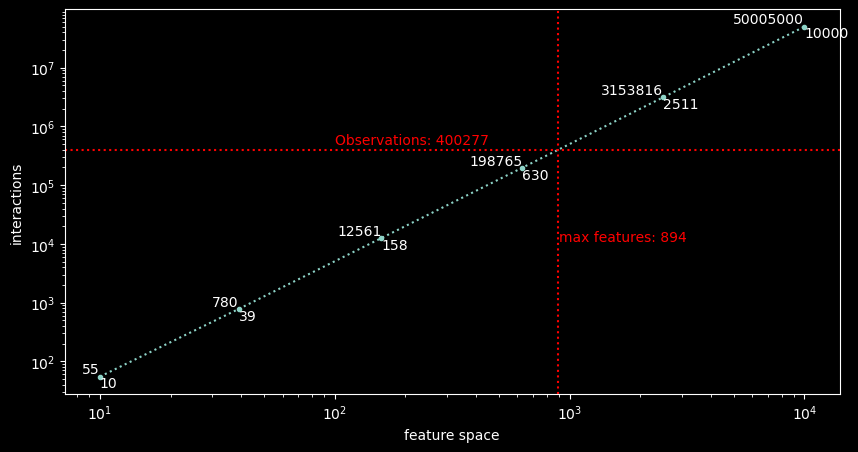

In [135]:
feature_space = np.logspace(np.log10(10), np.log10(10000), 6, dtype='int64')
interactions = (feature_space * (feature_space + 1) / 2).astype('int64')
max_features = int((np.sqrt(8 * df.shape[0] + 1) - 1) / 2)

plt.figure(figsize=(10,5))
plt.loglog(feature_space, interactions, marker='.', linestyle='dotted')
plt.axhline(df.shape[0] , linestyle='dotted', color='red')
plt.text(x=100, y=df.shape[0]*1.1, s='Observations: {}'.format(df.shape[0]), verticalalignment='bottom', color='red')

plt.axvline(max_features , linestyle='dotted', color='red')
plt.text(x=max_features*1.01, y=10**4, s='max features: {}'.format(max_features), verticalalignment='bottom', color='red')
for i,j in zip(feature_space, interactions):
    plt.text(i,j,j, horizontalalignment='right', verticalalignment='bottom')
    plt.text(i,j,i, horizontalalignment='left', verticalalignment='top')
plt.xlabel('feature space')
plt.ylabel('interactions')
plt.show()

## Interacting features

The next simulation takes all numeric and text features from the whole dataset and performs `HashingVectorizer`, `SelectKBest` and `PolynomialFeatures` under different parameters to understand memory limitations.  

For each `ngram_range` a specific parameter space is assigned.  Each space is a log space starting from $2^{2.5}$ to the limit of the `CountVectorizer` resulting features for a given `ngram_range`

In [136]:
union.set_params(text_features__reduction__k = max_k)
tdm = union.fit_transform(df[FEATURES], dummy_labels)
tdm = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True).fit_transform(tdm)
display(tdm)

print('Sparsity                           : {}'.format(1 - tdm.nnz / (tdm.shape[0]*tdm.shape[1])))
print('Sparse matrix memory usage         :', size((tdm.data.nbytes + tdm.indptr.nbytes + tdm.indices.nbytes)))
print('Dense matrix memory equivalence    :', size(tdm.shape[0]*tdm.shape[1]*tdm.dtype.itemsize))

<400277x400065 sparse matrix of type '<class 'numpy.float32'>'
	with 6308821 stored elements in Compressed Sparse Row format>

Sparsity                           : 0.999960603557142
Sparse matrix memory usage         : 49.7 MiB
Dense matrix memory equivalence    : 596.6 GiB


## Feature scaling

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), also known as data normalization, is a method used to normalize the range of independent variables or features of data.

See [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

One can use different **scalers, transformers, and normalizers** to bring the data within a pre-defined range.

Scalers are **linear transformers** (more precisely [affine transformers](https://en.wikipedia.org/wiki/Affine_transformation)) and differ from each other in the way to estimate the parameters used to shift and scale **each feature**:
* `StandardScaler` - standardizes features by removing the mean and scaling to unit variance
```
(x - np.mean(x)) / np.std(x)
```
* `MinMaxScaler` - transforms features by scaling each feature to a given range, default (0, 1)
```
a = 0; b = 1; a + ( (x-min(x)) * (b-a) ) / (max(x) - min(x))
```
* `MaxAbsScaler` - scales each feature by its maximum absolute value to a range (-1, 1)
```
x / np.max(np.abs(x))
```
* `RobustScaler` - scales features using statistics that are robust to outliers

Transformers provides non-linear transformations:
* `QuantileTransformer` - transforms features using quantiles information, where distances between marginal outliers and inliers are shrunk.
* `PowerTransformer` - applies a power transform featurewise to make data more Gaussian-like, where data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a **per sample** transformation instead of a **per feature** transformation:
* `Normalizer` - normalizes samples individually to unit norm
> Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community.

Initial considerations:
* `StandardScaler`, `MinMaxScaler` and `MaxAbsScaler` are very sensitive to the presence of outliers when computing mean and standard deviations therefore cannot guarantee balanced feature scales in the presence of outliers.
* `MinMaxScaler` doesn't support sparse input
* `MaxAbsScaler` values are mapped across 3 ranges depending on whether negative OR positive values are present. If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1]. 
* On positive only data, `MaxAbsScaler` behaves similarly to MinMaxScaler.
* The centering and scaling statistics of the `RobustScaler` are based on percentiles and not influenced by a few number of very large marginal outliers. The resulting range of the 
transformed feature values is larger than for the previous scalers and are approximately similar.
* `PowerTransformer(method='Yeo-Johnson')` can be applied to both negative and positive data. Requires dense input.
* `PowerTransformer(method='Box-Cox')` can only be applied to strictly positive data. Requires dense input.
* `QuantileTransformer(output_distribution='gaussian')`: Note that this non-parametetric transformer introduces saturation artifacts for outliers.
* `QuantileTransformer(output_distribution='uniform')` as `RobustScaler`, are robust to outliers but they will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

Final considerations:

For this problem, we need to scale a sparse matrix without destroying any sparsity, i.e., non-stored zero values should continue being like that.  The scalers/settings supporting that are:
* `StandardScaler(with_mean=False)`
* `MaxAbsScaler`
* `RobustScaler(with_centering=False)`
* `Normalizer(norm='l2')`
* `Normalizer(norm='l1')`

From these, the only scaler not sensible to outliers is the `RobustScaler`

In [137]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, Normalizer

In [138]:
scalers = [("StandardScaler(with_mean=False)", StandardScaler(with_mean=False)), # because True doesn't work with sparse matrix
           ("MaxAbsScaler()", MaxAbsScaler()),
           ("Normalizer(norm='l2')", Normalizer(norm='l2')),
           ("Normalizer(norm='l1')", Normalizer(norm='l1')),
           # ('RobustScaler(with_centering=False)', RobustScaler(with_centering=False)) # takes much too long
          ]
tracemalloc.start()
tracemalloc.reset_peak()
for name, scaler in scalers:
    t=time()
    tdm2 = scaler.fit_transform(tdm, dummy_labels)
    t=time()-t
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    print(f'{name:<31} min: {tdm2.min():>20} max: {tdm2.max():>15} current: {size(current)} peak: {size(peak)} {t:.2f}s')
tracemalloc.stop()    

StandardScaler(with_mean=False) min:     -632.67529296875 max: 632.67529296875 current: 58.8 MiB peak: 158.1 MiB 0.06s
MaxAbsScaler()                  min:                 -1.0 max:             1.0 current: 61.9 MiB peak: 185.3 MiB 0.08s
Normalizer(norm='l2')           min:  -0.7071067690849304 max:             1.0 current: 61.9 MiB peak: 111.6 MiB 0.02s
Normalizer(norm='l1')           min:  -0.4999825358390808 max:             1.0 current: 61.9 MiB peak: 111.6 MiB 0.02s


## Pipeline: Logistic Regression

In [139]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, PolynomialFeatures
from preprocessing.combine_text_columns import combine_text_columns
from sklearn.metrics import classification_report
from metrics.log_loss import multi_multi_log_loss
from metrics.log_loss import log_loss_report_part, log_loss_report
from dummies import get_dummies_indices
from model_selection.multilabel import multilabel_train_test_split, multilabel_sample_dataframe

get_numeric_data = FunctionTransformer(disambiguate, validate=False,
                                       kw_args = {'reference':'FTE', 'ambiguous':'Total', 'sparse':True})
get_text_data = FunctionTransformer(combine_text_columns, validate=False,
                                    kw_args = {'to_drop': LABELS, 'sep':' '})
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('numeric_selector', get_numeric_data),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True))
        ], verbose=True #, memory='/data/drivendata/cache'
        )),
        ('text_features' , Pipeline([
            ('text_selector', get_text_data),
            ('vectorizer', HashingVectorizer(norm=None, binary=False, alternate_sign=False, dtype='uint8',
                                             token_pattern='(?u)\\b\\w+\\b')),
            ('reducer', SelectKBest(score_func=chi2))
        ], verbose=True #, memory='/data/drivendata/cache'
        ))
    ], verbose=True, n_jobs=None
    )),
    ('interactor', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', MaxAbsScaler()),
    ('classifier', OneVsRestClassifier(
        LogisticRegression(C=1.0, random_state=1, solver='liblinear', n_jobs=None, verbose=0),
        n_jobs=-1, verbose=0))
], verbose=True #, memory='/data/drivendata/cache'
)

### 1% sample, 90/10 split

In [140]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.01, min_count=28, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=0.1, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]}, k: {max_k}, C:{C}')

Training: 3602, testing: 400, k: 78, C:1


In [141]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)
pl.set_params(classifier__estimator__solver = "lbfgs")
pl.set_params(classifier__estimator__max_iter = 100)
pl.set_params(classifier__estimator__n_jobs = None)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'3602-k78-logistic-regression-C1'

In [142]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Fitting started on 2022-09-14T03:28
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.5s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   5.6s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.6s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.1s
Done: 0.1 minutes
Saving cache 3602-k78-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T03:28
Training accuracy         : 0.4250
Training log loss

```
Solver lbfgs: Last executed at 2022-09-14 01:27:18 in 7.91s

Fitting started on 2022-09-14T01:27
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   5.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=   5.8s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.1s
Done: 0.1 minutes
Saving cache 3602-k78-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T01:27
Training accuracy         : 0.4250
Training log loss         : 0.4820
Training report finished on 2022-09-14T01:27, elapsed 0.0 minutes

Testing report started on 2022-09-14T01:27
Testing accuracy         : 0.3550
Testing log loss         : 0.6382
Testing report finished on 2022-09-14T01:27, elapsed 0.0 minutes
```

In [143]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 10% sample, 90/10 split

In [144]:
sampling = multilabel_sample_dataframe(df, dummy_labels, size=0.1, min_count=28, seed=1)
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(sampling[FEATURES], pd.get_dummies(sampling[LABELS], prefix_sep='__'), size=0.1, min_count=0, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 36025, testing: 4002 k: 261 C:1


In [145]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)
pl.set_params(classifier__estimator__solver = "lbfgs")
pl.set_params(classifier__estimator__max_iter = 300)
pl.set_params(classifier__estimator__n_jobs = None)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'36025-k261-logistic-regression-C1'

In [146]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Fitting started on 2022-09-14T03:29
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   0.4s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   6.3s
[Pipeline] ............. (step 1 of 4) Processing union, total=   6.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.1min
Done: 1.2 minutes
Saving cache 36025-k261-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T03:30
Training accuracy         : 0.8799
Training log lo

```
LBFGS ITER 300:
Last executed at 2022-09-14 02:54:45 in 1m 22.97s

Fitting started on 2022-09-14T02:53
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   3.4s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.7s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   9.3s
[Pipeline] ............. (step 1 of 4) Processing union, total=   9.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.0min
Done: 1.2 minutes
Saving cache 36025-k261-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T02:54
Training accuracy         : 0.8799
Training log loss         : 0.0927
Training report finished on 2022-09-14T02:54, elapsed 0.2 minutes

Testing report started on 2022-09-14T02:54
Testing accuracy         : 0.8126
Testing log loss         : 0.1567
Testing report finished on 2022-09-14T02:54, elapsed 0.0 minutes


LIBLINEAR:
Last executed at 2022-09-14 02:50:51 in 1m 23.46s

Fitting started on 2022-09-14T02:49
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   3.3s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   0.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   5.7s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=   9.2s
[Pipeline] ............. (step 1 of 4) Processing union, total=   9.2s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.1min
Done: 1.2 minutes
Saving cache 36025-k261-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T02:50
Training accuracy         : 0.8805
Training log loss         : 0.0932
Training report finished on 2022-09-14T02:50, elapsed 0.2 minutes

Testing report started on 2022-09-14T02:50
Testing accuracy         : 0.8128
Testing log loss         : 0.1569
Testing report finished on 2022-09-14T02:50, elapsed 0.0 minutes

```

In [147]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


### 60/40 split

In [152]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.4, min_count=20, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

Training: 240167, testing: 160110 k: 686 C:1


In [153]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)
pl.set_params(classifier__estimator__solver = "lbfgs") # 18.9 min, 0.0685
pl.set_params(classifier__estimator__max_iter = 600)
pl.set_params(classifier__estimator__n_jobs = None)
# pl.set_params(classifier__estimator__solver = "liblinear") # 15 min, 0.0686
# pl.set_params(classifier__estimator__max_iter = 100)
# pl.set_params(classifier__estimator__n_jobs = None)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

'240167-k686-logistic-regression-C1'

In [154]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Loading cache 240167-k686-logistic-regression-C1 ... done: 0.0 minutes
Training report started on 2022-09-14T04:10
Training accuracy         : 0.9437
Training log loss         : 0.0476
Training report finished on 2022-09-14T04:11, elapsed 0.6 minutes

Testing report started on 2022-09-14T04:11
Testing accuracy         : 0.9188
Testing log loss         : 0.0686
Testing report finished on 2022-09-14T04:11, elapsed 0.4 minutes



```
LBFGS MAX_ITER=600, N_JOBS=None
Last executed at 2022-09-14 04:04:09 in 20m 16.69s

Fitting started on 2022-09-14T03:43
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   2.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.5s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.6s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  11.0s
[Pipeline] ............. (step 1 of 4) Processing union, total=  11.1s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=19.1min
Done: 19.3 minutes
Saving cache 240167-k686-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T04:03
Training accuracy         : 0.9437
Training log loss         : 0.0476
Training report finished on 2022-09-14T04:03, elapsed 0.6 minutes

Testing report started on 2022-09-14T04:03
Testing accuracy         : 0.9188
Testing log loss         : 0.0686
Testing report finished on 2022-09-14T04:04, elapsed 0.4 minutes


LBFGS MAX_ITER=600, N_JOBS=-1
Last executed at 2022-09-14 03:20:14 in 21m 57.88s

Fitting started on 2022-09-14T02:58
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  22.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.5s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.5s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  30.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  30.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.0s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=19.3min
Done: 19.9 minutes
Saving cache 240167-k686-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-14T03:18
Training accuracy         : 0.9437
Training log loss         : 0.0476
Training report finished on 2022-09-14T03:19, elapsed 1.3 minutes

Testing report started on 2022-09-14T03:19
Testing accuracy         : 0.9188
Testing log loss         : 0.0686
Testing report finished on 2022-09-14T03:20, elapsed 0.8 minutes



LIBLINEAR
Last executed at 2022-09-13 10:45:05 in 16m 8.48s

Fitting started on 2022-09-13T10:28
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.0s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   2.9s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.4s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   6.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  10.7s
[Pipeline] ............. (step 1 of 4) Processing union, total=  10.7s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.3s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   0.9s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=15.0min
Done: 15.2 minutes
Saving cache 240167-k686-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-13T10:44
Training accuracy         : 0.9436
Training log loss         : 0.0477
Training report finished on 2022-09-13T10:44, elapsed 0.5 minutes

Testing report started on 2022-09-13T10:44
Testing accuracy         : 0.9191
Testing log loss         : 0.0686
Testing report finished on 2022-09-13T10:45, elapsed 0.4 minutes
```

In [155]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

Saving CSV...Done: 0.1 minutes
Zipping...Done: 0.1 minutes


Your score for this submission is: 0.4930

### 80/20 split

In [ ]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=25, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
C=1
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} C:{C}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)
pl.set_params(classifier__estimator__solver = "lbfgs")
pl.set_params(classifier__estimator__max_iter = 500)
pl.set_params(classifier__estimator__n_jobs = None)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

Testing log loss         : 0.0650  
Your score for this submission is: 0.5076

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

### 100%

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
C=1
print(f'Training: {train_sample_size} k: {max_k} C:{C}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__C = C)
pl.set_params(classifier__estimator__solver = "lbfgs")
pl.set_params(classifier__estimator__max_iter = 500)
pl.set_params(classifier__estimator__n_jobs = -1)
modelname = f'{train_sample_size}-k{max_k}-logistic-regression-C{C}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]), summary=True)

**Saved results**
```
Last executed at 2022-09-08 21:29:04 in 31m 33.24s

Fitting started on 2022-09-08T20:57
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   4.5s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  14.1s
[Pipeline] ............. (step 1 of 4) Processing union, total=  14.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=30.5min
Done: 30.7 minutes
Saving cache 400277-k889-logistic-regression-C1 ... Done: 0.0 minutes
Training report started on 2022-09-08T21:28
Training accuracy         : 0.9458
Training log loss         : 0.0462
Training report finished on 2022-09-08T21:29, elapsed 0.8 minutes
Your score for this submission is: 0.5219

Last executed at 2022-09-08 17:33:48 in 34m 42.63s

[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   4.6s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.2s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.5s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  14.3s
[Pipeline] ............. (step 1 of 4) Processing union, total=  14.5s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.5s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=32.7min
Training report started on 2022-09-08T17:32
Training accuracy         : 0.9461
Training log loss         : 0.0458


Last executed at 2022-08-03 09:36:27 in 31m 42.52s

Fitting started on 2022-08-03T09:04
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.4s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.4s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=  10.3s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=  17.0s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  34.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  35.3s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   1.2s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=31.1min
Done: 31.7 minutes
```

Training log loss: 0.0460  
Your score for this submission is: 0.5140

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

## Pipeline: Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl.steps[3] = ('classifier',
               OneVsRestClassifier(
                   RandomForestClassifier(n_estimators=100,  # default 100
                                          criterion="gini", # default "gini"
                                          max_depth=None,  # default None (leaves are pure or < min_samples_split)
                                          min_samples_split=2,  # default 2
                                          min_samples_leaf=1,  # default 1
                                          max_features='sqrt',  # default 'auto' (sqrt(n_features))
                                          bootstrap=True,  # default=True
                                          n_jobs=None,  # default None
                                          random_state=1, #default None
                                          ), n_jobs=-1))

# n_estimators=1, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 197s
# n_estimators=1, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 215s
# n_estimators=1, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 201s
# n_estimators=10, n_jobs=-1, max_depth=4, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 274s
# n_estimators=1, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 455s
# * n_estimators=10, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 1720s
# n_estimators=10, n_jobs=-1, max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 289s
# n_estimators=10, n_jobs=-1, max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 300s
# n_estimators=10, n_jobs=-1, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 362s
# n_estimators=10, n_jobs=-1, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): 22m
# n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=sqrt(n): ~4h

### 80/20 split

In [ ]:
X_train, X_test, y_train, y_test = \
    multilabel_train_test_split(df[FEATURES], dummy_labels, size=0.2, min_count=25, seed=1)
train_sample_size = X_train.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size}, testing: {X_test.shape[0]} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
pl.set_params(classifier__estimator__n_jobs = -1)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, X_train, y_train, '/data/drivendata/models/2022/', modelname)
log_loss_report(pl, X_train, y_train, X_test, y_test, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Last executed at 2022-09-08 18:50:21 in 3m 33.77s

Fitting started on 2022-09-08T18:46
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   3.7s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.9s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.1s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  12.8s
[Pipeline] ............. (step 1 of 4) Processing union, total=  12.9s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.4s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.1min
Done: 1.4 minutes
Saving cache 320222-k794-random-forest-estimators10-depth10 ... Done: 0.0 minutes
Training report started on 2022-09-08T18:48
Training accuracy         : 0.2539
Training log loss         : 0.6642
Training report finished on 2022-09-08T18:49, elapsed 1.7 minutes

Testing report started on 2022-09-08T18:49
Testing accuracy         : 0.2487
Testing log loss         : 0.6724
Testing report finished on 2022-09-08T18:50, elapsed 0.4 minutes
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

### 100%

In [ ]:
train_sample_size = df.shape[0]
max_k = max_interactions(train_sample_size, minus=6)
n_estimators = 10
max_depth = 10
print(f'Training: {train_sample_size} k: {max_k} n_estimators: {n_estimators} max_depth: {max_depth}')

In [ ]:
pl.set_params(union__text_features__reducer__k = max_k)
pl.set_params(classifier__estimator__n_estimators = n_estimators)
pl.set_params(classifier__estimator__max_depth = max_depth)
pl.set_params(classifier__estimator__n_jobs = -1)
modelname = f'{train_sample_size}-k{max_k}-random-forest-estimators{n_estimators}-depth{max_depth}'
modelname

In [ ]:
pl = fit_cache(pl, df[FEATURES], dummy_labels, '/data/drivendata/models/2022/', modelname)
log_loss_report_part(pl, df[FEATURES], dummy_labels, LABELS, get_dummies_indices(df[LABELS]), summary=True)

```
Last executed at 2022-09-08 18:55:49 in 4m 6.70s

Fitting started on 2022-09-08T18:51
[Pipeline] .. (step 1 of 2) Processing numeric_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing imputer, total=   0.0s
[FeatureUnion]  (step 1 of 2) Processing numeric_features, total=   0.1s
[Pipeline] ..... (step 1 of 3) Processing text_selector, total=   4.6s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   2.4s
[Pipeline] ........... (step 3 of 3) Processing reducer, total=   7.4s
[FeatureUnion] . (step 2 of 2) Processing text_features, total=  14.4s
[Pipeline] ............. (step 1 of 4) Processing union, total=  14.5s
[Pipeline] ........ (step 2 of 4) Processing interactor, total=   0.5s
[Pipeline] ............ (step 3 of 4) Processing scaler, total=   1.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 1.5min
Done: 1.8 minutes
Saving cache 400277-k889-random-forest-estimators10-depth10 ... Done: 0.0 minutes
Training report started on 2022-09-08T18:53
Training accuracy         : 0.2354
Training log loss         : 0.6801
Training report finished on 2022-09-08T18:55, elapsed 2.3 minutes
```

In [ ]:
to_csv_to_zip('/data/drivendata/predictions/2022/', modelname, pl.predict_proba(holdout), holdout.index, dummy_labels.columns)

# Learning from the Experts

* NLP tricks: Range of n-grams, punctuation tokenization (regular expression)
* Stats trick: Interaction terms
* Computation trick: Hashing vectorizer
* What class of model to use?
    * Deep Convolutional Neural Network?
    * Extreme Gradient Boosted Trees
    * An ensemble of local-expert elasticnet regressions?
* **No, the winning model was the Logistic Regression and not a cutting edge algorithm**
    * Carefully create features
    * Easily implemented tricks

> Rather than reaching advanced alghoritms hard to interpret and expensive to train it's always worth it to see how far you can get with simpler methods.

# Can you do better?

Ways to improve:

* NLP: Stemming, stop-word removal
* Model: RandomForest, k-NN, Naïve Bayes
* Numeric preprocessing: Imputation strategies
* Optimization: Grid search over pipeline objects
* Experiment new scikit-learn tech docs